In [1]:
import rasterio as rio
import matplotlib.pyplot as plt 
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import geopandas as gpd
import shapely.geometry
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

dataDirDiscovery = '/dartfs-hpc/rc/lab/C/CMIG/ecoffel/data/projects/ag-land-climate'

In [2]:
run ../util/setupConsole

In [3]:
# low and high temps for gdd/kdd calcs, taken from Butler, et al, 2015, ERL
t_low = 9
t_high = 29

crop = 'Maize'
wxData = 'era5'

useTrendMethod = True

yearRange = [1981, 2019]

In [4]:
sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

In [ ]:
# load gdd/kdd from cpc temperature data
if wxData == 'cpc':
    gdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([len(sacksLat), len(sacksLon), (yearRange[1]-yearRange[0]+1)], np.nan)
elif wxData == 'era5':
    gdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)
    kdd = np.full([721, 1440, (yearRange[1]-yearRange[0]+1)], np.nan)

for y, year in enumerate(np.arange(yearRange[0], yearRange[1]+1)):
    with gzip.open('%s/kdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curKdd = pickle.load(f)
        kdd[:, :, y] = curKdd
        
    with gzip.open('%s/gdd-%s-%s-%d.dat'%(dataDirDiscovery, wxData, crop, year), 'rb') as f:
        curGdd = pickle.load(f)
        gdd[:, :, y] = curGdd

with gzip.open('%s/gdd-kdd-lat-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lat = pickle.load(f)

with gzip.open('%s/gdd-kdd-lon-%s.dat'%(dataDirDiscovery, wxData), 'rb') as f:
    lon = pickle.load(f)


In [ ]:
if wxData == 'cpc':
    with gzip.open('%s/seasonal-precip-maize-gpcp.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
elif wxData == 'era5':
    with open('%s/seasonal-precip-maize-era5.dat'%dataDirDiscovery, 'rb') as f:
        seasonalPrecip = pickle.load(f)
        # m -> mm
        seasonalPrecip *= 1000
        seasonalPrecip[seasonalPrecip==0] = np.nan

In [ ]:
with open('%s/seasonal-et-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalEvap = pickle.load(f)
with open('%s/seasonal-sshf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSshf = pickle.load(f)
with open('%s/seasonal-slhf-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSlhf = pickle.load(f)
with open('%s/seasonal-ssr-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSsr = pickle.load(f)
with open('%s/seasonal-str-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalStr = pickle.load(f)
with open('%s/seasonal-u10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalU10 = pickle.load(f)
with open('%s/seasonal-v10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalV10 = pickle.load(f)
with open('%s/seasonal-seconds-maize.dat'%(dataDirDiscovery), 'rb') as f:
    seasonalSeconds = pickle.load(f)
    seasonalSeconds[seasonalSeconds<0] = -seasonalSeconds[seasonalSeconds<0]

In [ ]:
# with open('%s/seasonal-et-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalEvap = pickle.load(f)
# with open('%s/seasonal-sshf-maize-gldas-noah.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalSshf_Noah = pickle.load(f)
# with open('%s/seasonal-sshf-maize-gldas-mosaic.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalSshf_Mosaic = pickle.load(f)
# with open('%s/seasonal-ssr-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalSsr = pickle.load(f)
# with open('%s/seasonal-str-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalStr = pickle.load(f)
# with open('%s/seasonal-u10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalU10 = pickle.load(f)
# with open('%s/seasonal-v10-maize-era5.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalV10 = pickle.load(f)
# with open('%s/seasonal-seconds-maize.dat'%(dataDirDiscovery), 'rb') as f:
#     seasonalSeconds = pickle.load(f)
#     seasonalSeconds[seasonalSeconds<0] = -seasonalSeconds[seasonalSeconds<0]

In [ ]:
# calculate gdd and kdd trends from already-loaded cpc tmax and tmin data
with open('%s/kdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    kddTrends = pickle.load(f)

with open('%s/gdd-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    gddTrends = pickle.load(f)

with open('%s/evap-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    evapTrends = pickle.load(f)

with open('%s/sshf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    sshfTrends = pickle.load(f)

with open('%s/slhf-%s-trends-%s-%d-%d.dat'%(dataDirDiscovery, wxData, crop, yearRange[0], yearRange[1]), 'rb') as f:
    slhfTrends = pickle.load(f)

In [ ]:
faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dataDirDiscovery
irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
irrigationLon[irrigationLon<0] += 360

In [ ]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dataDirDiscovery)
sacksMaizeStart = sacksMaizeNc['plant'].values + 1
sacksMaizeStart = np.roll(sacksMaizeStart, -int(sacksMaizeStart.shape[1]/2), axis=1)
sacksMaizeStart[sacksMaizeStart < 0] = np.nan
sacksMaizeEnd = sacksMaizeNc['harvest'].values + 1
sacksMaizeEnd = np.roll(sacksMaizeEnd, -int(sacksMaizeEnd.shape[1]/2), axis=1)
sacksMaizeEnd[sacksMaizeEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

sacksSoybeanNc = xr.open_dataset('%s/sacks/Soybeans.crop.calendar.fill.nc'%dataDirDiscovery)
sacksSoybeanStart = sacksSoybeanNc['plant'].values + 1
sacksSoybeanStart = np.roll(sacksSoybeanStart, -int(sacksSoybeanStart.shape[1]/2), axis=1)
sacksSoybeanStart[sacksSoybeanStart < 0] = np.nan
sacksSoybeanEnd = sacksSoybeanNc['harvest'].values + 1
sacksSoybeanEnd = np.roll(sacksSoybeanEnd, -int(sacksSoybeanEnd.shape[1]/2), axis=1)
sacksSoybeanEnd[sacksSoybeanEnd < 0] = np.nan


In [ ]:
# cRange=[0, 100]
# plt.figure(figsize=(10,7))
# ax = plt.axes(projection=ccrs.PlateCarree())
# c = plt.pcolormesh(irrigationLon, irrigationLat, np.clip(irrigationData, cRange[0], cRange[1]), cmap='Greens', vmin=cRange[0], vmax=cRange[1])
# cbar = plt.colorbar(c, orientation='horizontal', pad = 0.01)
# cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 10))
# cbar.set_label('%s irrigation fraction'%crop)
# ax.coastlines()

In [ ]:
cRange=[-10, 10]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lon, lat, np.clip(gddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad = 0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season GDD Trend'%crop)
ax.coastlines()

In [ ]:
cRange=[-4, 4]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(lon, lat, np.clip(kddTrends, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 1))
cbar.set_label('%s growing season KDD Trend'%crop)
ax.coastlines()

In [ ]:
sshfChg = -(np.nanmean(seasonalSshf[:,:,-2:],axis=2)-np.nanmean(seasonalSshf[:,:,0:2],axis=2))/seasonalSeconds

cRange=[-20, 20]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(sacksLon, sacksLat, np.clip(sshfChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season SH Trend'%crop)
ax.coastlines()

In [ ]:

slhfChg = -(np.nanmean(seasonalSlhf[:,:,-2:],axis=2)-np.nanmean(seasonalSlhf[:,:,0:2],axis=2))/seasonalSeconds
# slhfMean = np.nanmean(-seasonalSlhf,axis=2)*30/seasonalSeconds
# cRange=[0, 200]
cRange=[-20,20]
plt.figure(figsize=(10,7))
ax = plt.axes(projection=ccrs.PlateCarree())
c = plt.pcolormesh(sacksLon, sacksLat, np.clip(slhfChg, cRange[0], cRange[1]), cmap='bwr', vmin=cRange[0], vmax=cRange[1])
cbar = plt.colorbar(c, orientation='horizontal', pad=0.01)
cbar.set_ticks(np.arange(cRange[0], cRange[1]+.1, 2))
cbar.set_label('%s growing season LH Trend'%crop)
ax.coastlines()

In [ ]:
# load NASS yield data

nassCountyArea = pd.read_csv('%s/nass/maize-county-area.csv'%dataDirDiscovery)

nassMaizePlantedArea1 = pd.read_csv('%s/nass/maize-area-planted-1961-1974.csv'%dataDirDiscovery)
nassMaizePlantedArea2 = pd.read_csv('%s/nass/maize-area-planted-1975-1994.csv'%dataDirDiscovery)
nassMaizePlantedArea3 = pd.read_csv('%s/nass/maize-area-planted-1995-2019.csv'%dataDirDiscovery)
nassMaizePlantedArea = pd.concat([nassMaizePlantedArea1[::-1], nassMaizePlantedArea2[::-1], nassMaizePlantedArea3[::-1]])

nassMaizeHarvestedArea1 = pd.read_csv('%s/nass/maize-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassMaizeHarvestedArea2 = pd.read_csv('%s/nass/maize-area-harvested-1970-1981.csv'%dataDirDiscovery)
nassMaizeHarvestedArea3 = pd.read_csv('%s/nass/maize-area-harvested-1982-2001.csv'%dataDirDiscovery)
nassMaizeHarvestedArea4 = pd.read_csv('%s/nass/maize-area-harvested-2002-2019.csv'%dataDirDiscovery)
nassMaizeHarvestedArea = pd.concat([nassMaizeHarvestedArea1[::-1], nassMaizeHarvestedArea2[::-1], \
                                    nassMaizeHarvestedArea3[::-1], nassMaizeHarvestedArea4[::-1]])

nassSoybeanHarvestedArea1 = pd.read_csv('%s/nass/soybean-area-harvested-1961-1969.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea2 = pd.read_csv('%s/nass/soybean-area-harvested-1970-1995.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea3 = pd.read_csv('%s/nass/soybean-area-harvested-1996-2019.csv'%dataDirDiscovery)
nassSoybeanHarvestedArea = pd.concat([nassSoybeanHarvestedArea1[::-1], nassSoybeanHarvestedArea2[::-1], \
                                    nassSoybeanHarvestedArea3[::-1]])

nassMaizeProd1 = pd.read_csv('%s/nass/nass-maize-production-1961-1974.csv'%dataDirDiscovery)
nassMaizeProd2 = pd.read_csv('%s/nass/nass-maize-production-1975-1994.csv'%dataDirDiscovery)
nassMaizeProd3 = pd.read_csv('%s/nass/nass-maize-production-1995-2019.csv'%dataDirDiscovery)
nassMaizeProd = pd.concat([nassMaizeProd1[::-1], nassMaizeProd2[::-1], nassMaizeProd3[::-1]])

nassMaizeYield1 = pd.read_csv('%s/nass/maize-yield-1961-1978.csv'%dataDirDiscovery)
nassMaizeYield2 = pd.read_csv('%s/nass/maize-yield-1979-1998.csv'%dataDirDiscovery)
nassMaizeYield3 = pd.read_csv('%s/nass/maize-yield-1999-2019.csv'%dataDirDiscovery)
nassMaizeYield = pd.concat([nassMaizeYield1[::-1], nassMaizeYield2[::-1], nassMaizeYield3[::-1]])

nassSoybeanYield1 = pd.read_csv('%s/nass/soybean-yield-1961-1989.csv'%dataDirDiscovery)
nassSoybeanYield2 = pd.read_csv('%s/nass/soybean-yield-1990-2019.csv'%dataDirDiscovery)
nassSoybeanYield = pd.concat([nassSoybeanYield1[::-1], nassSoybeanYield2[::-1]])



In [ ]:
usStateAbbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [ ]:
nassMaizeStates = list(nassMaizeYield['State'])
nassMaizeStateAbvs = []
for s in nassMaizeStates:
    nassMaizeStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeYield['StateAbvs'] = nassMaizeStateAbvs

nassSoybeanStates = list(nassSoybeanYield['State'])
nassSoybeanStateAbvs = []
for s in nassSoybeanStates:
    nassSoybeanStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanYield['StateAbvs'] = nassSoybeanStateAbvs

nassMaizeProdStates = list(nassMaizeProd['State'])
nassMaizeProdStateAbvs = []
for s in nassMaizeProdStates:
    nassMaizeProdStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeProd['StateAbvs'] = nassMaizeProdStateAbvs

nassMaizePlantedAreaStates = list(nassMaizePlantedArea['State'])
nassMaizePlantedAreaStateAbvs = []
for s in nassMaizePlantedAreaStates:
    nassMaizePlantedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizePlantedArea['StateAbvs'] = nassMaizePlantedAreaStateAbvs

nassMaizeHarvestedAreaStates = list(nassMaizeHarvestedArea['State'])
nassMaizeHarvestedAreaStateAbvs = []
for s in nassMaizeHarvestedAreaStates:
    nassMaizeHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassMaizeHarvestedArea['StateAbvs'] = nassMaizeHarvestedAreaStateAbvs

nassSoybeanHarvestedAreaStates = list(nassSoybeanHarvestedArea['State'])
nassSoybeanHarvestedAreaStateAbvs = []
for s in nassSoybeanHarvestedAreaStates:
    nassSoybeanHarvestedAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassSoybeanHarvestedArea['StateAbvs'] = nassSoybeanHarvestedAreaStateAbvs

nassCountyAreaStates = list(nassCountyArea['State'])
nassCountyAreaStateAbvs = []
for s in nassCountyAreaStates:
    nassCountyAreaStateAbvs.append(usStateAbbrev[s.lower().title()])
nassCountyArea['StateAbvs'] = nassCountyAreaStateAbvs

In [ ]:
maizeYieldDeepak = []
for year in range(1981, 2013+1):
    curMaizeYield = xr.open_dataset('%s/deepak/Maize_yield_1970_2013/Maize_areaweightedyield_%d_ver12b.nc'%(dataDirDiscovery, year), decode_cf=False)
    
    if len(maizeYieldDeepak) == 0:
        maizeYieldDeepak = curMaizeYield
    else:
        maizeYieldDeepak = xr.concat([maizeYieldDeepak, curMaizeYield], dim='time')
    
maizeYieldDeepak.load()

# flip latitude axis so top is +90
latDeepak = np.flipud(maizeYieldDeepak.latitude)
lonDeepak = np.roll(maizeYieldDeepak.longitude, int(len(maizeYieldDeepak.longitude)/2), axis=0)
lonDeepak[lonDeepak<0] += 360
maizeYieldDeepak['Data'] = maizeYieldDeepak.Data.transpose('latitude', 'longitude', 'time', 'level')
maizeYieldDeepakData = np.roll(np.flip(maizeYieldDeepak.Data, axis=0), int(len(maizeYieldDeepak.longitude)/2), axis=1)

maizeYieldDeepak['latitude'] = latDeepak
maizeYieldDeepak['longitude'] = lonDeepak
maizeYieldDeepak['Data'] = (('latitude', 'longitude', 'time'), np.squeeze(maizeYieldDeepakData))

In [ ]:
def findConsec(data):
    # find longest consequtative sequence of years with yield data
    ptMax = (-1, -1)
    ptCur = (-1, -1)
    for i, val in enumerate(data):
        # start sequence
        if ~np.isnan(val) and ptCur[0] == -1:
            ptCur = (i, -1)
        #end sequence
        elif (np.isnan(val) and ptCur[0] >= 0):
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
            ptCur = (-1, -1)
        # reached end of sequence
        elif i >= len(data)-1 and ptCur[0] >= 0:
            ptCur = (ptCur[0], i)
            if ptCur[1]-ptCur[0] > ptMax[1]-ptMax[0] or ptMax == (-1, -1):
                ptMax = ptCur
    return ptMax

In [ ]:
minCropYears = 10
minCropYearsDeepak = 10

rebuild=True

if os.path.isfile('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
    usCounties = pd.read_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))
else:
    usCounties = gpd.read_file('%s/us-county-lat-long/c_02jn20.shp'%dataDirDiscovery)

    usCounties['temp'] = np.full(len(usCounties), np.nan)
    usCounties['tempLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['tempLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLatInds'] = np.full(len(usCounties), np.nan)
    usCounties['prLonInds'] = np.full(len(usCounties), np.nan)
    usCounties['gdd'] = np.full(len(usCounties), np.nan)
    usCounties['kdd'] = np.full(len(usCounties), np.nan)
    usCounties['gddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddTrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['gddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['kddDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecip'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalPrecipDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvap'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEvapDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSeconds'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSshf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSshfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSlhf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSlhfDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalEf'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalEfTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalSsr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalSsrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalStr'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrTrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalStrDetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalU10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalU10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['seasonalV10'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Trend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10Detrend'] = np.full(len(usCounties), np.nan)
    usCounties['seasonalV10DetrendNorm'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanPlantingDate'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestDate'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeCountyArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeCountyIrrigationFraction'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizePlantedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizePlantedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['maizeHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanHarvestedArea'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaFraction'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaYears'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanHarvestedAreaTrend'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeYield'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['maizeYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['soybeanYield'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMean'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldTrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendPlusMeanDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldDetrendNormDeepak'] = np.full(len(usCounties), np.nan)
    usCounties['soybeanYieldYears'] = np.full(len(usCounties), np.nan)
    
    usCounties['maizeProd'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdTrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrend'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdDetrendNorm'] = np.full(len(usCounties), np.nan)
    usCounties['maizeProdYears'] = np.full(len(usCounties), np.nan)

    # this is needed to store list in dataframe... kind of hacky
    usCounties = usCounties.astype(object)

    for c in range(usCounties.shape[0]):
        
        if c % 100 == 0:
            print('%.0f %% done'%(c/usCounties.shape[0]*100))
        
        bounds = usCounties['geometry'][c].bounds
        lat1 = bounds[1]
        lat2 = bounds[3]
        lon1 = bounds[0]
        lon2 = bounds[2]

        if lon1 < 0: lon1 += 360
        if lon2 < 0: lon2 += 360
            

        deepakLatInds = [np.where(abs(latDeepak-lat2) == np.nanmin(abs(latDeepak-lat2)))[0][0],
                   np.where(abs(latDeepak-lat1) == np.nanmin(abs(latDeepak-lat1)))[0][0]]
        deepakLonInds = [np.where(abs(lonDeepak-lon1) == np.nanmin(abs(lonDeepak-lon1)))[0][0],
                   np.where(abs(lonDeepak-lon2) == np.nanmin(abs(lonDeepak-lon2)))[0][0]]
            
        tempLatInds = [np.where(abs(lat-lat2) == np.nanmin(abs(lat-lat2)))[0][0],
                   np.where(abs(lat-lat1) == np.nanmin(abs(lat-lat1)))[0][0]]
        tempLonInds = [np.where(abs(lon-lon1) == np.nanmin(abs(lon-lon1)))[0][0],
                   np.where(abs(lon-lon2) == np.nanmin(abs(lon-lon2)))[0][0]]
        
        prLatInds = [np.where(abs(sacksLat-lat2) == np.nanmin(abs(sacksLat-lat2)))[0][0],
                   np.where(abs(sacksLat-lat1) == np.nanmin(abs(sacksLat-lat1)))[0][0]]
        prLonInds = [np.where(abs(sacksLon-lon1) == np.nanmin(abs(sacksLon-lon1)))[0][0],
                   np.where(abs(sacksLon-lon2) == np.nanmin(abs(sacksLon-lon2)))[0][0]]
    
        irrLatInds = [np.where(abs(irrigationLat-lat2) == np.nanmin(abs(irrigationLat-lat2)))[0][0],
                   np.where(abs(irrigationLat-lat1) == np.nanmin(abs(irrigationLat-lat1)))[0][0]]
        irrLonInds = [np.where(abs(irrigationLon-lon1) == np.nanmin(abs(irrigationLon-lon1)))[0][0],
                   np.where(abs(irrigationLon-lon2) == np.nanmin(abs(irrigationLon-lon2)))[0][0]]
        
        if len(tempLatInds) == 0 or len(tempLonInds) == 0 or \
           len(prLatInds) == 0 or len(prLonInds) == 0:
            break

        usCounties['tempLatInds'][c] = tempLatInds
        usCounties['tempLonInds'][c] = tempLonInds
        
        usCounties['prLatInds'][c] = prLatInds
        usCounties['prLonInds'][c] = prLonInds
        
        deepakLatIndsRange = np.arange(min(deepakLatInds), max(deepakLatInds)+1)
        deepakLonIndsRange = np.arange(min(deepakLonInds), max(deepakLonInds)+1)
        
        if len(deepakLatInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(maizeYieldDeepak.Data.values[deepakLatIndsRange, :, :])
        
        if len(deepakLonInds) > 1:
            countyMaizeYieldDeepak = np.nanmean(countyMaizeYieldDeepak[deepakLonIndsRange, :], axis=0)
        else:
            countyMaizeYieldDeepak = np.squeeze(countyMaizeYieldDeepak[deepakLonIndsRange, :])
        
        # add padding so yield array is same length as nass arrays
        countyMaizeYieldDeepak = np.pad(countyMaizeYieldDeepak, (0, 5), 'constant', constant_values=(np.nan))
        
        tempLatIndsRange = np.arange(min(tempLatInds), max(tempLatInds)+1)
        tempLonIndsRange = np.arange(min(tempLonInds), max(tempLonInds)+1)
        
        prLatIndsRange = np.arange(min(prLatInds), max(prLatInds)+1)
        prLonIndsRange = np.arange(min(prLonInds), max(prLonInds)+1)
        
        irrLatIndsRange = np.arange(min(irrLatInds), max(irrLatInds)+1)
        irrLonIndsRange = np.arange(min(irrLonInds), max(irrLonInds)+1)

        if len(tempLatIndsRange) > 1:
            countyGdd = np.nanmean(gdd[tempLatIndsRange, :, :], axis=0)
            countyKdd = np.nanmean(kdd[tempLatIndsRange, :, :], axis=0)
        else:
            countyGdd = np.squeeze(gdd[tempLatIndsRange, :, :])
            countyKdd = np.squeeze(kdd[tempLatIndsRange, :, :])
        
        if len(prLatIndsRange) > 1:
            countyPrecip = np.nanmean(seasonalPrecip[prLatIndsRange, :, :], axis=0)
            countyEvap = np.nanmean(seasonalEvap[prLatIndsRange, :, :], axis=0)
            countySshf = np.nanmean(seasonalSshf[prLatIndsRange, :, :], axis=0)
            countySlhf = np.nanmean(seasonalSlhf[prLatIndsRange, :, :], axis=0)
            countySsr = np.nanmean(seasonalSsr[prLatIndsRange, :, :], axis=0)
            countyStr = np.nanmean(seasonalStr[prLatIndsRange, :, :], axis=0)
            countyU10 = np.nanmean(seasonalU10[prLatIndsRange, :, :], axis=0)
            countyV10 = np.nanmean(seasonalV10[prLatIndsRange, :, :], axis=0)
            countySeasonalSeconds = np.nanmean(seasonalSeconds[prLatIndsRange, :], axis=0)
            countyMaizePlantDate = np.nanmean(sacksMaizeStart[prLatIndsRange, :], axis=0)
            countySoybeanPlantDate = np.nanmean(sacksSoybeanStart[prLatIndsRange, :], axis=0)
            countyMaizeHarvestDate = np.nanmean(sacksMaizeEnd[prLatIndsRange, :], axis=0)
            countySoybeanHarvestDate = np.nanmean(sacksSoybeanEnd[prLatIndsRange, :], axis=0)
        else:
            countyPrecip = np.squeeze(seasonalPrecip[prLatIndsRange, :, :])
            countyEvap = np.squeeze(seasonalEvap[prLatIndsRange, :, :])
            countySshf = np.squeeze(seasonalSshf[prLatIndsRange, :, :])
            countySlhf = np.squeeze(seasonalSlhf[prLatIndsRange, :, :])
            countySsr = np.squeeze(seasonalSsr[prLatIndsRange, :, :])
            countyStr = np.squeeze(seasonalStr[prLatIndsRange, :, :])
            countyU10 = np.squeeze(seasonalU10[prLatIndsRange, :, :])
            countyV10 = np.squeeze(seasonalV10[prLatIndsRange, :, :])
            countySeasonalSeconds = np.squeeze(seasonalSeconds[prLatIndsRange, :])
            countyMaizePlantDate = np.squeeze(sacksMaizeStart[prLatIndsRange, :])
            countySoybeanPlantDate = np.squeeze(sacksSoybeanStart[prLatIndsRange, :])
            countyMaizeHarvestDate = np.squeeze(sacksMaizeEnd[prLatIndsRange, :])
            countySoybeanHarvestDate = np.squeeze(sacksSoybeanEnd[prLatIndsRange, :])

        if len(tempLonIndsRange) > 1:
            countyGdd = np.nanmean(countyGdd[tempLonIndsRange, :], axis=0)
            countyKdd = np.nanmean(countyKdd[tempLonIndsRange, :], axis=0)
        else:
            countyGdd = np.squeeze(countyGdd[tempLonIndsRange, :])
            countyKdd = np.squeeze(countyKdd[tempLonIndsRange, :])
        
        if len(prLonIndsRange) > 1:
            countyPrecip = np.nanmean(countyPrecip[prLonIndsRange, :], axis=0)
            countyEvap = np.nanmean(countyEvap[prLonIndsRange, :], axis=0)
            countySshf = np.nanmean(countySshf[prLonIndsRange, :], axis=0)
            countySlhf = np.nanmean(countySlhf[prLonIndsRange, :], axis=0)
            countySsr = np.nanmean(countySsr[prLonIndsRange, :], axis=0)
            countyStr = np.nanmean(countyStr[prLonIndsRange, :], axis=0)
            countyU10 = np.nanmean(countyU10[prLonIndsRange, :], axis=0)
            countyV10 = np.nanmean(countyV10[prLonIndsRange, :], axis=0)
            countySeasonalSeconds = np.nanmean(countySeasonalSeconds[prLonIndsRange], axis=0)
            countyMaizePlantDate = np.nanmean(countyMaizePlantDate[prLonIndsRange], axis=0)
            countySoybeanPlantDate = np.nanmean(countySoybeanPlantDate[prLonIndsRange], axis=0)
            countyMaizeHarvestDate = np.nanmean(countyMaizeHarvestDate[prLonIndsRange], axis=0)
            countySoybeanHarvestDate = np.nanmean(countySoybeanHarvestDate[prLonIndsRange], axis=0)
        else:
            countyPrecip = np.squeeze(countyPrecip[prLonIndsRange, :])
            countyEvap = np.squeeze(countyEvap[prLonIndsRange, :])
            countySshf = np.squeeze(countySshf[prLonIndsRange, :])
            countySlhf = np.squeeze(countySlhf[prLonIndsRange, :])
            countySsr = np.squeeze(countySsr[prLonIndsRange, :])
            countyStr = np.squeeze(countyStr[prLonIndsRange, :])
            countyU10 = np.squeeze(countyU10[prLonIndsRange, :])
            countyV10 = np.squeeze(countyV10[prLonIndsRange, :])
            countySeasonalSeconds = np.squeeze(countySeasonalSeconds[prLonIndsRange])
            countyMaizePlantDate = np.squeeze(countyMaizePlantDate[prLonIndsRange])
            countySoybeanPlantDate = np.squeeze(countySoybeanPlantDate[prLonIndsRange])
            countyMaizeHarvestDate = np.squeeze(countyMaizeHarvestDate[prLonIndsRange])
            countySoybeanHarvestDate = np.squeeze(countySoybeanHarvestDate[prLonIndsRange])

        usCounties['seasonalSeconds'][c] = countySeasonalSeconds
        usCounties['maizePlantingDate'][c] = countyMaizePlantDate
        usCounties['soybeanPlantingDate'][c] = countySoybeanPlantDate
        usCounties['maizeHarvestDate'][c] = countyMaizeHarvestDate
        usCounties['soybeanHarvestDate'][c] = countySoybeanHarvestDate
            
        if len(irrLatIndsRange) > 1:
            countyIrrigation = np.nanmean(irrigationData[irrLatIndsRange, :], axis=0)
        else:
            countyIrrigation = np.squeeze(irrigationData[irrLatIndsRange, :])
        
        if len(irrLonIndsRange) > 1:
            countyIrrigation = np.nanmean(countyIrrigation[irrLonIndsRange])
        else:
            countyIrrigation = np.squeeze(countyIrrigation[irrLonIndsRange])
        
        usCounties['maizeCountyIrrigationFraction'][c] = countyIrrigation
        
        curCountyName = usCounties['COUNTYNAME'][c].lower()
        nassMaizeYieldCounties = np.array(list(map(str.lower, nassMaizeYield['County'])))
        nassMaizeProdCounties = np.array(list(map(str.lower, nassMaizeProd['County'])))
        nassMaizePlantedAreaCounties = np.array(list(map(str.lower, nassMaizePlantedArea['County'])))
        nassMaizeHarvestedAreaCounties = np.array(list(map(str.lower, nassMaizeHarvestedArea['County'])))
        nassCountyAreaCounties = np.array(list(map(str.lower, nassCountyArea['County'])))
        
        curStateName = usCounties['STATE'][c].lower()
        nassMaizeYieldStates = np.array(list(map(str.lower, nassMaizeYield['StateAbvs'])))
        nassMaizeProdStates = np.array(list(map(str.lower, nassMaizeProd['StateAbvs'])))
        nassMaizePlantedAreaStates = np.array(list(map(str.lower, nassMaizePlantedArea['StateAbvs'])))
        nassMaizeHarvestedAreaStates = np.array(list(map(str.lower, nassMaizeHarvestedArea['StateAbvs'])))
        nassCountyAreaStates = np.array(list(map(str.lower, nassCountyArea['StateAbvs'])))

        countyIndMaizeYield = np.where((curCountyName == nassMaizeYieldCounties) & (curStateName == nassMaizeYieldStates))[0]
        countyIndMaizeProd = np.where((curCountyName == nassMaizeProdCounties) & (curStateName == nassMaizeProdStates))[0]
        countyIndMaizePlantedArea = np.where((curCountyName == nassMaizePlantedAreaCounties) & (curStateName == nassMaizePlantedAreaStates))[0]
        countyIndMaizeHarvestedArea = np.where((curCountyName == nassMaizeHarvestedAreaCounties) & (curStateName == nassMaizeHarvestedAreaStates))[0]
        countyIndCountyArea = np.where((curCountyName == nassCountyAreaCounties) & (curStateName == nassCountyAreaStates))[0]

        curCountyMaizeYieldYears = np.array(list(nassMaizeYield['Year']))
        curCountyMaizeYieldYears = curCountyMaizeYieldYears[countyIndMaizeYield]

        curCountyMaizeYield = np.array(list(nassMaizeYield['Value']))
        curCountyMaizeYield = curCountyMaizeYield[countyIndMaizeYield]
        
        curCountyMaizeProdYears = np.array(list(nassMaizeProd['Year']))
        curCountyMaizeProdYears = curCountyMaizeProdYears[countyIndMaizeProd]
        
        curCountyMaizeProd = np.array(list(nassMaizeProd['Value']))
        curCountyMaizeProd = curCountyMaizeProd[countyIndMaizeProd]
        
        curCountyMaizePlantedAreaYears = np.array(list(nassMaizePlantedArea['Year']))
        curCountyMaizePlantedAreaYears = curCountyMaizePlantedAreaYears[countyIndMaizePlantedArea]
        
        curCountyMaizePlantedArea = np.array(list(nassMaizePlantedArea['Value']))
        curCountyMaizePlantedArea = curCountyMaizePlantedArea[countyIndMaizePlantedArea]
        
        curCountyMaizeHarvestedAreaYears = np.array(list(nassMaizeHarvestedArea['Year']))
        curCountyMaizeHarvestedAreaYears = curCountyMaizeHarvestedAreaYears[countyIndMaizeHarvestedArea]
        
        curCountyMaizeHarvestedArea = np.array(list(nassMaizeHarvestedArea['Value']))
        curCountyMaizeHarvestedArea = curCountyMaizeHarvestedArea[countyIndMaizeHarvestedArea]
        
        
        nassSoybeanYieldCounties = np.array(list(map(str.lower, nassSoybeanYield['County'])))
        nassSoybeanHarvestedAreaCounties = np.array(list(map(str.lower, nassSoybeanHarvestedArea['County'])))

        nassSoybeanYieldStates = np.array(list(map(str.lower, nassSoybeanYield['StateAbvs'])))
        nassSoybeanHarvestedAreaStates = np.array(list(map(str.lower, nassSoybeanHarvestedArea['StateAbvs'])))
        
        countyIndSoybeanYield = np.where((curCountyName == nassSoybeanYieldCounties) & (curStateName == nassSoybeanYieldStates))[0]
        countyIndSoybeanHarvestedArea = np.where((curCountyName == nassSoybeanHarvestedAreaCounties) & (curStateName == nassSoybeanHarvestedAreaStates))[0]
        
        curCountySoybeanYieldYears = np.array(list(nassSoybeanYield['Year']))
        curCountySoybeanYieldYears = curCountySoybeanYieldYears[countyIndSoybeanYield]

        curCountySoybeanYield = np.array(list(nassSoybeanYield['Value']))
        curCountySoybeanYield = curCountySoybeanYield[countyIndSoybeanYield]
        
        curCountySoybeanHarvestedAreaYears = np.array(list(nassSoybeanHarvestedArea['Year']))
        curCountySoybeanHarvestedAreaYears = curCountySoybeanHarvestedAreaYears[countyIndSoybeanHarvestedArea]
        
        curCountySoybeanHarvestedArea = np.array(list(nassSoybeanHarvestedArea['Value']))
        curCountySoybeanHarvestedArea = curCountySoybeanHarvestedArea[countyIndSoybeanHarvestedArea]
        
        
        curCountyArea = np.array(list(nassCountyArea['Value']))
        curCountyArea = curCountyArea[countyIndCountyArea]
        curCountyArea = np.nanmean([float(a.replace(',','')) for a in curCountyArea])
        usCounties['maizeCountyArea'][c] = curCountyArea

        
        # MAIZE-------------------------------------------------------
        
        maizeYieldYearsUniform = np.arange(1981, 2019+1)
        maizeYieldUniform = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrend = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNorm = np.full(maizeYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountyMaizeYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeYieldYearsUniform):
                maizeYieldUniform[indUniform] = curCountyMaizeYield[y]
        
        maizeProdYearsUniform = np.arange(1981, 2019+1)
        maizeProdUniform = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrend = np.full(maizeProdYearsUniform.shape, np.nan)
        maizeProdUniformDetrendNorm = np.full(maizeProdYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeProdYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeProdYearsUniform):
                maizeProdUniform[indUniform] = float(curCountyMaizeProd[y].replace(',', ''))
        
        maizePlantedAreaYearsUniform = np.arange(1981, 2019+1)
        maizePlantedAreaUniform = np.full(maizePlantedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizePlantedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizePlantedAreaYearsUniform):
                maizePlantedAreaUniform[indUniform] = float(curCountyMaizePlantedArea[y].replace(',', ''))
        
        maizeHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        maizeHarvestedAreaUniform = np.full(maizeHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountyMaizeHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(maizeHarvestedAreaYearsUniform):
                tmpStr = curCountyMaizeHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    maizeHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    maizeHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(maizeYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            maizeYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(maizeYieldUniform[indsNass]))
            maizeYieldUniformDetrend[indsNass] = scipy.signal.detrend(maizeYieldUniform[indsNass])
            maizeYieldUniform[:ptMax[0]] = np.nan
            maizeYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(maizeYieldUniform[indsNass])))
            mdl = sm.OLS(maizeYieldUniform[indsNass], X).fit()
            usCounties['maizeYieldTrend'][c] = mdl.params[1]
        
        ptMaxProd = findConsec(maizeProdUniform)
        if ptMaxProd[1]-ptMaxProd[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMaxProd[0], ptMaxProd[1])
            maizeProdUniformDetrendNorm[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass]) / \
                                                    np.linalg.norm(scipy.signal.detrend(maizeProdUniform[indsNass]))
            maizeProdUniformDetrend[indsNass] = scipy.signal.detrend(maizeProdUniform[indsNass])
            
            maizeProdUniform[:ptMaxProd[0]] = np.nan
            maizeProdUniform[ptMaxProd[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1])))
                mdl = sm.OLS(maizeProdUniform[ptMaxProd[0]:ptMaxProd[1]+1], X).fit()
                usCounties['maizeProdTrend'][c] = mdl.params[1]
        
        ptMaxPlantedArea = findConsec(maizePlantedAreaUniform)
        if ptMaxPlantedArea[1]-ptMaxPlantedArea[0]+1 >= minCropYears:
            maizePlantedAreaUniform[:ptMaxPlantedArea[0]] = np.nan
            maizePlantedAreaUniform[ptMaxPlantedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1])))
                mdl = sm.OLS(maizePlantedAreaUniform[ptMaxPlantedArea[0]:ptMaxPlantedArea[1]+1], X).fit()
                usCounties['maizePlantedAreaTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(maizeHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            maizeHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            maizeHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(maizeHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['maizeHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['maizeYieldYears'][c] = maizeYieldYearsUniform
        usCounties['maizeYield'][c] = maizeYieldUniform
        usCounties['maizeYieldDetrend'][c] = maizeYieldUniformDetrend
        usCounties['maizeYieldDetrendPlusMean'][c] = maizeYieldUniformDetrend + np.nanmean(maizeYieldUniform)
        usCounties['maizeYieldDetrendNorm'][c] = maizeYieldUniformDetrendNorm
        usCounties['maizeProdYears'][c] = maizeProdYearsUniform
        
        usCounties['maizeProd'][c] = maizeProdUniform
        usCounties['maizeProdDetrend'][c] = maizeProdUniformDetrend
        usCounties['maizeProdDetrendNorm'][c] = maizeProdUniformDetrendNorm
        
        usCounties['maizePlantedAreaYears'][c] = maizePlantedAreaYearsUniform
        usCounties['maizePlantedArea'][c] = maizePlantedAreaUniform
        usCounties['maizePlantedAreaFraction'][c] = maizePlantedAreaUniform/curCountyArea
        
        usCounties['maizeHarvestedAreaYears'][c] = maizeHarvestedAreaYearsUniform
        usCounties['maizeHarvestedArea'][c] = maizeHarvestedAreaUniform
        usCounties['maizeHarvestedAreaFraction'][c] = maizeHarvestedAreaUniform/curCountyArea
            
        # do the same but with deepak data            
        maizeYieldUniformDetrendDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)
        maizeYieldUniformDetrendNormDeepak = np.full(maizeYieldYearsUniform.shape, np.nan)

        ptMaxDeepak = findConsec(countyMaizeYieldDeepak)
        
        if ptMaxDeepak[1]-ptMaxDeepak[0]+1 >= minCropYearsDeepak:

            indsDeepak = np.arange(ptMaxDeepak[0], ptMaxDeepak[1])

            maizeYieldUniformDetrendNormDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]) / \
                                                                np.linalg.norm(scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak]))
            maizeYieldUniformDetrendDeepak[indsDeepak] = scipy.signal.detrend(countyMaizeYieldDeepak[indsDeepak])
            countyMaizeYieldDeepak[:ptMaxDeepak[0]] = np.nan
            countyMaizeYieldDeepak[ptMaxDeepak[1]:] = np.nan

            X = sm.add_constant(range(len(countyMaizeYieldDeepak[indsDeepak])))
            mdl = sm.OLS(countyMaizeYieldDeepak[indsDeepak], X).fit()
            usCounties['maizeYieldTrendDeepak'][c] = mdl.params[1]
        
        usCounties['maizeYieldDeepak'][c] = countyMaizeYieldDeepak
        usCounties['maizeYieldDetrendDeepak'][c] = maizeYieldUniformDetrendDeepak
        usCounties['maizeYieldDetrendPlusMeanDeepak'][c] = maizeYieldUniformDetrendDeepak + np.nanmean(countyMaizeYieldDeepak)
        usCounties['maizeYieldDetrendNormDeepak'][c] = maizeYieldUniformDetrendNormDeepak
        
        # SOYBEAN-------------------------------------------------------
        
        soybeanYieldYearsUniform = np.arange(1981, 2019+1)
        soybeanYieldUniform = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrend = np.full(soybeanYieldYearsUniform.shape, np.nan)
        soybeanYieldUniformDetrendNorm = np.full(soybeanYieldYearsUniform.shape, np.nan)
        
        for y, year in enumerate(curCountySoybeanYieldYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanYieldYearsUniform):
                soybeanYieldUniform[indUniform] = curCountySoybeanYield[y]
        
        soybeanHarvestedAreaYearsUniform = np.arange(1981, 2019+1)
        soybeanHarvestedAreaUniform = np.full(soybeanHarvestedAreaYearsUniform.shape, np.nan)

        for y, year in enumerate(curCountySoybeanHarvestedAreaYears):
            indUniform = year-1981

            if indUniform >= 0 and indUniform < len(soybeanHarvestedAreaYearsUniform):
                tmpStr = curCountySoybeanHarvestedArea[y].replace(',', '').replace('(D)', '').strip()
                if tmpStr != '':
                    soybeanHarvestedAreaUniform[indUniform] = float(tmpStr)
                else:
                    soybeanHarvestedAreaUniform[indUniform] = np.nan
        
        # find longest consequtative sequence of years with yield data
        ptMax = findConsec(soybeanYieldUniform)
        
        if ptMax[1]-ptMax[0]+1 >= minCropYears:
            
            indsNass = np.arange(ptMax[0], ptMax[1])
            
            soybeanYieldUniformDetrendNorm[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass]) / \
                                                        np.linalg.norm(scipy.signal.detrend(soybeanYieldUniform[indsNass]))
            soybeanYieldUniformDetrend[indsNass] = scipy.signal.detrend(soybeanYieldUniform[indsNass])
            soybeanYieldUniform[:ptMax[0]] = np.nan
            soybeanYieldUniform[ptMax[1]:] = np.nan
            
            X = sm.add_constant(range(len(soybeanYieldUniform[indsNass])))
            mdl = sm.OLS(soybeanYieldUniform[indsNass], X).fit()
            usCounties['soybeanYieldTrend'][c] = mdl.params[1]
        
        ptMaxHarvestedArea = findConsec(soybeanHarvestedAreaUniform)
        if ptMaxHarvestedArea[1]-ptMaxHarvestedArea[0]+1 >= minCropYears:
            soybeanHarvestedAreaUniform[:ptMaxHarvestedArea[0]] = np.nan
            soybeanHarvestedAreaUniform[ptMaxHarvestedArea[1]:] = np.nan
            
            if len(np.where(np.isnan(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1]))[0]) == 0:
                X = sm.add_constant(range(len(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1])))
                mdl = sm.OLS(soybeanHarvestedAreaUniform[ptMaxHarvestedArea[0]:ptMaxHarvestedArea[1]+1], X).fit()
                usCounties['soybeanHarvestedAreaTrend'][c] = mdl.params[1]
        
        usCounties['soybeanYieldYears'][c] = soybeanYieldYearsUniform
        usCounties['soybeanYield'][c] = soybeanYieldUniform
        usCounties['soybeanYieldDetrend'][c] = soybeanYieldUniformDetrend
        usCounties['soybeanYieldDetrendPlusMean'][c] = soybeanYieldUniformDetrend + np.nanmean(soybeanYieldUniform)
        usCounties['soybeanYieldDetrendNorm'][c] = soybeanYieldUniformDetrendNorm
        
        usCounties['soybeanHarvestedAreaYears'][c] = soybeanHarvestedAreaYearsUniform
        usCounties['soybeanHarvestedArea'][c] = soybeanHarvestedAreaUniform
        usCounties['soybeanHarvestedAreaFraction'][c] = soybeanHarvestedAreaUniform/curCountyArea
        
        # WX VARIABLES -------------------------------------------------------------------
        countyGdd[countyGdd < 0] = np.nan
        indsGdd = np.where(~np.isnan(countyGdd))[0]
        usCounties['gdd'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gdd'][c] = countyGdd[indsGdd]
        usCounties['gddDetrend'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrend'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) 
        usCounties['gddDetrendNorm'][c] = np.full(countyGdd.shape, np.nan)
        usCounties['gddDetrendNorm'][c][indsGdd] = scipy.signal.detrend(countyGdd[indsGdd]) / np.linalg.norm(scipy.signal.detrend(countyGdd[indsGdd]))
        X = sm.add_constant(range(len(countyGdd[indsGdd])))
        mdl = sm.OLS(countyGdd[indsGdd], X).fit()
        usCounties['gddTrend'][c] = mdl.params[1]

        countyKdd[countyKdd < 0] = np.nan
        indsKdd = np.where(~np.isnan(countyKdd))[0]
        usCounties['kdd'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kdd'][c][indsKdd] = countyKdd[indsKdd]
        usCounties['kddDetrend'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrend'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) 
        usCounties['kddDetrendNorm'][c] = np.full(countyKdd.shape, np.nan)
        usCounties['kddDetrendNorm'][c][indsKdd] = scipy.signal.detrend(countyKdd[indsKdd]) / np.linalg.norm(scipy.signal.detrend(countyKdd[indsKdd]))
        X = sm.add_constant(range(len(countyKdd[indsKdd])))
        mdl = sm.OLS(countyKdd[indsKdd], X).fit()
        usCounties['kddTrend'][c] = mdl.params[1]

        countyPrecip[countyPrecip < 0] = np.nan
        indsPr = np.where(~np.isnan(countyPrecip))[0]
        usCounties['seasonalPrecip'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrend'][c] = np.full(countyPrecip.shape, np.nan)
        usCounties['seasonalPrecipDetrendNorm'][c] = np.full(countyPrecip.shape, np.nan)
        if len(indsPr) == len(countyPrecip):
            usCounties['seasonalPrecip'][c][indsPr] = countyPrecip[indsPr]
            usCounties['seasonalPrecipDetrend'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) 
            usCounties['seasonalPrecipDetrendNorm'][c][indsPr] = scipy.signal.detrend(countyPrecip[indsPr]) / np.linalg.norm(scipy.signal.detrend(countyPrecip[indsPr]))
            X = sm.add_constant(range(len(countyPrecip[indsPr])))
            mdl = sm.OLS(countyPrecip[indsPr], X).fit()
            usCounties['seasonalPrecipTrend'][c] = mdl.params[1]
        
        
        indsEvap = np.where(~np.isnan(countyEvap))[0]
        usCounties['seasonalEvap'][c] = np.full(countyEvap.shape, np.nan)
        usCounties['seasonalEvapDetrend'][c] = np.full(countyEvap.shape, np.nan)
        usCounties['seasonalEvapDetrendNorm'][c] = np.full(countyEvap.shape, np.nan)
        if len(indsEvap) == len(countyEvap):
            usCounties['seasonalEvap'][c][indsEvap] = countyEvap[indsEvap]
            usCounties['seasonalEvapDetrend'][c][indsEvap] = scipy.signal.detrend(countyEvap[indsEvap]) 
            usCounties['seasonalEvapDetrendNorm'][c][indsEvap] = scipy.signal.detrend(countyEvap[indsEvap]) / np.linalg.norm(scipy.signal.detrend(countyEvap[indsEvap]))
            X = sm.add_constant(range(len(countyEvap[indsEvap])))
            mdl = sm.OLS(countyEvap[indsEvap], X).fit()
            usCounties['seasonalEvapTrend'][c] = mdl.params[1]
        
        indsSshf = np.where(~np.isnan(countySshf))[0]
        usCounties['seasonalSshf'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrend'][c] = np.full(countySshf.shape, np.nan)
        usCounties['seasonalSshfDetrendNorm'][c] = np.full(countySshf.shape, np.nan)
        if len(indsSshf) == len(countySshf):
            usCounties['seasonalSshf'][c][indsSshf] = countySshf[indsSshf]
            usCounties['seasonalSshfDetrend'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) 
            usCounties['seasonalSshfDetrendNorm'][c][indsSshf] = scipy.signal.detrend(countySshf[indsSshf]) / np.linalg.norm(scipy.signal.detrend(countySshf[indsSshf]))
            X = sm.add_constant(range(len(countySshf[indsSshf])))
            mdl = sm.OLS(countySshf[indsSshf], X).fit()
            usCounties['seasonalSshfTrend'][c] = mdl.params[1]
        
        indsSlhf = np.where(~np.isnan(countySlhf))[0]
        usCounties['seasonalSlhf'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrend'][c] = np.full(countySlhf.shape, np.nan)
        usCounties['seasonalSlhfDetrendNorm'][c] = np.full(countySlhf.shape, np.nan)
        if len(indsSlhf) == len(countySlhf):
            usCounties['seasonalSlhf'][c][indsSlhf] = countySlhf[indsSlhf]        
            usCounties['seasonalSlhfDetrend'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) 
            usCounties['seasonalSlhfDetrendNorm'][c][indsSlhf] = scipy.signal.detrend(countySlhf[indsSlhf]) / np.linalg.norm(scipy.signal.detrend(countySlhf[indsSlhf]))
            X = sm.add_constant(range(len(countySlhf[indsSlhf])))
            mdl = sm.OLS(countySlhf[indsSlhf], X).fit()
            usCounties['seasonalSlhfTrend'][c] = mdl.params[1]
        
        countyEf = countySlhf/(countySlhf+countySshf)
        indsEf = np.where(~np.isnan(countyEf))[0]
        usCounties['seasonalEf'][c] = np.full(countyEf.shape, np.nan)
        usCounties['seasonalEfDetrend'][c] = np.full(countyEf.shape, np.nan)
        if len(indsEf) == len(countyEf):
            usCounties['seasonalEf'][c][indsEf] = countyEf[indsEf]        
            usCounties['seasonalEfDetrend'][c][indsEf] = scipy.signal.detrend(countyEf[indsEf]) 
            X = sm.add_constant(range(len(countyEf[indsEf])))
            mdl = sm.OLS(countyEf[indsEf], X).fit()
            usCounties['seasonalEfTrend'][c] = mdl.params[1]
        
        
        indsSsr = np.where(~np.isnan(countySsr))[0]
        usCounties['seasonalSsr'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrend'][c] = np.full(countySsr.shape, np.nan)
        usCounties['seasonalSsrDetrendNorm'][c] = np.full(countySsr.shape, np.nan)
        if len(indsSsr) == len(countySsr):
            usCounties['seasonalSsr'][c][indsSsr] = countySsr[indsSsr]
            usCounties['seasonalSsrDetrend'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) 
            usCounties['seasonalSsrDetrendNorm'][c][indsSsr] = scipy.signal.detrend(countySsr[indsSsr]) / np.linalg.norm(scipy.signal.detrend(countySsr[indsSsr]))
            X = sm.add_constant(range(len(countySsr[indsSsr])))
            mdl = sm.OLS(countySsr[indsSsr], X).fit()
            usCounties['seasonalSsrTrend'][c] = mdl.params[1]
        
        
        indsStr = np.where(~np.isnan(countyStr))[0]
        usCounties['seasonalStr'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrend'][c] = np.full(countyStr.shape, np.nan)
        usCounties['seasonalStrDetrendNorm'][c] = np.full(countyStr.shape, np.nan)
        if len(indsStr) == len(countyStr):
            usCounties['seasonalStr'][c][indsStr] = countyStr[indsStr]
            usCounties['seasonalStrDetrend'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) 
            usCounties['seasonalStrDetrendNorm'][c][indsStr] = scipy.signal.detrend(countyStr[indsStr]) / np.linalg.norm(scipy.signal.detrend(countyStr[indsStr]))
            X = sm.add_constant(range(len(countyStr[indsStr])))
            mdl = sm.OLS(countyStr[indsStr], X).fit()
            usCounties['seasonalStrTrend'][c] = mdl.params[1]
        
        
        indsU10 = np.where(~np.isnan(countyU10))[0]
        usCounties['seasonalU10'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10Detrend'][c] = np.full(countyU10.shape, np.nan)
        usCounties['seasonalU10DetrendNorm'][c] = np.full(countyU10.shape, np.nan)
        if len(indsU10) == len(countyU10):
            usCounties['seasonalU10'][c][indsU10] = countyU10[indsU10]
            usCounties['seasonalU10Detrend'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) 
            usCounties['seasonalU10DetrendNorm'][c][indsU10] = scipy.signal.detrend(countyU10[indsU10]) / np.linalg.norm(scipy.signal.detrend(countyU10[indsU10]))
            X = sm.add_constant(range(len(countyU10[indsU10])))
            mdl = sm.OLS(countyU10[indsU10], X).fit()
            usCounties['seasonalU10Trend'][c] = mdl.params[1]
        
        
        indsV10 = np.where(~np.isnan(countyV10))[0]
        usCounties['seasonalV10'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10Detrend'][c] = np.full(countyV10.shape, np.nan)
        usCounties['seasonalV10DetrendNorm'][c] = np.full(countyV10.shape, np.nan)
        if len(indsV10) == len(countyV10):
            usCounties['seasonalV10'][c][indsV10] = countyV10[indsV10]
            usCounties['seasonalV10Detrend'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) 
            usCounties['seasonalV10DetrendNorm'][c][indsV10] = scipy.signal.detrend(countyV10[indsV10]) / np.linalg.norm(scipy.signal.detrend(countyV10[indsV10]))
            X = sm.add_constant(range(len(countyV10[indsV10])))
            mdl = sm.OLS(countyV10[indsV10], X).fit()
            usCounties['seasonalV10Trend'][c] = mdl.params[1]
        
    usCounties.to_pickle('%s/us-county-yield-gdd-kdd-%s-%s'%(dataDirDiscovery, crop, wxData))

In [ ]:
usCounties = usCounties.drop(columns=['CWA', 'TIME_ZONE', 'FE_AREA'])

In [ ]:
# drop all counties with any nans
yieldNans = np.array(list(map(np.isnan, usCounties['maizeYield'])))
yieldTrendNans = np.array(list(map(np.isnan, usCounties['maizeYieldTrend'])))
gddNans = np.array(list(map(np.isnan, usCounties['gdd'])))
kddNans = np.array(list(map(np.isnan, usCounties['kdd'])))
# inds1 = np.where( (np.array([len(np.where((yieldNans[i]==False) & ((gddNans[i]==True) | (kddNans[i]==True)))[0]) for i in range(len(yieldNans))]) > 0))[0]
inds = np.where((yieldTrendNans == True))[0]
# inds = np.union1d(inds1, inds2)

In [ ]:
usCounties = usCounties.drop(index=inds)

In [ ]:
pa = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
yt = np.array([a for a in usCounties['maizeYield']])
pa = np.nanmean(pa,axis=1)*100
yt = np.nanmean(yt,axis=1)
plt.figure()
plt.scatter(ir,yt,c=pa)
plt.xlabel('irrigation fraction (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('harvested area fraction (%)')

plt.figure()
plt.scatter(pa,yt,c=ir)
plt.xlabel('harvested area (%)')
plt.ylabel('mean yield')
cbar = plt.colorbar()
cbar.set_label('irrigated area fraction (%)')

In [ ]:
yt = []
kt = []
pr = []
sh = []
lh = []
prod = []

for state in usStateAbbrev.values():
    n =  list(usCounties['STATE']).count(state)
    if n >= 2: 
        p = np.array([np.array(x) for x in np.array(usCounties[usCounties['STATE']==state]['maizeProd'])])
        prod.append(p)
        yt.append(usCounties[usCounties['STATE']==state]['maizeYieldTrendDeepak'].mean().mean())
        kt.append(usCounties[usCounties['STATE']==state]['kddTrend'].mean().mean())
        pr.append(usCounties[usCounties['STATE']==state]['seasonalPrecipTrend'].mean().mean())
        sh.append(usCounties[usCounties['STATE']==state]['seasonalSshfTrend'].mean().mean())
        lh.append(usCounties[usCounties['STATE']==state]['seasonalSlhfTrend'].mean().mean())
        usCounties[usCounties['STATE']==state]['maizeProd']


In [ ]:
# countyList = usCounties[(usCounties['STATE']=='IA')]
countyList = usCounties

yieldVarDetrend = 'soybeanYieldDetrend'
yieldTrendVar = 'soybeanYieldTrend'
yieldVar = 'soybeanYield'

gddAnoms = np.array(list(countyList['gddDetrend']))
kddAnoms = np.array(list(countyList['kddDetrend']))
yieldAnoms = np.array(list(countyList[yieldVarDetrend]))

nn = np.where((~np.isnan(gddAnoms)) & (~np.isnan(kddAnoms)) & (~np.isnan(yieldAnoms)))[0]
gddAnoms = gddAnoms[nn]
kddAnoms = kddAnoms[nn]
yieldAnoms = yieldAnoms[nn]

gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVarDetrend]))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(yieldAnomAgg)))[0]
gddAnomAgg = gddAnomAgg[nn]
kddAnomAgg = kddAnomAgg[nn]
yieldAnomAgg = yieldAnomAgg[nn]

kddTrendAgg = np.array([x for x in countyList['kddTrend']])
yieldTrendAgg = np.array([x for x in countyList[yieldTrendVar]])

kddTrendAggNorm = (kddTrendAgg-np.nanmin(kddTrendAgg))/np.nanmax(kddTrendAgg)
yieldTrendAggNorm = (yieldTrendAgg-np.nanmin(yieldTrendAgg))/np.nanmax(yieldTrendAgg)

gddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gdd']))])))
kddValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kdd']))])))
yieldValsAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList[yieldVar]))])))

nn = np.where((~np.isnan(gddValsAgg)) & (~np.isnan(kddValsAgg)) & (~np.isnan(yieldValsAgg)))[0]
gddValsAgg = gddValsAgg[nn]
kddValsAgg = kddValsAgg[nn]
yieldValsAgg = yieldValsAgg[nn]

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(yieldTrendAgg)))[0]
kddTrendAgg = kddTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
    
f, (ax1) = plt.subplots(figsize=(8,8), nrows=1, ncols=1, squeeze=True)

X = sm.add_constant(yieldTrendAgg)
mdl1 = sm.OLS(kddTrendAgg, X).fit()

x1 = -3
x2 = 8

ax1.set_xlim([-5, 10])
ax1.set_ylim([-2, 9])
ax1.scatter(yieldTrendAgg, kddTrendAgg, c = '#5bc718')
ax1.plot([x1, x2], mdl1.params[0]+[x1*mdl1.params[1], x2*mdl1.params[1]], '--k', lw=2, label = 'p < 0.01')
ax1.plot([-.2, .4], [0, 0], '-k')
ax1.plot([0, 0], [-1.5, 8], '-k')
ax1.set_xlabel('Yield trend (bu/ac/yr)', fontsize=24)
ax1.set_ylabel('KDD trend (KDD/year)', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
l1 = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
# plt.savefig('us-kdd-trends-yield-trends.eps', format='eps', dpi=100, bbox_inches = 'tight', pad_inches = 0)


print('yield trend vs. kdd trend: coef = %.2f, p = %.2f, r2 = %.2f'%(mdl1.params[1], mdl1.pvalues[1], mdl1.rsquared))


In [ ]:
yieldValsAgg.shape

In [ ]:
curCountyList = countyList.copy()

ha = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
ha = np.nanmean(ha,axis=1)*100

kddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['kddDetrendNorm']))])))
gddAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['gddDetrendNorm']))])))
prAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalPrecipDetrendNorm']))])))
sshfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSshfDetrendNorm']))])))
slhfAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSlhfDetrendNorm']))])))

ssrAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalSsrDetrendNorm']))])))
strAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalStrDetrendNorm']))])))

u10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalU10DetrendNorm']))])))
v10AnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['seasonalV10DetrendNorm']))])))

maizeYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['maizeYieldDetrendNorm']))])))
soybeanYieldAnomNormAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(curCountyList['soybeanYieldDetrendNorm']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(ha))])))

nn = np.where((~np.isnan(kddAnomNormAgg)) & (~np.isnan(prAnomNormAgg)) & \
              (~np.isnan(maizeYieldAnomNormAgg) | ~np.isnan(soybeanYieldAnomNormAgg)) & (~np.isnan(sshfAnomNormAgg)) & (~np.isnan(slhfAnomNormAgg)))[0]

kddAnomNormAgg = kddAnomNormAgg[nn]
gddAnomNormAgg = gddAnomNormAgg[nn]
sshfAnomNormAgg = sshfAnomNormAgg[nn]
slhfAnomNormAgg = slhfAnomNormAgg[nn]
ssrAnomNormAgg = ssrAnomNormAgg[nn]
strAnomNormAgg = strAnomNormAgg[nn]

u10AnomNormAgg = u10AnomNormAgg[nn]
v10AnomNormAgg = v10AnomNormAgg[nn]

prAnomNormAgg = prAnomNormAgg[nn]
maizeYieldAnomNormAgg = maizeYieldAnomNormAgg[nn]
soybeanYieldAnomNormAgg = soybeanYieldAnomNormAgg[nn]

data = {'KDD':kddAnomNormAgg, \
        'GDD':gddAnomNormAgg, \
        'SSHF':-sshfAnomNormAgg, \
        'SLHF':-slhfAnomNormAgg, \
        'SSR':ssrAnomNormAgg, \
        'STR':strAnomNormAgg, \
        'NetRad':(ssrAnomNormAgg+strAnomNormAgg), \
        'U10':-u10AnomNormAgg, \
        'V10':-v10AnomNormAgg, \
        'Pr':prAnomNormAgg, \
        'MaizeYield':maizeYieldAnomNormAgg, \
        'SoybeanYield':soybeanYieldAnomNormAgg}

df = pd.DataFrame(data, \
                  columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'NetRad', 'Pr', 'U10', 'V10', \
                           'MaizeYield', 'SoybeanYield'])

mdl1 = smf.ols(formula='SLHF ~ MaizeYield + SoybeanYield + Pr + NetRad + U10 + V10', data=df).fit()


In [ ]:
mdl1.summary()

In [ ]:
# curCountyList = countyList.copy()

# pa = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
# haMeanAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
# ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
# pa = np.nanmean(pa,axis=1)*100

# ca = np.array([a for a in usCounties['maizeCountyArea']])

# irThresh = 0
# paThresh = 0
# paIrInds = np.where((ir >= irThresh) & (pa >= paThresh))[0]

# useFE = False
# useDeepak = False

# countyYearFE = []

# kddAgg = []
# gddAgg = []
# prAgg = []
# sshfAgg = []
# slhfAgg = []
# ssrAgg = []
# strAgg = []
# u10Agg = []
# v10Agg = []
# yieldAgg = []
# for p in paIrInds:
    
#     if useDeepak:
#         if useFE:
#             curY = np.array(list(curCountyList['maizeYieldDeepak']))[p,:]
#         else:
#             curY = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[p,:]
        
#         # convert from t/ha to kg/ha
#         curY *= 1000
#     else:
#         if useFE:
#             curY = np.array(list(curCountyList['maizeYield']))[p,:]
#         else:
#             curY = np.array(list(curCountyList['maizeYieldDetrend']))[p,:]
        
#         # convert from bu/ac to kg/ha
#         curY *= 25.4 * 2.47

#     # scale yield for county area
#     curY *= pa[p]/100
    
#     # reduce for harvest index
#     curY *= 0.5
    
# #     curY = 1/curY
    
#     # multiply by harvested area (in ha)
# #     curY *= haMeanAc[p]/2.41
    
#     yieldAgg.extend(curY)
    
#     if useFE:
#         curKdd = np.array(list(curCountyList['kdd']))[p,:]
#         curGdd = np.array(list(curCountyList['gdd']))[p,:]
#         curPr = np.array(list(curCountyList['seasonalPrecip']))[p,:]
#         curSshf = np.array(list(curCountyList['seasonalSshf']))[p,:]
#         curSlhf = np.array(list(curCountyList['seasonalSlhf']))[p,:]
#         curSsr = np.array(list(curCountyList['seasonalSsr']))[p,:]
#         curStr = np.array(list(curCountyList['seasonalStr']))[p,:]
#         curU10 = np.array(list(curCountyList['seasonalU10']))[p,:]
#         curV10 = np.array(list(curCountyList['seasonalV10']))[p,:]
#     else:
#         curKdd = np.array(list(curCountyList['kddDetrend']))[p,:]
#         curGdd = np.array(list(curCountyList['gddDetrend']))[p,:]
#         curPr = np.array(list(curCountyList['seasonalPrecipDetrend']))[p,:]
#         curSshf = np.array(list(curCountyList['seasonalSshfDetrend']))[p,:]
#         curSlhf = np.array(list(curCountyList['seasonalSlhfDetrend']))[p,:]
#         curSsr = np.array(list(curCountyList['seasonalSsrDetrend']))[p,:]
#         curStr = np.array(list(curCountyList['seasonalStrDetrend']))[p,:]
#         curU10 = np.array(list(curCountyList['seasonalU10Detrend']))[p,:]
#         curV10 = np.array(list(curCountyList['seasonalV10Detrend']))[p,:]
    
# #     # convert from J/m2/growing season to mm/m2/growing season
#     curSshf /= (2.5e6)
#     curSlhf /= (2.5e6)
#     curSsr /= (2.5e6)
#     curStr /= (2.5e6)    
    
# #     # now to mm/ha/growing season
#     curSshf *= 10000
#     curSlhf *= 10000
#     curSsr *= 10000
#     curStr *= 10000
    
# #     curSlhf = 1/curSlhf
    
# #     # multiply by county area (converted to ha)
# #     # after this, SH and LH are in units of mm/growing season
# #     curSlhf *= (ca[p]/2.47)
# #     curSshf *= (ca[p]/2.47)
    
#     countyYearFE.extend([x for x in range(1981,2018+1)])
#     kddAgg.extend(curKdd)
#     gddAgg.extend(curGdd)
#     prAgg.extend(curPr)
#     sshfAgg.extend(curSshf)
#     slhfAgg.extend(curSlhf)
#     ssrAgg.extend(curSsr)
#     strAgg.extend(curStr)
#     u10Agg.extend(curU10)
#     v10Agg.extend(curV10)
    
# yieldAgg = np.array(yieldAgg)
# kddAgg = np.array(kddAgg)
# gddAgg = np.array(gddAgg)
# prAgg = np.array(prAgg)
# sshfAgg = np.array(sshfAgg)
# slhfAgg = np.array(slhfAgg)
# ssrAgg = np.array(ssrAgg)
# strAgg = np.array(strAgg)
# u10Agg = np.array(u10Agg)
# v10Agg = np.array(v10Agg)
# countyYearFE = np.array(countyYearFE)

# countyFE = np.array(list(itertools.chain.from_iterable([[c]*38 for c in paIrInds])))

# nn = np.where((~np.isnan(prAgg)) & \
#               (~np.isnan(yieldAgg)) & (~np.isinf(yieldAgg)) & (~np.isnan(sshfAgg)) & (~np.isnan(slhfAgg)))[0]

# sshfAgg = sshfAgg[nn]
# slhfAgg = slhfAgg[nn]
# ssrAgg = ssrAgg[nn]
# strAgg = strAgg[nn]
# u10Agg = u10Agg[nn]
# v10Agg = v10Agg[nn]
# prAgg = prAgg[nn]
# kddAgg = kddAgg[nn]
# gddAgg = gddAgg[nn]
# yieldAgg = yieldAgg[nn]
# countyFE = countyFE[nn]
# countyYearFE = countyYearFE[nn]

# data = {'SSHF':-sshfAgg, \
#         'SLHF':-slhfAgg, \
#         'SSR':ssrAgg, \
#         'STR':strAgg, \
#         'U10':-u10Agg, \
#         'V10':-v10Agg, \
#         'NetRad':(ssrAgg+strAgg), \
#         'Pr':prAgg, \
#         'KDD':kddAgg, \
#         'GDD':gddAgg, \
#         'Yield':yieldAgg, \
#         'CountyFE':countyFE, \
#         'CountyYearFE':countyYearFE}

# df = pd.DataFrame(data, \
#                   columns=['SLHF', 'SSHF', 'SSR', 'STR', 'U10', 'V10', 'NetRad', 'Pr', 'KDD', 'GDD', \
#                            'Yield', 'CountyFE', 'CountyYearFE'])

# if useFE:
#     mdl_LH_Y = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10 + C(CountyFE) + C(CountyYearFE)', data=df).fit()
# else:
#     mdl_LH_Y = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10', data=df).fit()

# mdl_LH_Y.summary()

# # print('WUE = %.6f'%(1/mdl_LH_Y.params['Yield']))

# # mdl_LH_SH = smf.ols(formula='SSHF ~ SLHF+NetRad', data=df).fit()
# # mdl_LH_SH.summary()

# # mdl_SH_KDD = smf.ols(formula='KDD ~ SSHF', data=df).fit()
# # mdl_SH_KDD.summary()

# # mdl_SH_GDD = smf.ols(formula='GDD ~ SSHF', data=df).fit()
# # mdl_SH_GDD.summary()

In [ ]:
# curCountyList = countyList.copy()

# useDeepak = False

# pa = np.array([a for a in usCounties['maizeHarvestedAreaFraction']])
# pa = np.nanmean(pa, axis=1)*100

# ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
# haMeanAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])

# countyFips = np.array(list(usCounties['FIPS']))
# fipsSel = []
# wue = []

# for c in range(len(pa)):
    
#     # less than 1% of county is harvested...
#     if pa[c] < 1:
#         wue.append(np.nan)
#         fipsSel.append(np.nan)
#         continue
    
#     prAnom = np.array([x for x in np.array(list(curCountyList['seasonalPrecipDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalPrecip']))[c,:]])
#     evapAnom = np.array([x for x in np.array(list(curCountyList['seasonalEvapDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalEvap']))[c,:]])
#     sshfAnom = np.array([x for x in np.array(list(curCountyList['seasonalSshfDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSshf']))[c,:]])
#     slhfAnom = np.array([x for x in np.array(list(curCountyList['seasonalSlhfDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSlhf']))[c,:]])

#     ssrAnom = np.array([x for x in np.array(list(curCountyList['seasonalSsrDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalSsr']))[c,:]])
#     strAnom = np.array([x for x in np.array(list(curCountyList['seasonalStrDetrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalStr']))[c,:]])

#     u10Anom = np.array([x for x in np.array(list(curCountyList['seasonalU10Detrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalU10']))[c,:]])
#     v10Anom = np.array([x for x in np.array(list(curCountyList['seasonalV10Detrend']))[c,:]]) + \
#                 np.array([np.nanmean(x) for x in np.array(list(curCountyList['seasonalV10']))[c,:]])

#     if useDeepak:
#         yieldAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[c,:] + \
#                     np.nanmean(np.array(list(curCountyList['maizeYieldDeepak']))[c,:])
        
# #         convert from t/ha to kg/ha
#         yieldAnom *= 1000

# #         scale yield for county area
#         yieldAnom *= pa[c]/100
#     else:
#         yieldAnom = np.array(list(curCountyList['maizeYieldDetrend']))[c,:] + \
#                     np.nanmean(np.array(list(curCountyList['maizeYield']))[c,:])
        
#         # convert from bu/ac to kg/ha
#         yieldAnom *= 25.4 * 2.47

#     # reduce for harvest index
#     yieldAnom *= 0.5
    
    
#     yieldAnom = 1/yieldAnom
    
#     yieldAnom *= (haMeanAc[c]/2.41)**2
    
    
#     nn = np.where((~np.isnan(prAnom)) & (~np.isnan(evapAnom)) & \
#                   (~np.isnan(yieldAnom)) & (~np.isinf(yieldAnom)) & (~np.isnan(sshfAnom)) & (~np.isnan(slhfAnom)))[0]

#     if len(nn) < 10:
#         wue.append(np.nan)
#         fipsSel.append(np.nan)
#         continue
    
#     sshfAnom = sshfAnom[nn]
#     slhfAnom = slhfAnom[nn]
#     ssrAnom = ssrAnom[nn]
#     strAnom = strAnom[nn]
#     u10Anom = u10Anom[nn]
#     v10Anom = v10Anom[nn]
#     prAnom = prAnom[nn]
#     evapAnom = evapAnom[nn]
#     yieldAnom = yieldAnom[nn]
    
#     # convert from J/m2/growing season to mm/m2/growing season
#     sshfAnom /= (2.5e6)
#     slhfAnom /= (2.5e6)
#     ssrAnom /= (2.5e6)
#     strAnom /= (2.5e6)

#     # now to mm/ha/growing season
#     sshfAnom *= 10000
#     slhfAnom *= 10000
#     ssrAnom *= 10000
#     strAnom *= 10000

#     slhfAnom = 1/slhfAnom
    
#     evapAnom *= 1000 * 10000
    
#     data = {'SSHF':-sshfAnom, \
#             'SLHF':-slhfAnom, \
#             'NetHF':-(sshfAnom+slhfAnom), \
#             'SSR':ssrAnom, \
#             'STR':strAnom, \
#             'U10':-u10Anom, \
#             'V10':-v10Anom, \
#             'NetRad':(ssrAnom+strAnom), \
#             'Pr':prAnom, \
#             'Evap':-evapAnom, \
#             'Yield':yieldAnom}

#     df = pd.DataFrame(data, \
#                       columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'SSR', 'STR', 'U10', 'V10', 'NetRad', 'Pr', 'Evap', 'NetHF', \
#                                'Yield'])

#     mdl_LH_Y = smf.ols(formula='SLHF ~ Yield + Pr + NetRad + U10 + V10', data=df).fit()
#     if mdl_LH_Y.pvalues['Yield'] <= 0.05 and mdl_LH_Y.params['Yield'] > 0:
#         wue.append(mdl_LH_Y.params['Yield'])
#         fipsSel.append(countyFips[c])
#     else:
#         wue.append(np.nan)
#         fipsSel.append(np.nan)
# wue = np.array(wue)
# fipsSel = np.array(fipsSel)

In [ ]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
maizeYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
soybeanYieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['soybeanYieldDetrend']))])))

nn = np.where((~np.isnan(gddAnomAgg)) & (~np.isnan(kddAnomAgg)) & (~np.isnan(prAnomAgg)) & (~np.isnan(maizeYieldAnomAgg)) & (~np.isnan(soybeanYieldAnomAgg)))[0]

data = {'GDD':gddAnomAgg[nn], \
        'KDD':kddAnomAgg[nn], \
        'Pr':prAnomAgg[nn], \
        'MaizeYield':maizeYieldAnomAgg[nn], \
        'SoybeanYield':soybeanYieldAnomAgg[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', \
                           'MaizeYield', 'SoybeanYield'])
yieldMdl = smf.ols(formula='MaizeYield ~ GDD + KDD', data=df).fit()
yieldMdl.summary()

In [ ]:
countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])

countyMaizeYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMean']))
countyMaizeYield = np.array(list(curCountyList['maizeYield']))
countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))

countySoybeanYieldDetrend = np.array(list(curCountyList['soybeanYieldDetrendPlusMean']))
countySoybeanYield = np.array(list(curCountyList['soybeanYield']))
countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))

countyTotalProd = np.array([y*a for y,a in zip(countyMaizeYield, countyMaizeHaAc)] + [y*a for y,a in zip(countySoybeanYield, countySoybeanHaAc)])

In [ ]:
# CURRENT VERSION - 2020-09-02

from sklearn.preprocessing import normalize

curCountyList = countyList.copy()

haMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizeHarvestedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

useDeepak = False

limitCounties = True

def normWithNan(x):
    x1d = np.reshape(x, [x.size])
    nn = np.where(~np.isnan(x1d))[0]
    x1d = x1d[nn]
    x_norm = x.copy()/np.linalg.norm(x1d)
    return x_norm

if useDeepak:
    countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak'])) 
    countyYield = np.array(list(curCountyList['maizeYieldDeepak']))
    countyYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))
else:
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countyMaizeHaFrac = np.array([a for a in np.array(list(usCounties['maizeHarvestedAreaFraction']))])*100
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaMeanAc = np.array([np.nanmean(a) for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    countySoybeanHaFrac = np.array([a for a in np.array(list(usCounties['soybeanHarvestedAreaFraction']))])*100
    
#     countyMaizeYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMean']))
    countyMaizeYield = np.array(list(curCountyList['maizeYield']))
    countyMaizeYieldDetrendAnom = np.array(list(curCountyList['maizeYieldDetrend']))
    
#     countySoybeanYieldDetrend = np.array(list(curCountyList['soybeanYieldDetrendPlusMean']))
    countySoybeanYield = np.array(list(curCountyList['soybeanYield']))
    countySoybeanYieldDetrendAnom = np.array(list(curCountyList['soybeanYieldDetrend']))
    
    countyTotalProd = np.full(countySoybeanYield.shape, np.nan)
    for c in range(countyTotalProd.shape[0]):
        p_maize = np.array([x[0]*x[1] for x in zip(countyMaizeYield[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(countySoybeanYield[c,:], countySoybeanHaAc[c,:])])
        countyTotalProd[c,:] = p_maize + p_soybean
    
#     countyTotalProd = np.array([x[0]*np.nanmean(x[1]) for x in zip(countyMaizeYield, countyMaizeHaAc)]) + \
#                         np.array([x[0]*np.nanmean(x[1]) for x in zip(countySoybeanYield, countySoybeanHaAc)])
    
countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))
countyState = np.array(list(usCounties['STATE']))
countyFips = np.array(list(usCounties['FIPS']))

countyPr = np.array(list(curCountyList['seasonalPrecip']))  # mm
countyKdd = np.array(list(curCountyList['kdd']))
countyGdd = np.array(list(curCountyList['gdd']))
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))/2.264e6 # these will be in mm
countySshf = -np.array(list(curCountyList['seasonalSshf']))/2.264e6
countySsr = np.array(list(curCountyList['seasonalSsr']))/2.264e6
countyStr = np.array(list(curCountyList['seasonalStr']))/2.264e6
countyNetRad = (countySsr+countyStr)
countyU10 = np.array(list(curCountyList['seasonalU10']))
countyV10 = np.array(list(curCountyList['seasonalV10']))

countyPr_Norm = normWithNan(countyPr)
countyKdd_Norm = normWithNan(countyKdd)
countyGdd_Norm = normWithNan(countyGdd)
countySlhf_Norm = normWithNan(countySlhf)
countySshf_Norm = normWithNan(countySshf)
countyNetRad_Norm = normWithNan(countyNetRad)
countyU10_Norm = normWithNan(countyU10)
countyV10_Norm = normWithNan(countyV10)
countyMaizeYield_Norm = normWithNan(countyMaizeYield)
countySoybeanYield_Norm = normWithNan(countySoybeanYield)
countyTotalProd_Norm = normWithNan(countyTotalProd)

NCounties = countyKdd.shape[0]
NYears = countyKdd.shape[1]

lhTrendFrac = np.full([NCounties], np.nan)
shTrendFrac = np.full([NCounties], np.nan)
lhFromFeedback = np.full([NCounties], np.nan)
shFromFeedback = np.full([NCounties], np.nan)
kddTrendFrac = np.full([NCounties], np.nan)
kddFromFeedback = np.full([NCounties], np.nan)
gddTrendFrac = np.full([NCounties], np.nan)
gddFromFeedback = np.full([NCounties], np.nan)
maizeYieldTrendFrac = np.full([NCounties], np.nan)
maizeYieldFromFeedback = np.full([NCounties], np.nan)
soybeanYieldTrendFrac = np.full([NCounties], np.nan)
soybeanYieldFromFeedback = np.full([NCounties], np.nan)
prodFromFeedback = np.full([NCounties], np.nan)

maizeYieldChgFeedbackWithAgInt = np.full([NCounties], np.nan)
maizeYieldChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

soybeanYieldChgFeedbackWithAgInt = np.full([NCounties], np.nan)
soybeanYieldChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

lhChgFeedbackWithAgInt = np.full([NCounties], np.nan)
lhChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

shChgFeedbackWithAgInt = np.full([NCounties], np.nan)
shChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

kddChgFeedbackWithAgInt = np.full([NCounties], np.nan)
kddChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

gddChgFeedbackWithAgInt = np.full([NCounties], np.nan)
gddChgFeedbackWithoutAgInt = np.full([NCounties], np.nan)

lhObsTrend = np.full([NCounties], np.nan)
shObsTrend = np.full([NCounties], np.nan)
netRadObsTrend = np.full([NCounties], np.nan)

lhMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
lhMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
lhModTrend_yieldGrowth = np.full([NCounties], np.nan)
lhModTrend_noYieldGrowth = np.full([NCounties], np.nan)

shMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
shMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
shModTrend_yieldGrowth = np.full([NCounties], np.nan)
shModTrend_noYieldGrowth = np.full([NCounties], np.nan)

gddMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
gddMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
gddModTrend_yieldGrowth = np.full([NCounties], np.nan)
gddModTrend_noYieldGrowth = np.full([NCounties], np.nan)

kddMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
kddMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
kddModTrend_yieldGrowth = np.full([NCounties], np.nan)
kddModTrend_noYieldGrowth = np.full([NCounties], np.nan)

maizeYieldMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
maizeYieldMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
maizeYieldModTrend_yieldGrowth = np.full([NCounties], np.nan)
maizeYieldModTrend_noYieldGrowth = np.full([NCounties], np.nan)

soybeanYieldMod_yieldGrowth = np.full([NCounties, NYears], np.nan)
soybeanYieldMod_noYieldGrowth = np.full([NCounties, NYears], np.nan)
soybeanYieldModTrend_yieldGrowth = np.full([NCounties], np.nan)
soybeanYieldModTrend_noYieldGrowth = np.full([NCounties], np.nan)

mdl_LH_Y_Coefs = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                  'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                  'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                       'Pr_DetrendAnom':np.full([NCounties], np.nan),
                       'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                       'U10_DetrendAnom':np.full([NCounties], np.nan),
                       'V10_DetrendAnom':np.full([NCounties], np.nan)}
mdl_LH_Y_PValues = {'MaizeYield_DetrendAnom':np.full([NCounties], np.nan), 
                    'SoybeanYield_DetrendAnom':np.full([NCounties], np.nan), 
                    'TotalProd_DetrendAnom':np.full([NCounties], np.nan), 
                       'Pr_DetrendAnom':np.full([NCounties], np.nan),
                       'NetRad_DetrendAnom':np.full([NCounties], np.nan),
                       'U10_DetrendAnom':np.full([NCounties], np.nan),
                       'V10_DetrendAnom':np.full([NCounties], np.nan)}

mdl_LH_Y_Norm_Coefs = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'U10_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'V10_DetrendAnom_Norm':np.full([NCounties], np.nan)}
mdl_LH_Y_Norm_PValues = {'MaizeYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                         'SoybeanYield_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                         'TotalProd_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'Pr_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'U10_DetrendAnom_Norm':np.full([NCounties], np.nan),
                       'V10_DetrendAnom_Norm':np.full([NCounties], np.nan)}

mdl_LH_SH_Coefs = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                       'NetRad_DetrendAnom':np.full([NCounties], np.nan)}
mdl_LH_SH_PValues = {'SLHF_DetrendAnom':np.full([NCounties], np.nan), 
                       'NetRad_DetrendAnom':np.full([NCounties], np.nan)}

mdl_LH_SH_Norm_Coefs = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}
mdl_LH_SH_Norm_PValues = {'SLHF_DetrendAnom_Norm':np.full([NCounties], np.nan), 
                       'NetRad_DetrendAnom_Norm':np.full([NCounties], np.nan)}

mdl_SH_KDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}
mdl_SH_KDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}
mdl_SH_GDD_Coefs = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}
mdl_SH_GDD_PValues = {'SSHF_DetrendAnom':np.full([NCounties], np.nan)}

mdl_SH_KDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
mdl_SH_KDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
mdl_SH_GDD_Norm_Coefs = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}
mdl_SH_GDD_Norm_PValues = {'SSHF_DetrendAnom_Norm':np.full([NCounties], np.nan)}

mdl_KDD_GDD_MaizeYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                'GDD_Detrend':np.full([NCounties], np.nan), 
                                'Pr_Detrend':np.full([NCounties], np.nan),
                                'R2':np.full([NCounties], np.nan)}
mdl_KDD_GDD_MaizeYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                  'GDD_Detrend':np.full([NCounties], np.nan), 
                                  'Pr_Detrend':np.full([NCounties], np.nan)}

mdl_KDD_GDD_MaizeYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                'R2':np.full([NCounties], np.nan)}
mdl_KDD_GDD_MaizeYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                  'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                  'Pr_DetrendNorm':np.full([NCounties], np.nan)}

mdl_KDD_GDD_SoybeanYield_Coefs = {'KDD_Detrend':np.full([NCounties], np.nan),
                                'GDD_Detrend':np.full([NCounties], np.nan), 
                                'Pr_Detrend':np.full([NCounties], np.nan),
                                'R2':np.full([NCounties], np.nan)}
mdl_KDD_GDD_SoybeanYield_PValues = {'KDD_Detrend':np.full([NCounties], np.nan),
                                  'GDD_Detrend':np.full([NCounties], np.nan), 
                                  'Pr_Detrend':np.full([NCounties], np.nan)}

mdl_KDD_GDD_SoybeanYield_Norm_Coefs = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                'Pr_DetrendNorm':np.full([NCounties], np.nan),
                                'R2':np.full([NCounties], np.nan)}
mdl_KDD_GDD_SoybeanYield_Norm_PValues = {'KDD_DetrendNorm':np.full([NCounties], np.nan),
                                  'GDD_DetrendNorm':np.full([NCounties], np.nan), 
                                  'Pr_DetrendNorm':np.full([NCounties], np.nan)}

fipsSel = []
haSel = []
irSel = []
stateSel = []

for i in range(NCounties):
    
    if i % 200 == 0:
        print('%d of %d'%(i, NCounties))

    curMaizeYieldDetrendAnom = countyMaizeYieldDetrendAnom[i,:]
    curMaizeYield = countyMaizeYield[i,:]
    curMaizeYield_Norm = countyMaizeYield_Norm[i,:]
    
    curSoybeanYieldDetrendAnom = countySoybeanYieldDetrendAnom[i,:]
    curSoybeanYield = countySoybeanYield[i,:]
    curSoybeanYield_Norm = countySoybeanYield_Norm[i,:]
    
    curTotalProd = countyTotalProd[i,:]
    curTotalProd_Norm = countyTotalProd_Norm[i,:]
        
    curKdd = countyKdd[i,:]
    curKdd_Norm = countyKdd_Norm[i,:]
    curGdd = countyGdd[i,:]
    curGdd_Norm = countyGdd_Norm[i,:]
    curSshf = countySshf[i,:]
    curSshf_Norm = countySshf_Norm[i,:]
    curSlhf = countySlhf[i,:]
    curSlhf_Norm = countySlhf_Norm[i,:]
    curNetRad = countyNetRad[i,:]
    curNetRad_Norm = countyNetRad_Norm[i,:]
    curU10 = countyU10[i,:]
    curU10_Norm = countyU10_Norm[i,:]
    curV10 = countyV10[i,:]
    curV10_Norm = countyV10_Norm[i,:]
    curPr = countyPr[i,:]
    curPr_Norm = countyPr_Norm[i,:]

#     nn = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
#                   (~np.isnan(curMaizeYield) & ~np.isnan(curSoybeanYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    nnProd = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curTotalProd)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    nnMaize = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curMaizeYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    nnSoybean = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                      (~np.isnan(curSoybeanYield)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]
    
    stateSel.append(countyState[i])

    if np.nansum(curTotalProd) == 0 or len(nnProd) < 10 or \
                (limitCounties and (np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]) < 10 or \
                countyIr[i] > .1*np.nanmean(countyMaizeHaFrac[i,:]+countySoybeanHaFrac[i,:]))):
        haSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    
    if len(nnMaize) >= 10:
        X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
        mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
        curMaizeYieldIntercept = mdl.params[0]

        X = sm.add_constant(range(len(curMaizeYield_Norm[nnMaize])))
        mdl = sm.OLS(curMaizeYield_Norm[nnMaize], X).fit()
        curMaizeYieldIntercept_Norm = mdl.params[0]
    
    if len(nnSoybean) >= 10:
        X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
        mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
        curSoybeanYieldIntercept = mdl.params[0]

        X = sm.add_constant(range(len(curSoybeanYield_Norm[nnSoybean])))
        mdl = sm.OLS(curSoybeanYield_Norm[nnSoybean], X).fit()
        curSoybeanYieldIntercept_Norm = mdl.params[0]
    
    X = sm.add_constant(range(len(curTotalProd[nnProd])))
    mdl = sm.OLS(curTotalProd[nnProd], X).fit()
    curTotalProdIntercept = mdl.params[0]\
    
    X = sm.add_constant(range(len(curTotalProd_Norm[nnProd])))
    mdl = sm.OLS(curTotalProd_Norm[nnProd], X).fit()
    curTotalProdIntercept_Norm = mdl.params[0]
    
    X = sm.add_constant(range(len(curPr)))
    mdl = sm.OLS(curPr, X).fit()
    curPrIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len((curNetRad))))
    mdl = sm.OLS((curNetRad), X).fit()
    curNetRadIntercept = mdl.params[0]
    
    X = sm.add_constant(range(len(curU10)))
    mdl = sm.OLS(curU10, X).fit()
    curU10Intercept = mdl.params[0]
                        
    X = sm.add_constant(range(len(curV10)))
    mdl = sm.OLS(curV10, X).fit()
    curV10Intercept = mdl.params[0]
    
    dataProd = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnProd]), \
            'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnProd]), \
            'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnProd])+np.nanmean(curKdd_Norm[nnProd]), \
            'KDD_Detrend':scipy.signal.detrend(curKdd[nnProd])+np.nanmean(curKdd[nnProd]), \
            'KDD':curKdd[nnProd], \
            'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnProd]), \
            'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnProd]), \
            'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnProd])+np.nanmean(curGdd_Norm[nnProd]), \
            'GDD_Detrend':scipy.signal.detrend(curGdd[nnProd])+np.nanmean(curGdd[nnProd]), \
            'GDD':curGdd[nnProd], \
            'SSHF':curSshf[nnProd], \
            'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnProd]), \
            'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnProd]), \
            'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnProd]), \
            'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnProd]), \
            'SLHF':curSlhf[nnProd], \
            'U10_DetrendAnom_Norm':scipy.signal.detrend(curU10_Norm[nnProd]), \
            'U10_DetrendAnom':scipy.signal.detrend(curU10[nnProd]), \
            'U10':curU10[nnProd], \
            'V10_DetrendAnom_Norm':scipy.signal.detrend(curV10_Norm[nnProd]), \
            'V10_DetrendAnom':scipy.signal.detrend(curV10[nnProd]), \
            'V10':curV10[nnProd], \
            'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnProd]), \
            'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnProd]), \
            'Pr_Detrend':scipy.signal.detrend(curPr[nnProd])+np.nanmean(curPr[nnProd]), \
            'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnProd])+np.nanmean(curPr_Norm[nnProd]), \
            'Pr':curPr[nnProd], \
            'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnProd]), \
            'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnProd]), \
            'NetRad':curNetRad[nnProd], \
            'TotalProd_DetrendAnom':scipy.signal.detrend(curTotalProd[nnProd]), \
            'TotalProd_DetrendAnom_Norm':scipy.signal.detrend(curTotalProd_Norm[nnProd]), \
            'TotalProd':curTotalProd[nnProd], \
            'TotalProd_Detrend':scipy.signal.detrend(curTotalProd[nnProd])+curTotalProdIntercept, \
            'TotalProd_DetrendNorm':scipy.signal.detrend(curTotalProd_Norm[nnProd])+curTotalProdIntercept_Norm}
    
    dfProd = pd.DataFrame(dataProd, \
                      columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                               'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                               'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                               'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                               'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                               'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                               'U10_DetrendAnom_Norm', 'U10_DetrendAnom', 'U10', \
                               'V10_DetrendAnom_Norm', 'V10_DetrendAnom', 'V10', \
                               'TotalProd', 'TotalProd_Detrend', 'TotalProd_DetrendNorm', 'TotalProd_DetrendAnom', 'TotalProd_DetrendAnom_Norm'])
    
    if len(nnMaize) >= 10:
        dataMaize = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnMaize]), \
                'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnMaize]), \
                'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnMaize])+np.nanmean(curKdd_Norm[nnMaize]), \
                'KDD_Detrend':scipy.signal.detrend(curKdd[nnMaize])+np.nanmean(curKdd[nnMaize]), \
                'KDD':curKdd[nnMaize], \
                'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnMaize]), \
                'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnMaize]), \
                'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnMaize])+np.nanmean(curGdd_Norm[nnMaize]), \
                'GDD_Detrend':scipy.signal.detrend(curGdd[nnMaize])+np.nanmean(curGdd[nnMaize]), \
                'GDD':curGdd[nnMaize], \
                'SSHF':curSshf[nnMaize], \
                'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnMaize]), \
                'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnMaize]), \
                'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnMaize]), \
                'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnMaize]), \
                'SLHF':curSlhf[nnMaize], \
                'U10_DetrendAnom_Norm':scipy.signal.detrend(curU10_Norm[nnMaize]), \
                'U10_DetrendAnom':scipy.signal.detrend(curU10[nnMaize]), \
                'U10':curU10[nnMaize], \
                'V10_DetrendAnom_Norm':scipy.signal.detrend(curV10_Norm[nnMaize]), \
                'V10_DetrendAnom':scipy.signal.detrend(curV10[nnMaize]), \
                'V10':curV10[nnMaize], \
                'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnMaize]), \
                'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnMaize]), \
                'Pr_Detrend':scipy.signal.detrend(curPr[nnMaize])+np.nanmean(curPr[nnMaize]), \
                'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnMaize])+np.nanmean(curPr_Norm[nnMaize]), \
                'Pr':curPr[nnMaize], \
                'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnMaize]), \
                'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnMaize]), \
                'NetRad':curNetRad[nnMaize], \
                'MaizeYield_DetrendAnom':scipy.signal.detrend(curMaizeYield[nnMaize]), \
                'MaizeYield_DetrendAnom_Norm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize]), \
                'MaizeYield':curMaizeYield[nnMaize], \
                'MaizeYield_Detrend':scipy.signal.detrend(curMaizeYield[nnMaize])+curMaizeYieldIntercept, \
                'MaizeYield_DetrendNorm':scipy.signal.detrend(curMaizeYield_Norm[nnMaize])+curMaizeYieldIntercept_Norm}
        
        dfMaize = pd.DataFrame(dataMaize, \
                      columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                               'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                               'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                               'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                               'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                               'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                               'U10_DetrendAnom_Norm', 'U10_DetrendAnom', 'U10', \
                               'V10_DetrendAnom_Norm', 'V10_DetrendAnom', 'V10', \
                               'MaizeYield', 'MaizeYield_Detrend', 'MaizeYield_DetrendNorm', 'MaizeYield_DetrendAnom', 'MaizeYield_DetrendAnom_Norm'])
    
    if len(nnSoybean) >= 10:
        dataSoybean = {'KDD_DetrendAnom_Norm':scipy.signal.detrend(curKdd_Norm[nnSoybean]), \
                'KDD_DetrendAnom':scipy.signal.detrend(curKdd[nnSoybean]), \
                'KDD_DetrendNorm':scipy.signal.detrend(curKdd_Norm[nnSoybean])+np.nanmean(curKdd_Norm[nnSoybean]), \
                'KDD_Detrend':scipy.signal.detrend(curKdd[nnSoybean])+np.nanmean(curKdd[nnSoybean]), \
                'KDD':curKdd[nnSoybean], \
                'GDD_DetrendAnom_Norm':scipy.signal.detrend(curGdd_Norm[nnSoybean]), \
                'GDD_DetrendAnom':scipy.signal.detrend(curGdd[nnSoybean]), \
                'GDD_DetrendNorm':scipy.signal.detrend(curGdd_Norm[nnSoybean])+np.nanmean(curGdd_Norm[nnSoybean]), \
                'GDD_Detrend':scipy.signal.detrend(curGdd[nnSoybean])+np.nanmean(curGdd[nnSoybean]), \
                'GDD':curGdd[nnSoybean], \
                'SSHF':curSshf[nnSoybean], \
                'SSHF_DetrendAnom_Norm':scipy.signal.detrend(curSshf_Norm[nnSoybean]), \
                'SSHF_DetrendAnom':scipy.signal.detrend(curSshf[nnSoybean]), \
                'SLHF_DetrendAnom_Norm':scipy.signal.detrend(curSlhf_Norm[nnSoybean]), \
                'SLHF_DetrendAnom':scipy.signal.detrend(curSlhf[nnSoybean]), \
                'SLHF':curSlhf[nnSoybean], \
                'U10_DetrendAnom_Norm':scipy.signal.detrend(curU10_Norm[nnSoybean]), \
                'U10_DetrendAnom':scipy.signal.detrend(curU10[nnSoybean]), \
                'U10':curU10[nnSoybean], \
                'V10_DetrendAnom_Norm':scipy.signal.detrend(curV10_Norm[nnSoybean]), \
                'V10_DetrendAnom':scipy.signal.detrend(curV10[nnSoybean]), \
                'V10':curV10[nnSoybean], \
                'Pr_DetrendAnom_Norm':scipy.signal.detrend(curPr_Norm[nnSoybean]), \
                'Pr_DetrendAnom':scipy.signal.detrend(curPr[nnSoybean]), \
                'Pr_Detrend':scipy.signal.detrend(curPr[nnSoybean])+np.nanmean(curPr[nnSoybean]), \
                'Pr_DetrendNorm':scipy.signal.detrend(curPr_Norm[nnSoybean])+np.nanmean(curPr_Norm[nnSoybean]), \
                'Pr':curPr[nnSoybean], \
                'NetRad_DetrendAnom_Norm':scipy.signal.detrend(curNetRad_Norm[nnSoybean]), \
                'NetRad_DetrendAnom':scipy.signal.detrend(curNetRad[nnSoybean]), \
                'NetRad':curNetRad[nnSoybean], \
                'SoybeanYield_DetrendAnom':scipy.signal.detrend(curSoybeanYield[nnSoybean]), \
                'SoybeanYield_DetrendAnom_Norm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean]), \
                'SoybeanYield':curSoybeanYield[nnSoybean], \
                'SoybeanYield_Detrend':scipy.signal.detrend(curSoybeanYield[nnSoybean])+curSoybeanYieldIntercept, \
                'SoybeanYield_DetrendNorm':scipy.signal.detrend(curSoybeanYield_Norm[nnSoybean])+curSoybeanYieldIntercept_Norm}
        
        dfSoybean = pd.DataFrame(dataSoybean, \
                      columns=['KDD_DetrendAnom_Norm', 'KDD_DetrendAnom', 'KDD', 'KDD_Detrend', 'KDD_DetrendNorm', \
                               'GDD_DetrendAnom_Norm', 'GDD_DetrendAnom', 'GDD', 'GDD_Detrend', 'GDD_DetrendNorm', \
                               'SLHF_DetrendAnom_Norm', 'SLHF_DetrendAnom', 'SLHF', \
                               'SSHF_DetrendAnom_Norm', 'SSHF_DetrendAnom', 'SSHF', \
                               'NetRad_DetrendAnom_Norm', 'NetRad_DetrendAnom', 'NetRad', \
                               'Pr_DetrendAnom_Norm', 'Pr_DetrendAnom', 'Pr', 'Pr_Detrend', 'Pr_DetrendNorm', \
                               'U10_DetrendAnom_Norm', 'U10_DetrendAnom', 'U10', \
                               'V10_DetrendAnom_Norm', 'V10_DetrendAnom', 'V10', \
                               'SoybeanYield', 'SoybeanYield_Detrend', 'SoybeanYield_DetrendNorm', 'SoybeanYield_DetrendAnom', 'SoybeanYield_DetrendAnom_Norm'])
    
    
    
    mdl_LH_Y = smf.ols(formula='SLHF_DetrendAnom ~ TotalProd_DetrendAnom + Pr_DetrendAnom + NetRad_DetrendAnom + U10_DetrendAnom + V10_DetrendAnom', \
                       data=dfProd).fit()
    mdl_LH_Y_Norm = smf.ols(formula='SLHF_DetrendAnom_Norm ~ TotalProd_DetrendAnom_Norm + Pr_DetrendAnom_Norm + NetRad_DetrendAnom_Norm + U10_DetrendAnom_Norm + V10_DetrendAnom_Norm', \
                            data=dfProd).fit()
    
    if limitCounties and (mdl_LH_Y.params['TotalProd_DetrendAnom'] < 0 or mdl_LH_Y.pvalues['TotalProd_DetrendAnom'] >= 0.05):
        haSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    mdl_LH_SH = smf.ols(formula='SSHF_DetrendAnom ~ SLHF_DetrendAnom + NetRad_DetrendAnom', data=dfProd).fit()
    mdl_LH_SH_Norm = smf.ols(formula='SSHF_DetrendAnom_Norm ~ SLHF_DetrendAnom_Norm + NetRad_DetrendAnom_Norm', data=dfProd).fit()
    mdl_SH_KDD = smf.ols(formula='KDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
    mdl_SH_KDD_Norm = smf.ols(formula='KDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()
    mdl_SH_GDD = smf.ols(formula='GDD_DetrendAnom ~ SSHF_DetrendAnom', data=dfProd).fit()
    mdl_SH_GDD_Norm = smf.ols(formula='GDD_DetrendAnom_Norm ~ SSHF_DetrendAnom_Norm', data=dfProd).fit()
    
    if len(nnMaize) >= 10:
        mdl_KDD_GDD_PR_MaizeYield = smf.ols(formula='MaizeYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfMaize).fit()
        mdl_KDD_GDD_PR_MaizeYield_Norm = smf.ols(formula='MaizeYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfMaize).fit()
    
    if len(nnSoybean) >= 10:
        mdl_KDD_GDD_PR_SoybeanYield = smf.ols(formula='SoybeanYield_Detrend ~ GDD_Detrend + KDD_Detrend + Pr_Detrend', data=dfSoybean).fit()
        mdl_KDD_GDD_PR_SoybeanYield_Norm = smf.ols(formula='SoybeanYield_DetrendNorm ~ GDD_DetrendNorm + KDD_DetrendNorm + Pr_DetrendNorm', data=dfSoybean).fit()

#     mdl_LH_Y_Coefs['Yield_DetrendAnom'][i] = mdl_LH_Y.params['Yield_DetrendAnom']
    mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][i] = mdl_LH_Y.params['TotalProd_DetrendAnom']
    mdl_LH_Y_Coefs['Pr_DetrendAnom'][i] = mdl_LH_Y.params['Pr_DetrendAnom']
    mdl_LH_Y_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_Y.params['NetRad_DetrendAnom']
    mdl_LH_Y_Coefs['U10_DetrendAnom'][i] = mdl_LH_Y.params['U10_DetrendAnom']
    mdl_LH_Y_Coefs['V10_DetrendAnom'][i] = mdl_LH_Y.params['V10_DetrendAnom']
#     mdl_LH_Y_PValues['Yield_DetrendAnom'][i] = mdl_LH_Y.pvalues['Yield_DetrendAnom']
    mdl_LH_Y_PValues['TotalProd_DetrendAnom'][i] = mdl_LH_Y.pvalues['TotalProd_DetrendAnom']
    mdl_LH_Y_PValues['Pr_DetrendAnom'][i] = mdl_LH_Y.pvalues['Pr_DetrendAnom']
    mdl_LH_Y_PValues['NetRad_DetrendAnom'][i] = mdl_LH_Y.pvalues['NetRad_DetrendAnom']
    mdl_LH_Y_PValues['U10_DetrendAnom'][i] = mdl_LH_Y.pvalues['U10_DetrendAnom']
    mdl_LH_Y_PValues['V10_DetrendAnom'][i] = mdl_LH_Y.pvalues['V10_DetrendAnom']
    
#     mdl_LH_Y_Norm_Coefs['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Yield_DetrendAnom_Norm']
    mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['TotalProd_DetrendAnom_Norm']
    mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['Pr_DetrendAnom_Norm']
    mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['NetRad_DetrendAnom_Norm']
    mdl_LH_Y_Norm_Coefs['U10_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['U10_DetrendAnom_Norm']
    mdl_LH_Y_Norm_Coefs['V10_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.params['V10_DetrendAnom_Norm']
#     mdl_LH_Y_Norm_PValues['Yield_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Yield_DetrendAnom_Norm']
    mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['TotalProd_DetrendAnom_Norm']
    mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['Pr_DetrendAnom_Norm']
    mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['NetRad_DetrendAnom_Norm']
    mdl_LH_Y_Norm_PValues['U10_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['U10_DetrendAnom_Norm']
    mdl_LH_Y_Norm_PValues['V10_DetrendAnom_Norm'][i] = mdl_LH_Y_Norm.pvalues['V10_DetrendAnom_Norm']
    
    mdl_LH_SH_Coefs['SLHF_DetrendAnom'][i] = mdl_LH_SH.params['SLHF_DetrendAnom']
    mdl_LH_SH_Coefs['NetRad_DetrendAnom'][i] = mdl_LH_SH.params['NetRad_DetrendAnom']
    mdl_LH_SH_PValues['SLHF_DetrendAnom'][i] = mdl_LH_SH.pvalues['SLHF_DetrendAnom']
    mdl_LH_SH_PValues['NetRad_DetrendAnom'][i] = mdl_LH_SH.pvalues['NetRad_DetrendAnom']
    
    mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['SLHF_DetrendAnom_Norm']
    mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.params['NetRad_DetrendAnom_Norm']
    mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['SLHF_DetrendAnom_Norm']
    mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'][i] = mdl_LH_SH_Norm.pvalues['NetRad_DetrendAnom_Norm']
    
    mdl_SH_KDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_KDD.params['SSHF_DetrendAnom']
    mdl_SH_GDD_Coefs['SSHF_DetrendAnom'][i] = mdl_SH_GDD.params['SSHF_DetrendAnom']
    mdl_SH_KDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_KDD.pvalues['SSHF_DetrendAnom']
    mdl_SH_GDD_PValues['SSHF_DetrendAnom'][i] = mdl_SH_GDD.pvalues['SSHF_DetrendAnom']
    
    mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.params['SSHF_DetrendAnom_Norm']
    mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.params['SSHF_DetrendAnom_Norm']
    mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_KDD_Norm.pvalues['SSHF_DetrendAnom_Norm']
    mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'][i] = mdl_SH_GDD_Norm.pvalues['SSHF_DetrendAnom_Norm']
    
    if len(nnMaize) >= 10:
        mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['KDD_Detrend']
        mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['GDD_Detrend']
        mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.params['Pr_Detrend']
        mdl_KDD_GDD_MaizeYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield.rsquared
        mdl_KDD_GDD_MaizeYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['KDD_Detrend']
        mdl_KDD_GDD_MaizeYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['GDD_Detrend']
        mdl_KDD_GDD_MaizeYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_MaizeYield.pvalues['Pr_Detrend']

        mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['KDD_DetrendNorm']
        mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['GDD_DetrendNorm']
        mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.params['Pr_DetrendNorm']
        mdl_KDD_GDD_MaizeYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.rsquared
        mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['KDD_DetrendNorm']
        mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['GDD_DetrendNorm']
        mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_MaizeYield_Norm.pvalues['Pr_DetrendNorm']
        
    if len(nnSoybean) >= 10:
        mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['KDD_Detrend']
        mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['GDD_Detrend']
        mdl_KDD_GDD_SoybeanYield_Coefs['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.params['Pr_Detrend']
        mdl_KDD_GDD_SoybeanYield_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield.rsquared
        mdl_KDD_GDD_SoybeanYield_PValues['KDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['KDD_Detrend']
        mdl_KDD_GDD_SoybeanYield_PValues['GDD_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['GDD_Detrend']
        mdl_KDD_GDD_SoybeanYield_PValues['Pr_Detrend'][i] = mdl_KDD_GDD_PR_SoybeanYield.pvalues['Pr_Detrend']

        mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['KDD_DetrendNorm']
        mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['GDD_DetrendNorm']
        mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.params['Pr_DetrendNorm']
        mdl_KDD_GDD_SoybeanYield_Norm_Coefs['R2'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.rsquared
        mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['KDD_DetrendNorm']
        mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['GDD_DetrendNorm']
        mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'][i] = mdl_KDD_GDD_PR_SoybeanYield_Norm.pvalues['Pr_DetrendNorm']
    
    # with yield growth and warming - this is just the historical LH trend
    curLhMod_yieldGrowth = curSlhf[nnProd]
    lhMod_yieldGrowth[i, 0:len(curLhMod_yieldGrowth)] = curLhMod_yieldGrowth
    
    # now calculate how much yield variation contributed to latent heat using our regression (above)
    # trained with detrended anomalies. run this using yield variation (minus the 1981 intercept), so we
    # capture both variability and trend
#     X = {'MaizeYield_DetrendAnom':data['MaizeYield']-curMaizeYieldIntercept,
#          'Pr_DetrendAnom':[0]*len(data['MaizeYield']),
#          'NetRad_DetrendAnom':[0]*len(data['MaizeYield']),
#          'U10_DetrendAnom':[0]*len(data['MaizeYield']),
#          'V10_DetrendAnom':[0]*len(data['MaizeYield'])}
    X = {'TotalProd_DetrendAnom':dataProd['TotalProd']-curTotalProdIntercept,
         'Pr_DetrendAnom':[0]*len(dataProd['TotalProd']),
         'NetRad_DetrendAnom':[0]*len(dataProd['TotalProd']),
         'U10_DetrendAnom':[0]*len(dataProd['TotalProd']),
         'V10_DetrendAnom':[0]*len(dataProd['TotalProd'])}
    lhFromYieldGrowth = mdl_LH_Y.predict(X).values
    # the lh without yield growth is just the total lh minus this estimated lh that
    # resulted from yield growth
    curLhMod_noYieldGrowth = curSlhf[nnProd] - lhFromYieldGrowth
    lhMod_noYieldGrowth[i, 0:len(curLhMod_noYieldGrowth)] = curLhMod_noYieldGrowth
    
    # now do the same for sh
    curShMod_yieldGrowth = curSshf[nnProd]
    shMod_yieldGrowth[i, 0:len(curShMod_yieldGrowth)] = curShMod_yieldGrowth
    
    # how much did the lh change (from yield) change sh - estimate using the lh produced by yield 
    # from above
    X = {'SLHF_DetrendAnom':lhFromYieldGrowth,
         'NetRad_DetrendAnom':[0]*len(lhFromYieldGrowth)}
    shFromYieldGrowth = mdl_LH_SH.predict(X).values 
    curShMod_noYieldGrowth = curSshf[nnProd] - shFromYieldGrowth
    shMod_noYieldGrowth[i, 0:len(curShMod_noYieldGrowth)] = curShMod_noYieldGrowth
    
    # with yield growth - gdd/kdd are observed values
    curKddMod_yieldGrowth = curKdd[nnProd]
    kddMod_yieldGrowth[i, 0:len(curKddMod_yieldGrowth)] = curKddMod_yieldGrowth
    curGddMod_yieldGrowth = curGdd[nnProd]
    gddMod_yieldGrowth[i, 0:len(curGddMod_yieldGrowth)] = curGddMod_yieldGrowth
    
    
    # without yield growth - predict gdd/kdd change from sh change
    # resulting from yield, estimated above
    X = {'SSHF_DetrendAnom':shFromYieldGrowth, 
         'NetRad':[0]*len(shFromYieldGrowth)}
    kddFromYieldGrowth = mdl_SH_KDD.predict(X).values
    curKddMod_noYieldGrowth = curKdd[nnProd] - kddFromYieldGrowth
    kddMod_noYieldGrowth[i, 0:len(curKddMod_noYieldGrowth)] = curKddMod_noYieldGrowth
    
    gddFromYieldGrowth = mdl_SH_GDD.predict(X).values
    curGddMod_noYieldGrowth = curGdd[nnProd] - gddFromYieldGrowth
    gddMod_noYieldGrowth[i, 0:len(curGddMod_noYieldGrowth)] = curGddMod_noYieldGrowth
    
    
    # MAIZE ---------------------------------------------------
    if len(nnMaize) >= 10:
        # and now calculate yield using gdd/kdd/pr
        X = {'GDD_Detrend':curGddMod_yieldGrowth,
             'KDD_Detrend':curKddMod_yieldGrowth, 
             'Pr_Detrend':dataProd['Pr']}
        curMaizeYieldMod_yieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
        maizeYieldMod_yieldGrowth[i, 0:len(curMaizeYieldMod_yieldGrowth)] = curMaizeYieldMod_yieldGrowth

        X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
             'KDD_Detrend':curKddMod_noYieldGrowth, 
             'Pr_Detrend':dataProd['Pr']}
        curMaizeYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_MaizeYield.predict(X).values+np.nanmean(curMaizeYield)
        maizeYieldMod_noYieldGrowth[i, 0:len(curMaizeYieldMod_noYieldGrowth)] = curMaizeYieldMod_noYieldGrowth
    
    # SOYBEAN ---------------------------------------------------
    if len(nnSoybean) >= 10:
        # and now calculate yield using gdd/kdd/pr
        X = {'GDD_Detrend':curGddMod_yieldGrowth,
             'KDD_Detrend':curKddMod_yieldGrowth, 
             'Pr_Detrend':dataProd['Pr']}
        curSoybeanYieldMod_yieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
        soybeanYieldMod_yieldGrowth[i, 0:len(curSoybeanYieldMod_yieldGrowth)] = curSoybeanYieldMod_yieldGrowth

        X = {'GDD_Detrend':curGddMod_noYieldGrowth, 
             'KDD_Detrend':curKddMod_noYieldGrowth, 
             'Pr_Detrend':dataProd['Pr']}
        curSoybeanYieldMod_noYieldGrowth = mdl_KDD_GDD_PR_SoybeanYield.predict(X).values+np.nanmean(curSoybeanYield)
        soybeanYieldMod_noYieldGrowth[i, 0:len(curSoybeanYieldMod_noYieldGrowth)] = curSoybeanYieldMod_noYieldGrowth
    
    # now take linear trends over predicted lh, sh, gdd, kdd, yield values to calculate 1981-2018 trends
    # this smooths out variability and ensures that values exist for all years (for counties with short yield time series)
    X = sm.add_constant(range(len((curNetRad))))
    mdl = sm.OLS((curNetRad), X).fit()
    netRadObsTrend[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    # SH
    X = sm.add_constant(range(len(curShMod_yieldGrowth)))
    mdl = sm.OLS(curShMod_yieldGrowth, X).fit()
    shModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curShMod_noYieldGrowth)))
    mdl = sm.OLS(curShMod_noYieldGrowth, X).fit()
    shModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curSshf)))
    mdl = sm.OLS(curSshf, X).fit()
    curSshfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    shTrendFrac[i] = (shModTrend_yieldGrowth[i]-shModTrend_noYieldGrowth[i]) / curSshfTrend
    shFromFeedback[i] = shModTrend_yieldGrowth[i]-shModTrend_noYieldGrowth[i]
    
    shChgFeedbackWithAgInt[i] = shModTrend_yieldGrowth[i]
    shChgFeedbackWithoutAgInt[i] = shModTrend_noYieldGrowth[i]
    shObsTrend[i] = curSshfTrend
    
    
    # LH
    X = sm.add_constant(range(len(curLhMod_yieldGrowth)))
    mdl = sm.OLS(curLhMod_yieldGrowth, X).fit()
    lhModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curLhMod_noYieldGrowth)))
    mdl = sm.OLS(curLhMod_noYieldGrowth, X).fit()
    lhModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curSlhf)))
    mdl = sm.OLS(curSlhf, X).fit()
    curSlhfTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    lhTrendFrac[i] = (lhModTrend_yieldGrowth[i]-lhModTrend_noYieldGrowth[i]) / curSlhfTrend
    lhFromFeedback[i] = lhModTrend_yieldGrowth[i]-lhModTrend_noYieldGrowth[i]
    
    lhChgFeedbackWithAgInt[i] = lhModTrend_yieldGrowth[i]
    lhChgFeedbackWithoutAgInt[i] = lhModTrend_noYieldGrowth[i]
    lhObsTrend[i] = curSlhfTrend
    
    
    # KDD
    X = sm.add_constant(range(len(curKddMod_yieldGrowth)))
    mdl = sm.OLS(curKddMod_yieldGrowth, X).fit()
    kddModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curKddMod_noYieldGrowth)))
    mdl = sm.OLS(curKddMod_noYieldGrowth, X).fit()
    kddModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curKdd)))
    mdl = sm.OLS(curKdd, X).fit()
    curKddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    kddTrendFrac[i] = (kddModTrend_yieldGrowth[i]-kddModTrend_noYieldGrowth[i]) / curKddTrend
    kddFromFeedback[i] = kddModTrend_yieldGrowth[i]-kddModTrend_noYieldGrowth[i]
    
    kddChgFeedbackWithAgInt[i] = kddModTrend_yieldGrowth[i]
    kddChgFeedbackWithoutAgInt[i] = kddModTrend_noYieldGrowth[i]
    
    
    # GDD
    X = sm.add_constant(range(len(curGddMod_yieldGrowth)))
    mdl = sm.OLS(curGddMod_yieldGrowth, X).fit()
    gddModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curGddMod_noYieldGrowth)))
    mdl = sm.OLS(curGddMod_noYieldGrowth, X).fit()
    gddModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    X = sm.add_constant(range(len(curGdd)))
    mdl = sm.OLS(curGdd, X).fit()
    curGddTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]
    
    gddTrendFrac[i] = (gddModTrend_yieldGrowth[i]-gddModTrend_noYieldGrowth[i]) / curGddTrend
    gddFromFeedback[i] = gddModTrend_yieldGrowth[i]-gddModTrend_noYieldGrowth[i]
    
    gddChgFeedbackWithAgInt[i] = gddModTrend_yieldGrowth[i]
    gddChgFeedbackWithoutAgInt[i] = gddModTrend_noYieldGrowth[i]
    
    # MAIZE Yield ----------------------------------------
    if len(nnMaize) >= 10:
        X = sm.add_constant(range(len(curMaizeYieldMod_yieldGrowth)))
        mdl = sm.OLS(curMaizeYieldMod_yieldGrowth, X).fit()
        maizeYieldModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curMaizeYieldMod_noYieldGrowth)))
        mdl = sm.OLS(curMaizeYieldMod_noYieldGrowth, X).fit()
        maizeYieldModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curMaizeYield[nnMaize])))
        mdl = sm.OLS(curMaizeYield[nnMaize], X).fit()
        curMaizeYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        maizeYieldTrendFrac[i] = (maizeYieldModTrend_yieldGrowth[i]-maizeYieldModTrend_noYieldGrowth[i]) / curMaizeYieldTrend
        maizeYieldFromFeedback[i] = maizeYieldModTrend_yieldGrowth[i]-maizeYieldModTrend_noYieldGrowth[i]

        maizeYieldChgFeedbackWithAgInt[i] = maizeYieldModTrend_yieldGrowth[i]
        maizeYieldChgFeedbackWithoutAgInt[i] = maizeYieldModTrend_noYieldGrowth[i]
    
    
    # SOYBEAN Yield ----------------------------------------
    if len(nnSoybean) >= 10:
        X = sm.add_constant(range(len(curSoybeanYieldMod_yieldGrowth)))
        mdl = sm.OLS(curSoybeanYieldMod_yieldGrowth, X).fit()
        soybeanYieldModTrend_yieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curSoybeanYieldMod_noYieldGrowth)))
        mdl = sm.OLS(curSoybeanYieldMod_noYieldGrowth, X).fit()
        soybeanYieldModTrend_noYieldGrowth[i] = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        X = sm.add_constant(range(len(curSoybeanYield[nnSoybean])))
        mdl = sm.OLS(curSoybeanYield[nnSoybean], X).fit()
        curSoybeanYieldTrend = mdl.params[1]*10#mdl.params[0]+np.arange(0, NYears)*mdl.params[1]

        soybeanYieldTrendFrac[i] = (soybeanYieldModTrend_yieldGrowth[i]-soybeanYieldModTrend_noYieldGrowth[i]) / curSoybeanYieldTrend
        soybeanYieldFromFeedback[i] = soybeanYieldModTrend_yieldGrowth[i]-soybeanYieldModTrend_noYieldGrowth[i]

        soybeanYieldChgFeedbackWithAgInt[i] = soybeanYieldModTrend_yieldGrowth[i]
        soybeanYieldChgFeedbackWithoutAgInt[i] = soybeanYieldModTrend_noYieldGrowth[i]
    
    haSel.append(np.nanmean(countyMaizeHaFrac[i,:]))
    irSel.append(countyIr[i])
    fipsSel.append(countyFips[i])
    
fipsSel = np.array(fipsSel)
haSel = np.array(haSel)
irSel = np.array(irSel)
lhTrendFrac *= 100
shTrendFrac *= 100
kddTrendFrac *= 100
gddTrendFrac *= 100
maizeYieldTrendFrac *= 100
soybeanYieldTrendFrac *= 100


(array([  1.,   0.,   0.,   0.,   0.,   1.,   0.,   6.,  20.,  66., 108.,
        106.,  76.,  57.,  28.,  12.,   5.,   2.,   1.,   1.]),
 array([-44.07507721, -38.66600467, -33.25693213, -27.84785958,
        -22.43878704, -17.0297145 , -11.62064196,  -6.21156942,
         -0.80249688,   4.60657567,  10.01564821,  15.42472075,
         20.83379329,  26.24286583,  31.65193837,  37.06101092,
         42.47008346,  47.879156  ,  53.28822854,  58.69730108,
         64.10637362]),
 <a list of 20 Patch objects>)

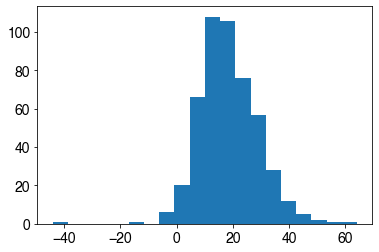

In [42]:
plt.hist(shModTrend_noYieldGrowth,bins=20)

(array([ 16.,   6.,  14.,  19.,  46.,  82., 132., 263., 640., 671.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

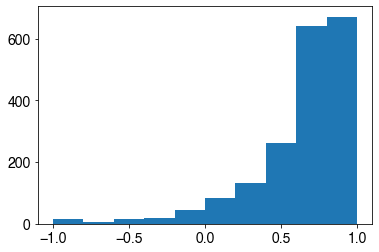

In [36]:
mc = []
for c in range(countySoybeanYield.shape[0]):
    nn = np.where((~np.isnan(countySoybeanYield[c,:])) & (~np.isnan(countyMaizeYield[c,:])))[0]
    mc.append(np.corrcoef(countySoybeanYield[c,nn], countyMaizeYield[c,nn])[0,1])
plt.hist(mc)

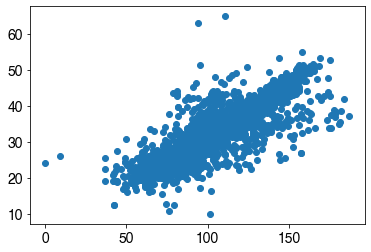

In [37]:
mmean = np.nanmean(countyMaizeYield,axis=1)
smean = np.nanmean(countySoybeanYield,axis=1)
plt.scatter(mmean,smean)

In [38]:
# calculate mean yield, kdd, gdd, and trends across all counties to use for percent corrections in maps below

haAllAc = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedArea']])
haAllFrac = np.array([np.nanmean(a) for a in usCounties['maizeHarvestedAreaFraction']])*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
kddTrendAll = np.array([a for a in usCounties['kddTrend']])*10
gddTrendAll = np.array([a for a in usCounties['gddTrend']])*10
prTrendAll = np.array([a for a in usCounties['seasonalPrecipTrend']])*10

meanSlhfAll = -np.array([a for a in usCounties['seasonalSlhf']])
meanKddAll = np.array([np.nanmean(a) for a in usCounties['kdd']])
meanGddAll = np.array([np.nanmean(a) for a in usCounties['gdd']])
countySeasonLenSec = np.array(list(curCountyList['seasonalSeconds']))

# convert slhf trend to w/m2/decade
slhfTrendAll = -np.array([a for a in usCounties['seasonalSlhfTrend']])
slhfTrendAll = [a*10/t for a,t in zip(slhfTrendAll, countySeasonLenSec)]

sshfTrendAll = -np.array([a for a in usCounties['seasonalSshfTrend']])
sshfTrendAll = [a*10/t for a,t in zip(sshfTrendAll, countySeasonLenSec)]

if useDeepak:
    yieldTrendAll = np.array([a for a in usCounties['maizeYieldTrendDeepak']])
    meanYieldAll = np.nanmean(np.array([a for a in usCounties['maizeYieldDeepak']]), axis=1)
    meanProdAll = meanYieldAll * haAllAc
else:
    maizeYieldTrendAll = np.array([a for a in usCounties['maizeYieldTrend']])*10
    maizeYieldAll = np.array([a for a in usCounties['maizeYield']])
    maizeYieldMeanAll = np.nanmean(np.array([a for a in usCounties['maizeYield']]), axis=1)
    
    soybeanYieldTrendAll = np.array([a for a in usCounties['soybeanYieldTrend']])*10
    soybeanYieldAll = np.array([a for a in usCounties['soybeanYield']])
    soybeanYieldMeanAll = np.nanmean(np.array([a for a in usCounties['soybeanYield']]), axis=1)
    
    countyMaizeHaAc = np.array([a for a in np.array(list(usCounties['maizeHarvestedArea']))])
    countySoybeanHaAc = np.array([a for a in np.array(list(usCounties['soybeanHarvestedArea']))])
    
    totalProdMeanAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldMeanAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldMeanAll, countySoybeanHaAc)])
#     totalProdTrendAll = np.array([x[0]*np.nanmean(x[1]) for x in zip(maizeYieldTrendAll, countyMaizeHaAc)]) + np.array([x[0]*np.nanmean(x[1]) for x in zip(soybeanYieldTrendAll, countySoybeanHaAc)])
    totalProdTrendAll = np.full(totalProdMeanAll.shape, np.nan)
    for c in range(totalProdMeanAll.size):
        p_maize = np.array([x[0]*x[1] for x in zip(maizeYieldAll[c,:], countyMaizeHaAc[c,:])])
        p_soybean = np.array([x[0]*x[1] for x in zip(soybeanYieldAll[c,:], countySoybeanHaAc[c,:])])
        nn_maize = np.where(~np.isnan(p_maize))[0]
        nn_soybean = np.where(~np.isnan(p_soybean))[0]
        if len(nn_maize) >= 10:
            X =  sm.add_constant(range(len(nn_maize)))
            mdl = sm.OLS(p_maize[nn_maize],X).fit()
            totalProdTrendAll[c] = mdl.params[1]
        if len(nn_soybean) >= 10:
            X =  sm.add_constant(range(len(nn_soybean)))
            mdl = sm.OLS(p_soybean[nn_soybean],X).fit()
            if np.isnan(totalProdTrendAll[c]):
                totalProdTrendAll[c] = mdl.params[1]
            else:
                totalProdTrendAll[c] += mdl.params[1]

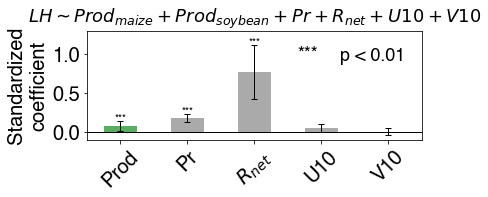

In [129]:
# this enables legends for text objects to show the significance markers
import string
from matplotlib.legend_handler import HandlerBase
from matplotlib.text import Text, Annotation
from matplotlib.legend import Legend
class TextHandlerA(HandlerBase):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize, trans):
        tx = Text(width/2.,height/2, artist.get_text(), fontsize=fontsize,
                  ha="center", va="center", fontweight="bold")
        return [tx]

Legend.update_default_handler_map({Text : TextHandlerA()})



width = .5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(6,2))
plt.xlim([.5,5.5])
plt.ylim([-.1,1.3])

l1_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'],10)
l2_TotalProd = np.nanpercentile(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'],90)
ind_TotalProd = np.where((mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']>l1_TotalProd) & (mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm']<l2_TotalProd))[0]

xvalues = [1,2,3,4,5]
yvalues = [np.nanmedian(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]), 
           np.nanmedian(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['U10_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_Coefs['V10_DetrendAnom_Norm'][ind_TotalProd])]
pvalues = [np.nanmedian(mdl_LH_Y_Norm_PValues['TotalProd_DetrendAnom_Norm'][ind_TotalProd]), 
           np.nanmedian(mdl_LH_Y_Norm_PValues['Pr_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_PValues['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_PValues['U10_DetrendAnom_Norm'][ind_TotalProd]),
           np.nanmedian(mdl_LH_Y_Norm_PValues['V10_DetrendAnom_Norm'][ind_TotalProd])]
yerrs = [np.nanstd(mdl_LH_Y_Norm_Coefs['TotalProd_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['Pr_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['NetRad_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['U10_DetrendAnom_Norm'][ind_TotalProd]),
         np.nanstd(mdl_LH_Y_Norm_Coefs['V10_DetrendAnom_Norm'][ind_TotalProd])]

facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 5.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3,4,5], rotation=45, fontsize=20)
plt.yticks([0, .5, 1], fontsize=20)
plt.gca().set_xticklabels(['Prod', 'Pr', '$R_{net}$', 'U10', 'V10'], fontsize=20)
plt.ylabel('Standardized\ncoefficient', fontsize=20)

plt.title('$LH \sim Prod_{maize} + Prod_{soybean} + Pr + R_{net} + U10 + V10$', fontsize=18)

i = 0
errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval < .01:
        if i == 0:
            t = plt.text(xpos, ypos, '***', ha='center', label='p < 0.01')
        else:
            plt.text(xpos, ypos, '***', ha='center')
    elif pval < .05:
        plt.text(xpos, ypos, '**', ha='center')
    elif pval < .1:
        plt.text(xpos, ypos, '*', ha='center')
    i += 1
    
leg = plt.legend([t], ['p < 0.01'], prop = {'size':18, 'family':'Helvetica'}, loc = 'upper right')
leg.get_frame().set_linewidth(0.0)
# plt.savefig('reg-coef-lh-yield-nass.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

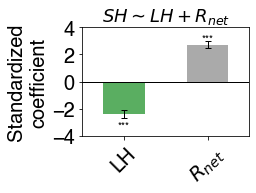

In [130]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([-4,4])

xvalues = [1,2]
yvalues = [np.nanmedian(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm']), 
           np.nanmedian(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'])]
pvalues = [np.nanmedian(mdl_LH_SH_Norm_PValues['SLHF_DetrendAnom_Norm']), 
           np.nanmedian(mdl_LH_SH_Norm_PValues['NetRad_DetrendAnom_Norm'])]
yerrs = [np.nanstd(mdl_LH_SH_Norm_Coefs['SLHF_DetrendAnom_Norm']),
         np.nanstd(mdl_LH_SH_Norm_Coefs['NetRad_DetrendAnom_Norm'])]
facecolors = [cmap(.8), '#aaaaaa', '#aaaaaa', '#aaaaaa', '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([1,2], rotation=45, fontsize=20)
plt.yticks([-4, -2, 0, 2, 4], fontsize=20)
plt.gca().set_xticklabels(['LH', '$R_{net}$'], fontsize=20)
plt.ylabel('Standardized\ncoefficient', fontsize=20)

plt.title('$SH \sim LH + R_{net}$', fontsize=18)

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.3
    
    if pval < .01:
        plt.text(xpos, ypos, '***', ha='center')
    elif pval < .05:
        plt.text(xpos, ypos, '**', ha='center')
    elif pval < .1:
        plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-lh-sh-nass.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

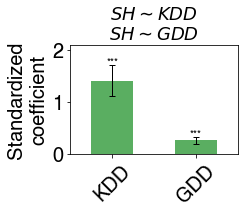

In [131]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(3,2))
plt.xlim([.5,2.5])
plt.ylim([0,2.1])

xvalues = [1,2]
yvalues = [np.nanmedian(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm']), 
           np.nanmedian(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'])]
pvalues = [np.nanmedian(mdl_SH_KDD_Norm_PValues['SSHF_DetrendAnom_Norm']), 
           np.nanmedian(mdl_SH_GDD_Norm_PValues['SSHF_DetrendAnom_Norm'])]
yerrs = [np.nanstd(mdl_SH_KDD_Norm_Coefs['SSHF_DetrendAnom_Norm']),
         np.nanstd(mdl_SH_GDD_Norm_Coefs['SSHF_DetrendAnom_Norm'])]
facecolors = [cmap(.8), cmap(.8)]
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 2.5], [0,0], '-k', lw=1)
plt.xticks([1,2], rotation=45, fontsize=20)
plt.yticks([0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD'], fontsize=20)
plt.ylabel('Standardized\ncoefficient', fontsize=20)

plt.title('$SH \sim KDD$\n$SH \sim GDD$', fontsize=18)

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.23
    
    if pval < .01:
        plt.text(xpos, ypos, '***', ha='center')
    elif pval < .05:
        plt.text(xpos, ypos, '**', ha='center')
    elif pval < .1:
        plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-sh-kdd-gdd-nass.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

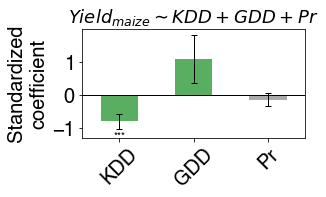

In [132]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.3,2])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm']), 
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm']),
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'])]
pvalues = [np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_PValues['KDD_DetrendNorm']), 
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_PValues['GDD_DetrendNorm']),
           np.nanmedian(mdl_KDD_GDD_MaizeYield_Norm_PValues['Pr_DetrendNorm'])]
yerrs = [np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['KDD_DetrendNorm']), 
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['GDD_DetrendNorm']),
         np.nanstd(mdl_KDD_GDD_MaizeYield_Norm_Coefs['Pr_DetrendNorm'])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('Standardized\ncoefficient', fontsize=20)

plt.title('$Yield_{maize} \sim KDD + GDD + Pr$', fontsize=18)

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.325
    
    if pval < .01:
        plt.text(xpos, ypos, '***', ha='center')
    elif pval < .05:
        plt.text(xpos, ypos, '**', ha='center')
    elif pval < .1:
        plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-yield-maize-kdd-gdd-pr-nass.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

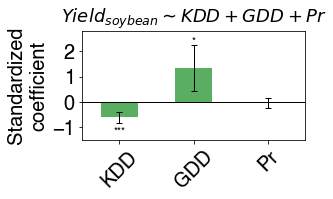

In [133]:
width=.5
cmap = plt.cm.get_cmap('PRGn')

plt.figure(figsize=(4,2))
plt.xlim([.5,3.5])
plt.ylim([-1.5,2.8])

xvalues = [1,2,3]
yvalues = [np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm']), 
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm']),
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'])]
pvalues = [np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_PValues['KDD_DetrendNorm']), 
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_PValues['GDD_DetrendNorm']),
           np.nanmedian(mdl_KDD_GDD_SoybeanYield_Norm_PValues['Pr_DetrendNorm'])]
yerrs = [np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['KDD_DetrendNorm']), 
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['GDD_DetrendNorm']),
         np.nanstd(mdl_KDD_GDD_SoybeanYield_Norm_Coefs['Pr_DetrendNorm'])]
facecolors = [cmap(.8), cmap(.8), '#aaaaaa']
b = plt.bar(xvalues, yvalues, width=width, yerr=yerrs, capsize=3, error_kw={'lw':1})
plt.plot([.5, 3.5], [0,0], '-k', lw=1)
plt.xticks([1,2,3], rotation=45, fontsize=20)
plt.yticks([-1, 0, 1, 2], fontsize=20)
plt.gca().set_xticklabels(['KDD', 'GDD', 'Pr'], fontsize=20)
plt.ylabel('Standardized\ncoefficient', fontsize=20)

plt.title('$Yield_{soybean} \sim KDD + GDD + Pr$', fontsize=18)

errBarLC = b.errorbar.lines[2][0]
for pat, errline, yval, pval, c in zip(b.patches, errBarLC.get_segments(), yvalues, pvalues, facecolors):
    pat.set_facecolor(c)
    
    xpos = errline[0][0]
    if yval >= 0:
        ypos = errline[1][1]
    else:
        ypos = errline[0][1]*1.55
    
    if pval < .01:
        plt.text(xpos, ypos, '***', ha='center')
    elif pval < .05:
        plt.text(xpos, ypos, '**', ha='center')
    elif pval < .1:
        plt.text(xpos, ypos, '*', ha='center')

# plt.savefig('reg-coef-soybean-yield-kdd-gdd-pr-nass.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

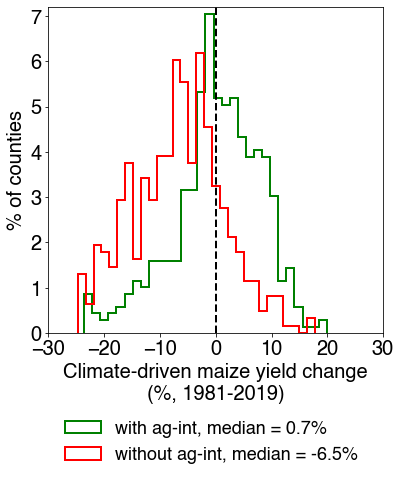

In [134]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt*NYears/10)/np.nanmean(countyMaizeYield, axis=1)*100))[0]
nnNoAgInt = np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt*NYears/10)/np.nanmean(countyMaizeYield, axis=1)*100))[0]

maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

maizeYieldChgAgInt = maizeYieldChgAgInt[abs(maizeYieldChgAgInt)<25]
maizeYieldChgNoAgInt = maizeYieldChgNoAgInt[abs(maizeYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
plt.ylim([0, 0.072])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(maizeYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(maizeYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(maizeYieldChgNoAgInt))

plt.plot([0,0], [0,0.072], '--k', lw=2)

plt.xlabel('Climate-driven maize yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=20)
plt.gca().set_yticklabels([0,1,2,3,4,5,6,7], fontsize=20)
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

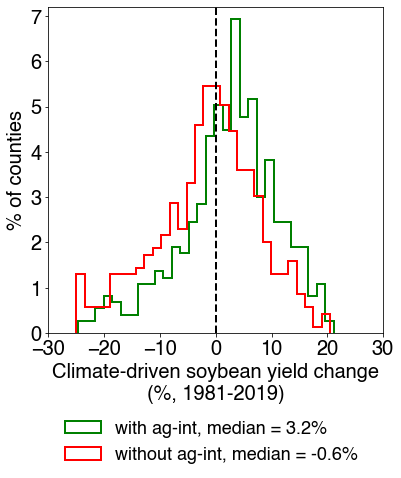

In [135]:
from scipy.stats import norm

# convert these trends back to changes over the time period
nnAgInt = np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt*NYears/10)/np.nanmean(countySoybeanYield, axis=1)*100))[0]
nnNoAgInt = np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt*NYears/10)/np.nanmean(countySoybeanYield, axis=1)*100))[0]

soybeanYieldChgAgInt = (soybeanYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

soybeanYieldChgAgInt = soybeanYieldChgAgInt[abs(soybeanYieldChgAgInt)<25]
soybeanYieldChgNoAgInt = soybeanYieldChgNoAgInt[abs(soybeanYieldChgNoAgInt)<25]

plt.figure(figsize=(6,6))

plt.xlim([-25, 25])
plt.ylim([0, 0.072])

histAgIntN, histAgIntBins, histAgIntPatches = plt.hist(soybeanYieldChgAgInt, bins=30, density=True, histtype='step', color='g', lw=2, \
                                                       label='with ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgAgInt))

histNoAgIntN, histNoAgIntBins, histNoAgIntPatches = plt.hist(soybeanYieldChgNoAgInt, bins=30, density=True, histtype='step', color='r', lw=2, \
                                                             label='without ag-int, median = %0.1f%%'%np.nanmedian(soybeanYieldChgNoAgInt))

plt.plot([0,0], [0,0.072], '--k', lw=2)

plt.xlabel('Climate-driven soybean yield change\n(%, 1981-2019)', fontsize=20)
plt.ylabel('% of counties', fontsize=20)
plt.yticks([0, .01, .02, .03, .04, .05, .06, .07], fontsize=20)
plt.gca().set_yticklabels([0,1,2,3,4,5,6,7], fontsize=20)
plt.xticks([-30, -20, -10, 0, 10, 20, 30], fontsize=20)

leg = plt.legend(prop = {'size':18, 'family':'Helvetica'}, loc = 'lower left', bbox_to_anchor=(0, -.45))
leg.get_frame().set_linewidth(0.0)

# if useDeepak:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('soybean-yield-chg-with-and-without-feedback-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

In [139]:
scipy.stats.ttest_1samp(soybeanYieldChgNoAgInt, 0)

Ttest_1sampResult(statistic=-3.3745294071594345, pvalue=0.0008022850484147014)

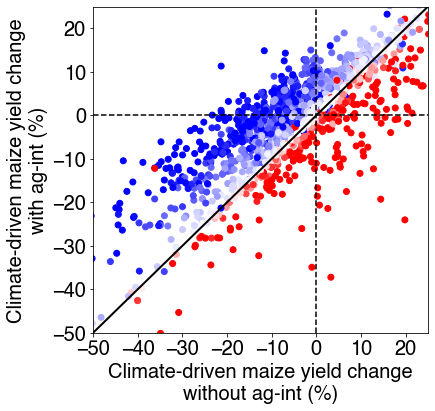

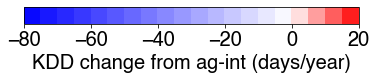

In [116]:
nnAgInt = np.where(~np.isnan((maizeYieldChgFeedbackWithAgInt*NYears/10)/np.nanmean(countyMaizeYield, axis=1)*100))[0]
nnNoAgInt = np.where(~np.isnan((maizeYieldChgFeedbackWithoutAgInt*NYears/10)/np.nanmean(countyMaizeYield, axis=1)*100))[0]


maizeYieldChgAgInt = (maizeYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnAgInt], axis=1)*100
maizeYieldChgNoAgInt = (maizeYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countyMaizeYield[nnNoAgInt], axis=1)*100

kddChg = (kddChgFeedbackWithAgInt[nnAgInt]*NYears/10)-(kddChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=20)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(maizeYieldChgNoAgInt, maizeYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.ylabel('Climate-driven maize yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven maize yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 21, 20), boundaries=np.arange(-80, 21, 5))
cbar.set_label('KDD change from ag-int (days/year)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

# if useDeepak:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
# else:
#     plt.savefig('maize-yield-chg-with-and-without-feedback-scatter-colorbar-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


In [86]:
print('maize sign reverse: %.2f'%(len(np.where((maizeYieldChgNoAgInt<0) & (maizeYieldChgAgInt>0))[0])/len(maizeYieldChgNoAgInt)))
print('soybean sign reverse: %.2f'%(len(np.where((soybeanYieldChgNoAgInt<0) & (soybeanYieldChgAgInt>0))[0])/len(soybeanYieldChgNoAgInt)))

maize sign reverse: 0.37
soybean sign reverse: 0.22


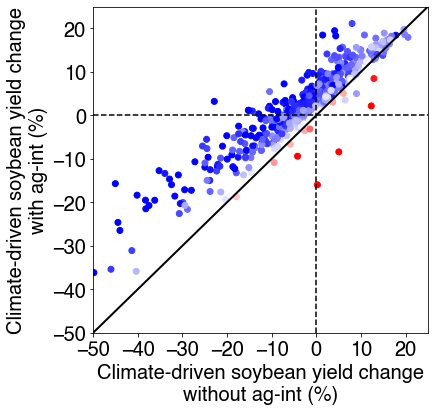

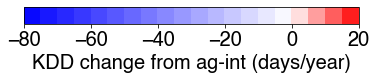

In [103]:

nnAgInt = np.where(~np.isnan((soybeanYieldChgFeedbackWithAgInt*NYears/10)/np.nanmean(countySoybeanYield, axis=1)*100))[0]
nnNoAgInt = np.where(~np.isnan((soybeanYieldChgFeedbackWithoutAgInt*NYears/10)/np.nanmean(countySoybeanYield, axis=1)*100))[0]


soybeanYieldChgAgInt = (soybeanYieldChgFeedbackWithAgInt[nnAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnAgInt], axis=1)*100
soybeanYieldChgNoAgInt = (soybeanYieldChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)/np.nanmean(countySoybeanYield[nnNoAgInt], axis=1)*100

kddChg = (kddChgFeedbackWithAgInt[nnAgInt]*NYears/10)-(kddChgFeedbackWithoutAgInt[nnNoAgInt]*NYears/10)

midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=20)

fig = plt.figure(figsize=(6,6))
plt.xlim([-50, 25])
plt.ylim([-50, 25])
a = plt.scatter(soybeanYieldChgNoAgInt, soybeanYieldChgAgInt, c=kddChg, cmap='bwr', norm=midnorm)
plt.plot([-50, 25], [0, 0], '--k', lw=1.5)
plt.plot([0, 0], [-50, 25], '--k', lw=1.5)
plt.plot([-50, 25], [-50, 25], '-k', lw=2)

plt.ylabel('Climate-driven soybean yield change\nwith ag-int (%)', fontsize=20)
plt.xlabel('Climate-driven soybean yield change\nwithout ag-int (%)', fontsize=20)
plt.yticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)
plt.xticks([-50, -40, -30, -20, -10, 0, 10, 20], fontsize=20)

if useDeepak:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
else:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)

fig = plt.figure()
plt.gca().set_visible(False)

cbar = fig.colorbar(a, ax=plt.gca(), orientation='horizontal', 
                    ticks=np.arange(-80, 21, 20), boundaries=np.arange(-80, 21, 5))
cbar.set_label('KDD change from ag-int (days/year)', fontsize=20)
cbar.ax.tick_params(labelsize=20)

if useDeepak:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-deepak.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)
else:
    plt.savefig('soybean-yield-chg-with-and-without-feedback-scatter-colorbar-nass.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0)


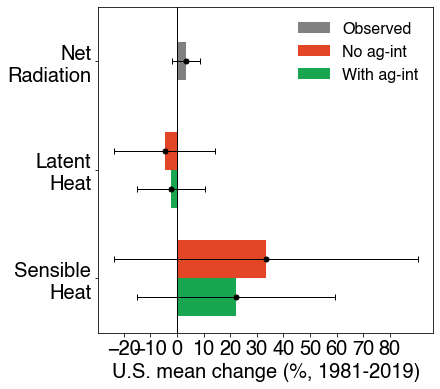

In [117]:
netRadChg = np.nanmean((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)
netRadErr = np.nanstd((netRadObsTrend[nnAgInt]*NYears/10)/np.nanmean(countyNetRad[nnAgInt, :], axis=1)*100)

lhChg = [np.nanmean(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100, \
         np.nanmean(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1))*100]
lhErr = [np.nanstd(lhChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100), \
         np.nanstd(lhChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

lhObsChg = [np.nanmean((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]
lhObsErr = [np.nanstd((lhObsTrend[nnAgInt]*NYears/10)/np.nanmean(countySlhf[nnAgInt,:], axis=1)*100)]

shChg = [np.nanmean(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100, \
         np.nanmean(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1))*100]
shErr = [np.nanstd(shChgFeedbackWithoutAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100), \
         np.nanstd(shChgFeedbackWithAgInt[nnAgInt]*NYears/10/np.nanmean(countySshf[nnAgInt,:], axis=1)*100)]


labels = ['Net\nRadiation', 'Latent\nHeat', 'Sensible\nHeat']

x = [1,2,3]
width = .35
plt.figure(figsize=(6,6))
plt.ylim([.5, 3.5])

plt.barh([1], netRadChg, height=width, xerr=netRadErr, capsize=3, error_kw={'lw':1}, facecolor='gray', label='Observed')
plt.plot(netRadChg, [1], 'ok', markersize=5)

plt.barh([2-width/2], lhChg[0], height=width, xerr=lhErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627', label='No ag-int')
plt.plot(lhChg[0], [2-width/2], 'ok', markersize=5)
plt.barh([2+width/2], lhChg[1], height=width, xerr=lhErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651', label='With ag-int')
plt.plot(lhChg[1], [2+width/2], 'ok', markersize=5)

plt.barh([3-width/2], shChg[0], height=width, xerr=shErr[0], capsize=3, error_kw={'lw':1}, facecolor='#e34627')
plt.plot(shChg[0], [3-width/2], 'ok', markersize=5)
plt.barh([3+width/2], shChg[1], height=width, xerr=shErr[1], capsize=3, error_kw={'lw':1}, facecolor='#19a651')
plt.plot(shChg[1], [3+width/2], 'ok', markersize=5)

plt.plot([0, 0], [.5, 3.5], '-k', lw=1)

plt.gca().set_yticks(x)
plt.gca().set_yticklabels(labels, fontsize=20)

plt.xlabel('U.S. mean change (%, 1981-2019)', fontsize=20)
plt.xticks(range(-20, 81, 10), fontsize=20)

plt.gca().invert_yaxis()  # labels read top-to-bottom

l1 = plt.legend(prop = {'size':16, 'family':'Helvetica'}, loc='upper right')
l1.get_frame().set_linewidth(0)


In [203]:
scipy.stats.ks_2samp(maizeYieldChgAgInt, maizeYieldChgNoAgInt)

Ks_2sampResult(statistic=0.2905833526939405, pvalue=0.0)

In [118]:
# calculate the fraction of yield trend explained by feedback over upper midwest to compare with Butler et al PNAS 
# (but only the 'climate' component, not changes to growing season length)

print('fraction of trend from ag-int in upper midwest')
inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('maize: %.2f%%'%np.nanmean(maizeYieldTrendFrac[inds]))

inds = []
for si, s in enumerate(stateSel):
    if s in ['IA', 'MN', 'SD', 'NE', 'WI', 'IL', 'IN', 'MI', 'OH', 'KY', 'MO']:
        inds.append(si)
inds = np.array(inds)
print('soybean: %.2f%%'%np.nanmean(soybeanYieldTrendFrac[inds]))

fraction of trend from ag-int in upper midwest
maize: 10.43%
soybean: 7.33%


In [119]:
# and the fraction explained over all maize-growing counties
np.nanmean(maizeYieldTrendFrac)

-10.836570346408932

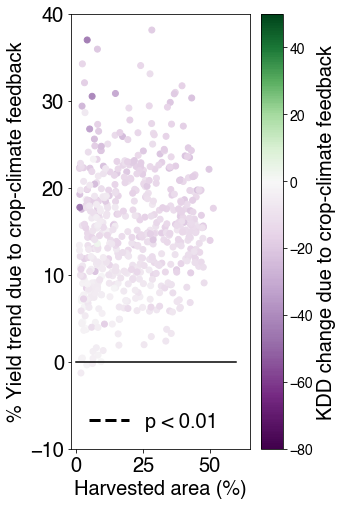

In [63]:
midnorm = MidpointNormalize(vmin=-80, vcenter=0, vmax=50)

plt.figure(figsize=(4,8))
a = plt.scatter(haSel, yieldTrendFrac, c=kddFromFeedback, cmap=cmap, norm=midnorm)
plt.plot([x1, x2], [mdlHa.params[0]+x1*mdlHa.params[1], mdlHa.params[0]+x2*mdlHa.params[1]], '--k', lw=3, label='p < 0.01')
plt.plot([0, 60], [0, 0], '-k')
plt.xlabel('Harvested area (%)', fontsize=20)
plt.ylabel('% Yield trend due to crop-climate feedback', fontsize=20)
plt.xticks([0, 25, 50])
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)
plt.xlim([-2, 65])
plt.ylim([-10, 40])
cbar = plt.colorbar(a)#ticks=np.linspace(0,1,9))
cbar.set_label('KDD change due to crop-climate feedback', fontsize=20)
# cbar.ax.set_yticklabels(np.arange(-80,81,20))
l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

# plt.savefig('yield-trend-due-to-lh-flux-ha.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

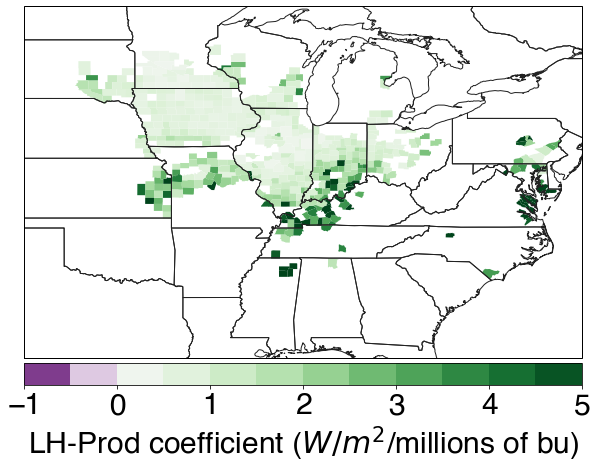

In [53]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 5.1
vcenter = 0
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_LH_Y_Coefs['TotalProd_DetrendAnom'][ind[0]]*2.264e6/countySeasonLenSec[ind[0]]*1e6
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Prod coefficient ($W/m^2$/millions of bu)', fontsize=mapFontSize)
plt.savefig('coef-lh-yield.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

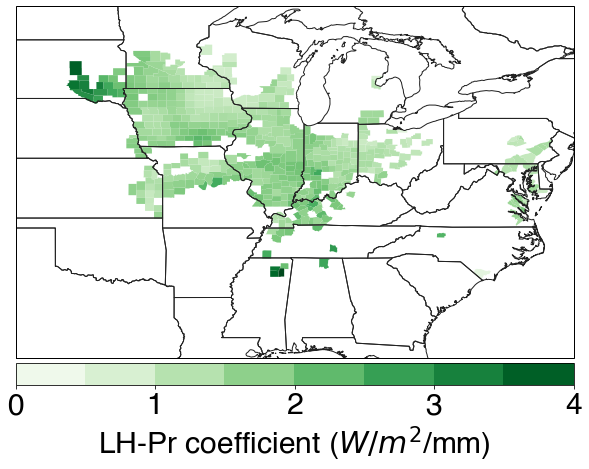

In [52]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 4.1
vcenter = (v1+v2)/2
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_LH_Y_Coefs['Pr_DetrendAnom'][ind[0]]*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-Pr coefficient ($W/m^2$/mm)', fontsize=mapFontSize)
plt.savefig('coef-lh-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

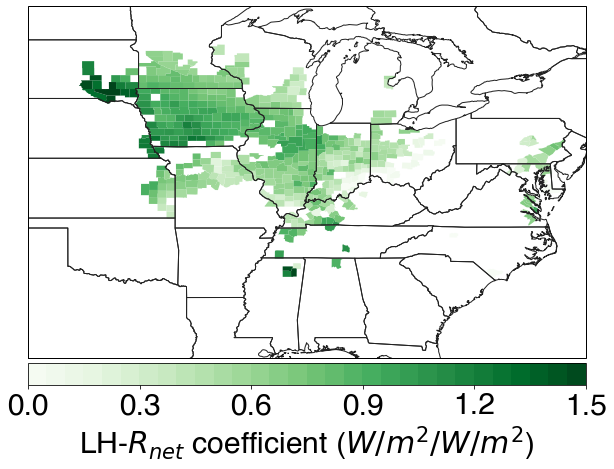

In [56]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 1.51
vcenter = (v1+v2)/2
vstep = .05
vlabelstep = .3

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_LH_Y_Coefs['NetRad_DetrendAnom'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-$R_{net}$ coefficient ($W/m^2/W/m^2$)', fontsize=mapFontSize)
plt.savefig('coef-lh-rnet.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

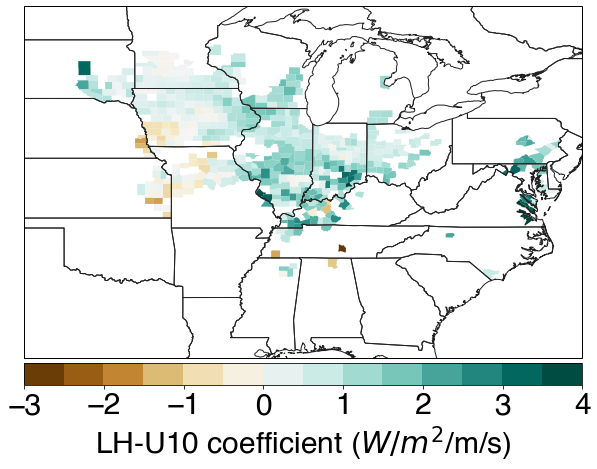

In [67]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -3
v2 = 4.1
vcenter = 0
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_LH_Y_Coefs['U10_DetrendAnom'][ind[0]]*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-U10 coefficient ($W/m^2$/m/s)', fontsize=mapFontSize)
plt.savefig('coef-lh-u10.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

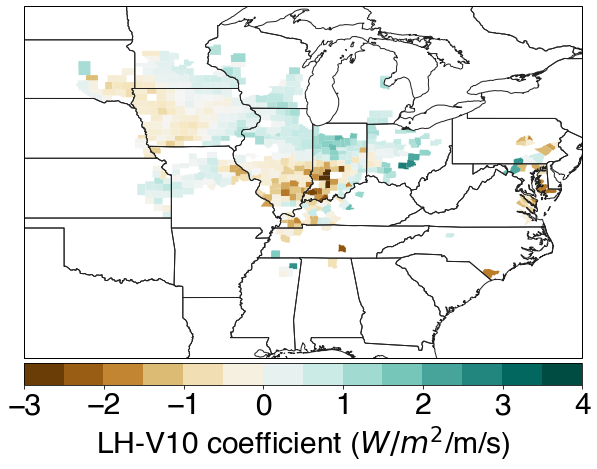

In [66]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -3
v2 = 4.1
vcenter = 0
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_LH_Y_Coefs['V10_DetrendAnom'][ind[0]]*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH-V10 coefficient ($W/m^2$/m/s)', fontsize=mapFontSize)
plt.savefig('coef-lh-v10.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

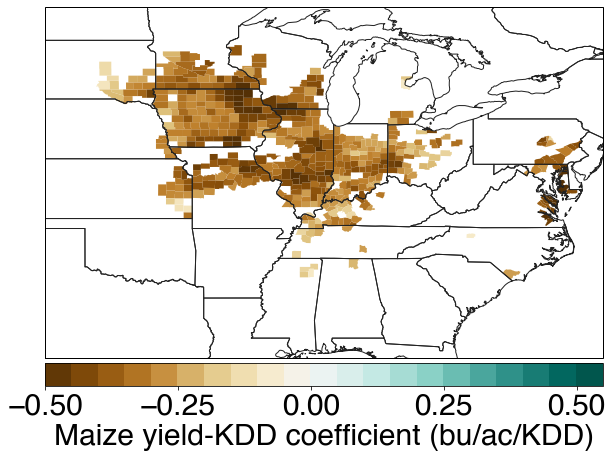

In [86]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = .6
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

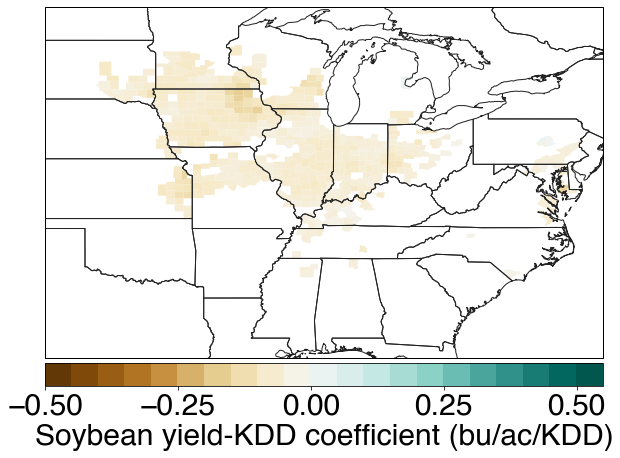

In [87]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.5
v2 = .6
vstep = .05
vlabelstep = .25

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['KDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-KDD coefficient (bu/ac/KDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-kdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

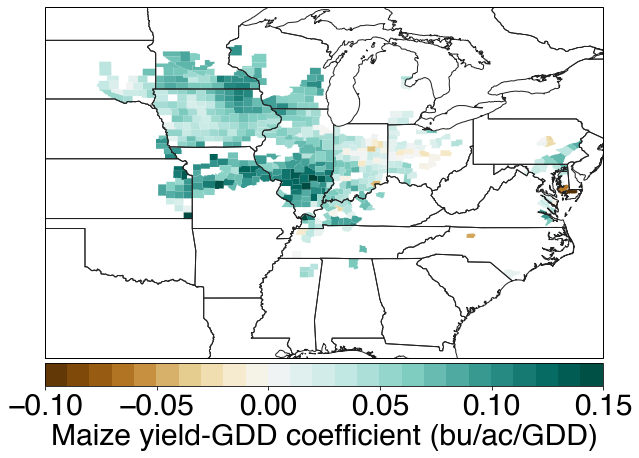

In [75]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.1
v2 = .16
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
# plt.savefig('coef-maize-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

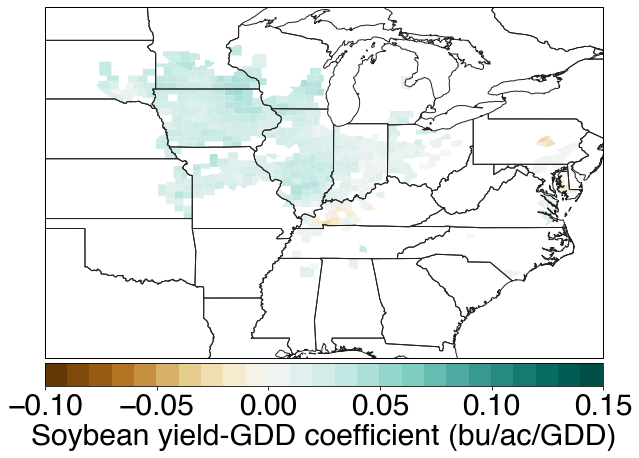

In [89]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -.1
v2 = .16
vstep = .01
vlabelstep = .05

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_KDD_GDD_SoybeanYield_Coefs['GDD_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield-GDD coefficient (bu/ac/GDD)', fontsize=mapFontSize)
plt.savefig('coef-soybean-yield-gdd.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

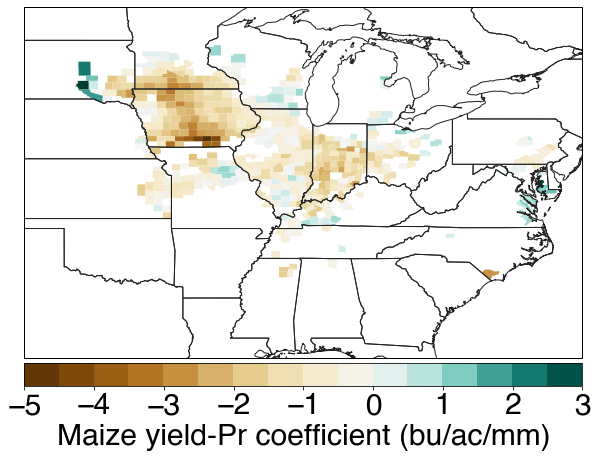

In [80]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -5
v2 = 3.1
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = mdl_KDD_GDD_MaizeYield_Coefs['Pr_Detrend'][ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield-Pr coefficient (bu/ac/mm)', fontsize=mapFontSize)
plt.savefig('coef-maize-yield-pr.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

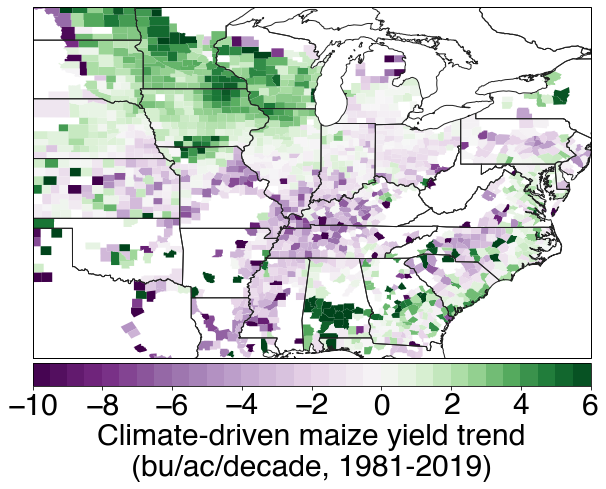

In [121]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = .5
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = maizeYieldChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-maize-yield-change-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

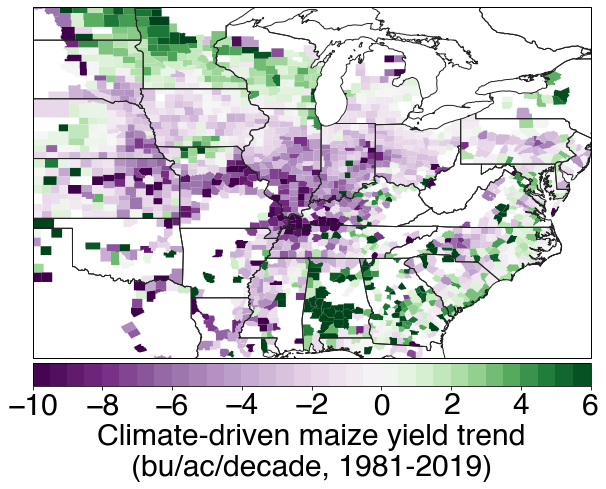

In [122]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -10
    v2 = 6.1
    vstep = .5
    vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]/meanYieldAll[ind[0]]*100
        else:
            curVal = maizeYieldChgFeedbackWithoutAgInt[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# plt.xlabel('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)

#     cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
         boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
         pad=0.01, aspect=25, shrink=1)

cb.ax.tick_params(labelsize=mapFontSize)

if showPct:
#     cb.set_label('Climate-driven yield change with warming and no ag-int (% 1981-2019)', fontsize=mapFontSize)
    cb.set_label('Climate-driven maize yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Climate-driven maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-maize-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

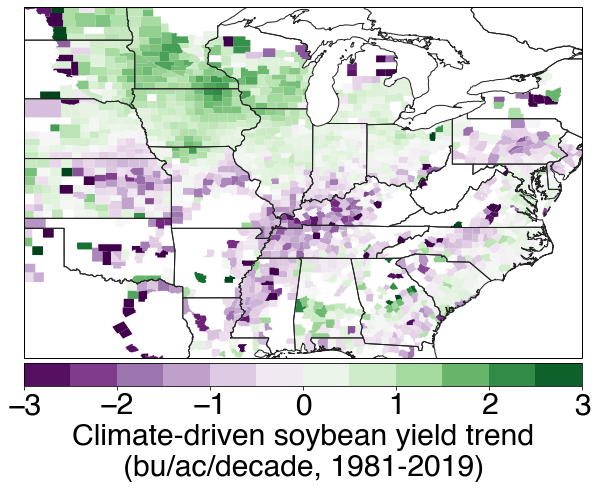

In [123]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = soybeanYieldChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Climate-driven soybean yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-soybean-yield-change-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

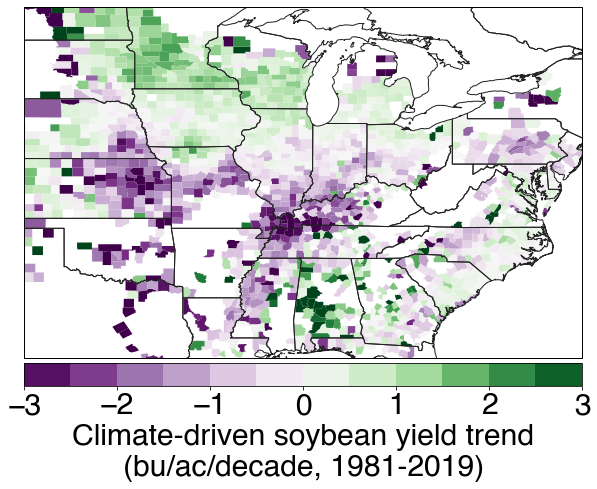

In [124]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -40
    v2 = 21
    vstep = 1
    vlabelstep = 10
else:
    v1 = -3
    v2 = 3.1
    vstep = .5
    vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = soybeanYieldChgFeedbackWithoutAgInt[ind[0]]/soybeanMeanYieldAll[ind[0]]*100
        else:
            curVal = soybeanYieldChgFeedbackWithoutAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('Climate-driven soybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('Climate-driven soybean yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('climate-driven-soybean-yield-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

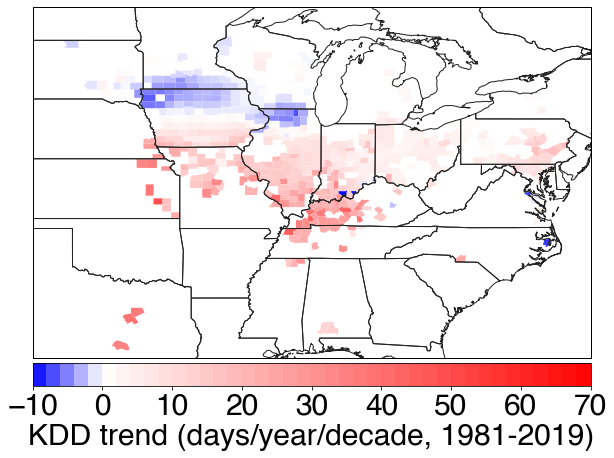

In [58]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 71
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = kddChgFeedbackWithAgInt[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Observed, with ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('kdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

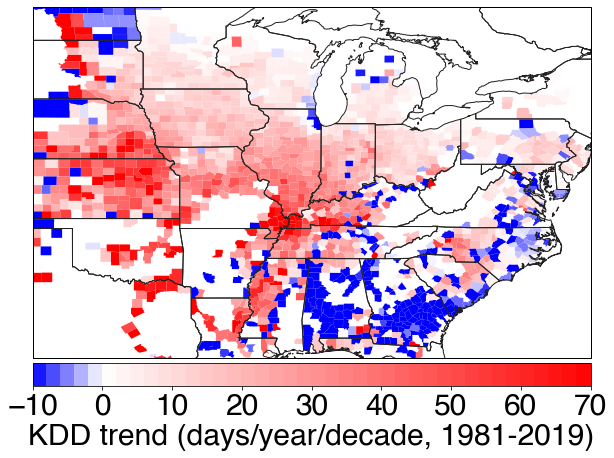

In [125]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 71
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = kddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Estimated, without ag-int', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('kdd-change-no-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

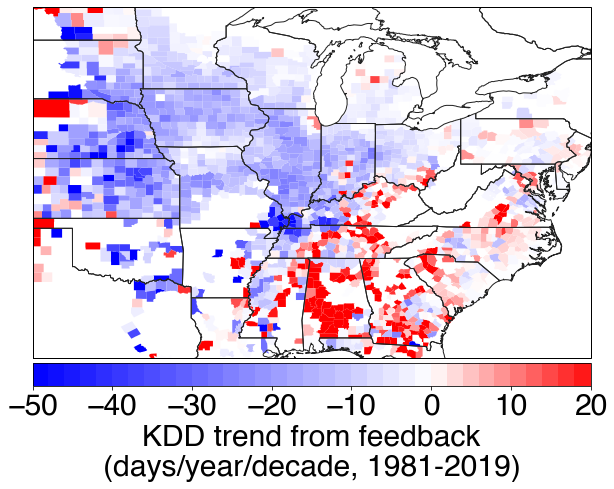

In [126]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -50
    v2 = 11
    vcenter = 0
    vstep = 2
    vlabelstep = 10
else:
    v1 = -50
    v2 = 21
    vcenter = 0
    vstep = 2
    vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = kddFromFeedback[ind[0]]/meanKddAll[ind[0]]*100
        else:
            curVal = kddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('KDD trend from feedback\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('KDD trend from feedback\n(days/year/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('kdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

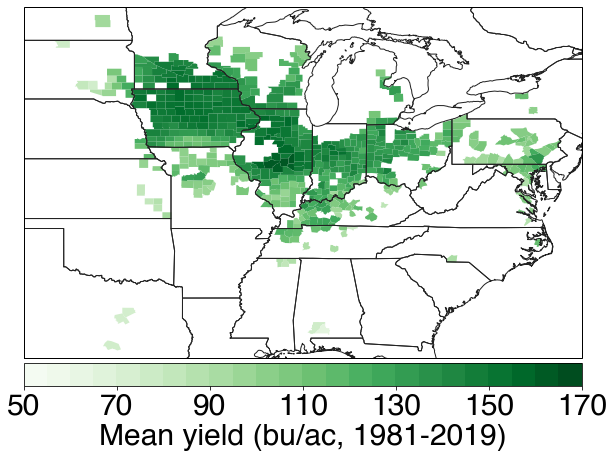

In [172]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 50
v2 = 171
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = meanYieldAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

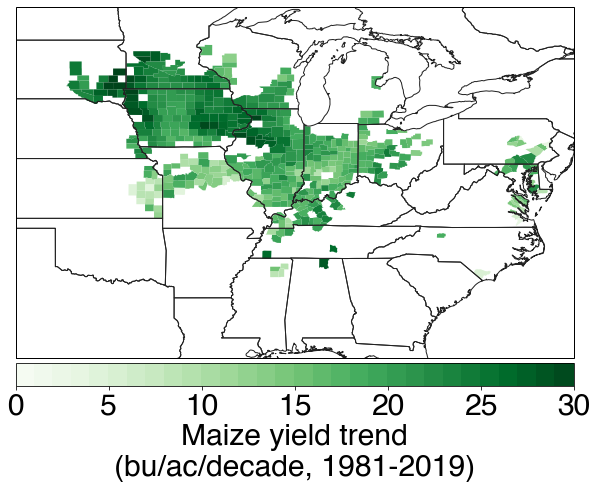

In [100]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 30.1
vcenter = (v1+v2)/2
vstep = 1
vlabelstep = 5
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = maizeYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

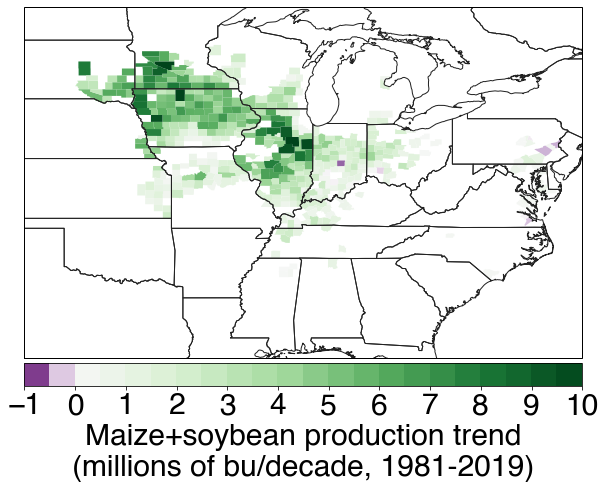

In [169]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 10.1
vcenter = 0
vstep = .5
vlabelstep = 1
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdTrendAll[ind[0]]*10/1e6
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize+soybean production trend\n(millions of bu/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-trend-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

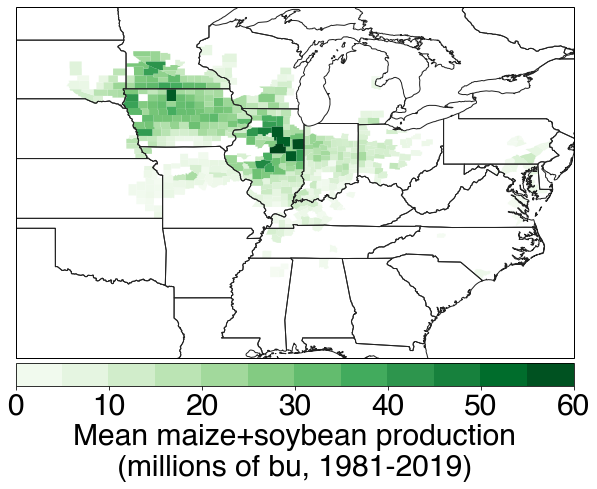

In [170]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 60.1
vcenter = (v1+v2)/2
vstep = 5
vlabelstep = 10
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = totalProdMeanAll[ind[0]]/1e6
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean maize+soybean production\n(millions of bu, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-prod-maize-soy-1981-2019.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

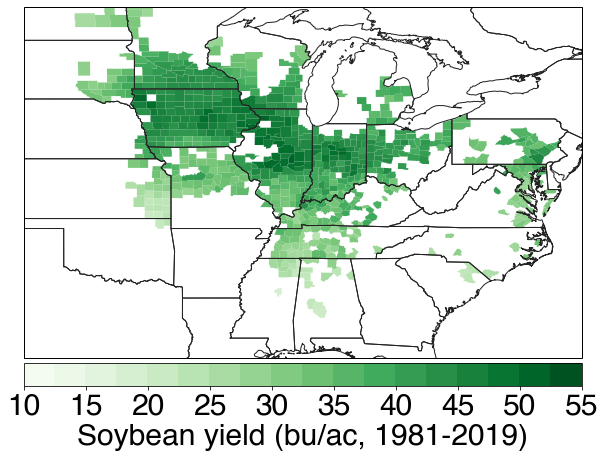

In [76]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 10
v2 = 56
vcenter = (v1+v2)/2
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        # convert bu/ac to kg/ac
        curVal = soybeanYieldMeanAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield (bu/ac, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('us-mean-yield-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

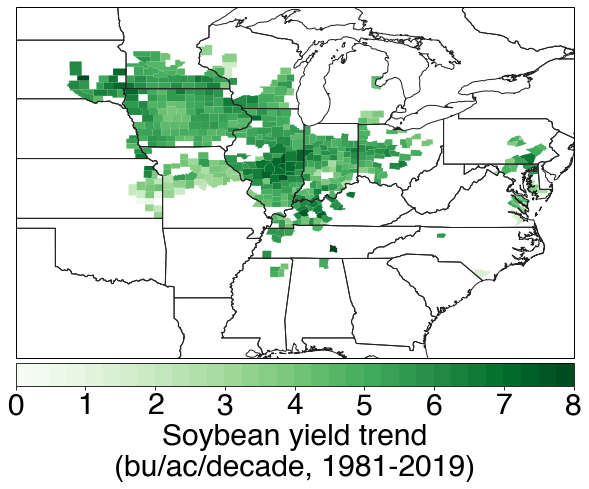

In [39]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 8.1
vcenter = (v1+v2)/2
vstep = .25
vlabelstep = 1
midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Greens')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        
        curVal = soybeanYieldTrendAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield trend\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

(array([  3.,  13.,  35., 150., 703., 757.,  58.,  15.,   4.,   4.]),
 array([-13.72727273, -10.08121212,  -6.43515152,  -2.78909091,
          0.8569697 ,   4.5030303 ,   8.14909091,  11.79515152,
         15.44121212,  19.08727273,  22.73333333]),
 <a list of 10 Patch objects>)

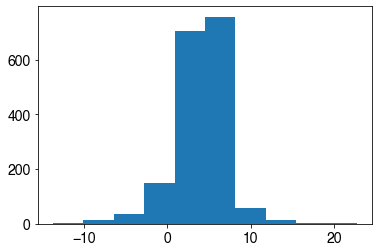

In [93]:
plt.hist(soybeanYieldTrendAll)

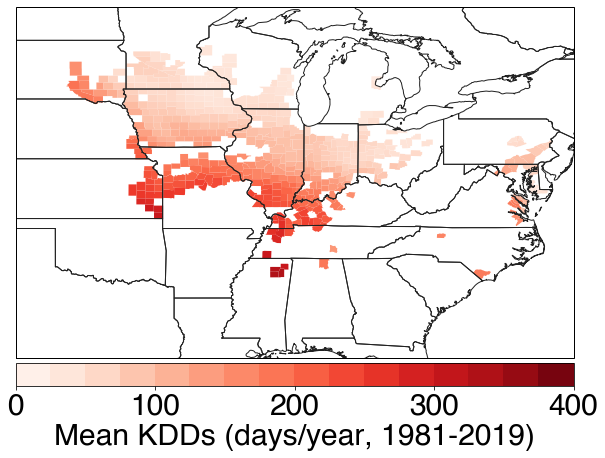

In [171]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 0
v2 = 401
vcenter = (v1+v2)/2
vstep = 25
vlabelstep = 100

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = meanKddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean KDDs (days/year, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-kdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

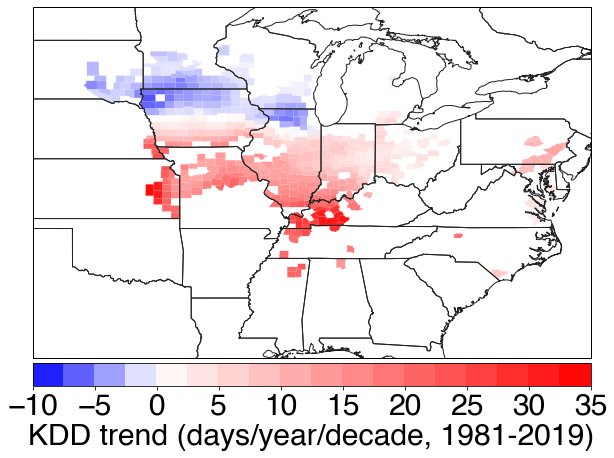

In [172]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])

v1 = -10
v2 = 35.1
vcenter = 0
vstep = 2.5
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = kddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))

ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
    # ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('KDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('kdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

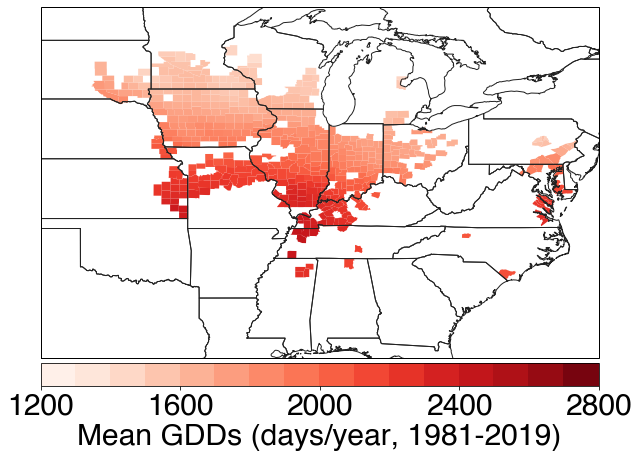

In [173]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 1200
v2 = 2801
vcenter = (v1+v2)/2
vstep = 100
vlabelstep = 400

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = meanGddAll[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Mean GDDs (days/year, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-mean-gdd-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

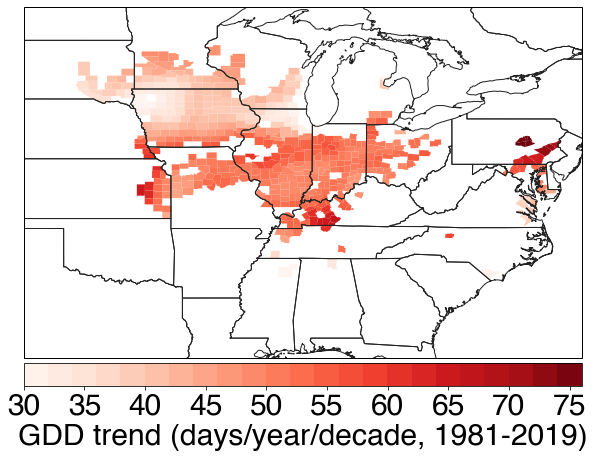

In [174]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = 30
v2 = 77
vcenter = (v1+v2)/2
vstep = 2
vlabelstep = 5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('Reds')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = gddTrendAll[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='gray', facecolor='white'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-trend-maize-1981-2019.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

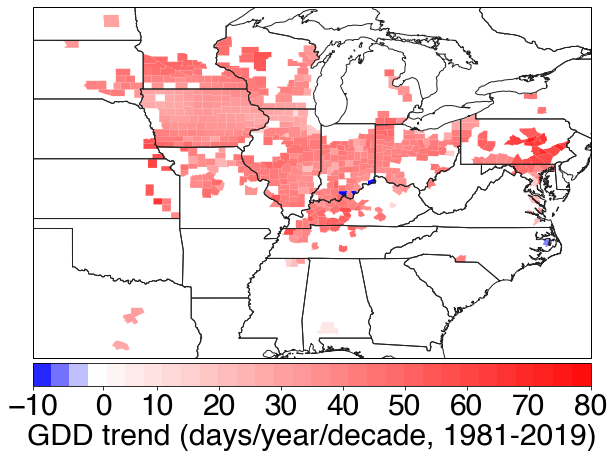

In [178]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -10
    v2 = 83
    vstep = 3
    vlabelstep = 10

vcenter = 0

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = gddChgFeedbackWithAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithAgInt[ind[0]]
#         curVal = gddFromFeedback[ind[0]]
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('With historical agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-ag-int.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

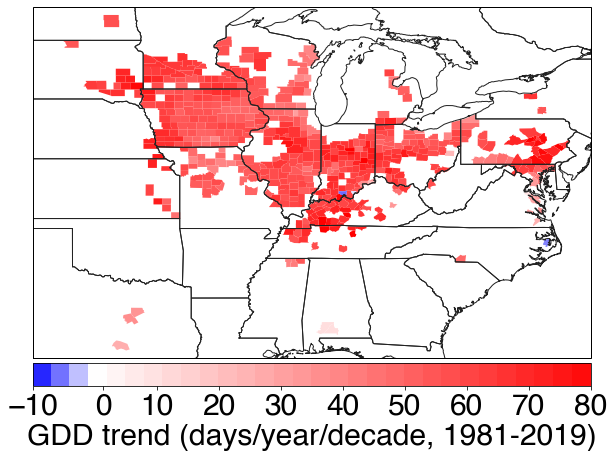

In [179]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -10
    v2 = 11
    vstep = 2
else:
    v1 = -10
    v2 = 83
    vstep = 3
    vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=0, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddChgFeedbackWithoutAgInt[ind[0]]
        
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
# ax.set_title('No agricultural intensification', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('GDD trend (days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-change-no-ag-int.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

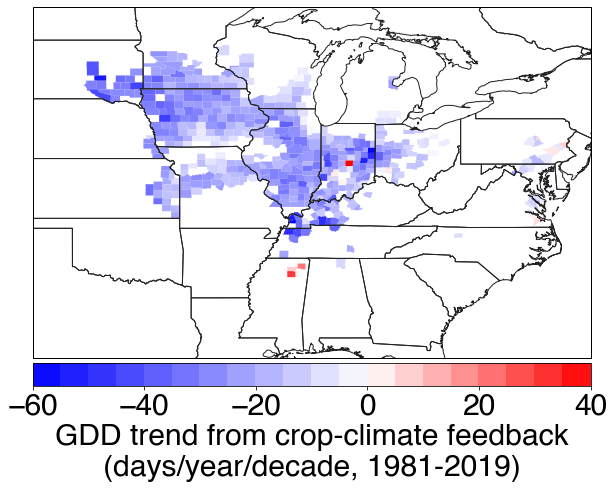

In [176]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

showPct = False

if showPct:
    v1 = -4
    v2 = 1.1
    vcenter = 0
    vstep = .25
    vlabelstep=1
else:
    v1 = -60
    v2 = 40.1
    vcenter = 0
    vstep = 5
    vlabelstep=20

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        if showPct:
            curVal = gddFromFeedback[ind[0]]/meanGddAll[ind[0]]*100
        else:
            curVal = gddFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
if showPct:
    cb.set_label('GDD trend from feedback\n(%/decade, 1981-2019)', fontsize=mapFontSize)
else:
    cb.set_label('GDD trend from crop-climate feedback\n(days/year/decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('gdd-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

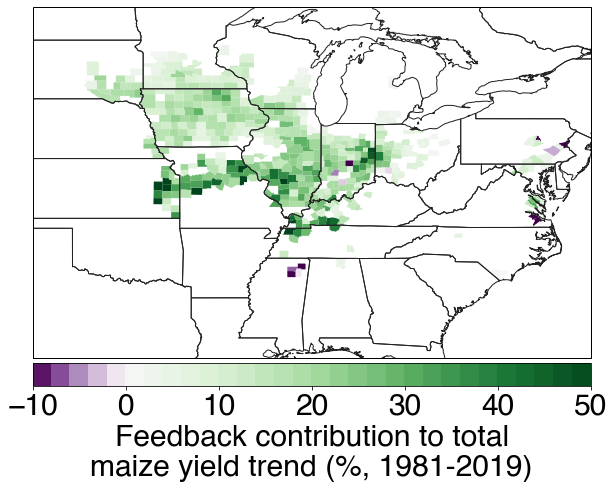

In [82]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curYieldTrendFrac = maizeYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nmaize yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-maize-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [88]:
np.nanmean(maizeYieldTrendFrac)

17.15484601454845

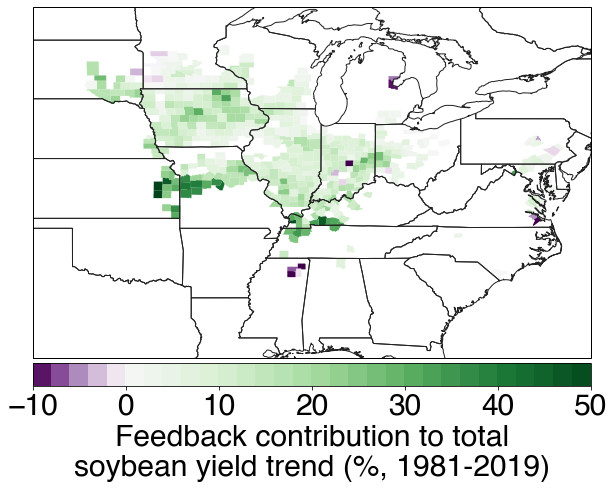

In [83]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -10
v2 = 51
vcenter = 0
vstep = 2
vlabelstep = 10

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curYieldTrendFrac = soybeanYieldTrendFrac[ind[0]]
        if not np.isnan(curYieldTrendFrac) and abs(curYieldTrendFrac) <= 100:
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curYieldTrendFrac))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Feedback contribution to total\nsoybean yield trend (%, 1981-2019)', fontsize=mapFontSize)
plt.savefig('us-soybean-yield-trend-frac-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [87]:
np.nanmean(soybeanYieldTrendFrac)

12.899306662809542

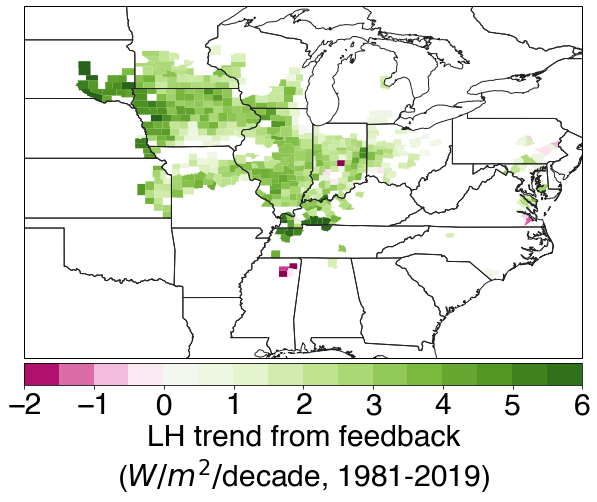

In [181]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -2
v2 = 6.1
vcenter = 0
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = lhFromFeedback[ind[0]]*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('LH trend from feedback\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('lh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

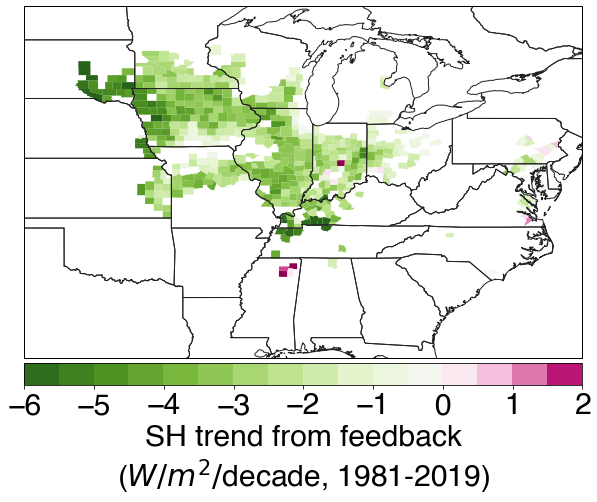

In [182]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -6
v2 = 2.1
vcenter = 0
vstep = .5
vlabelstep = 1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PiYG_r')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        # convert from /ac to /m2
        curVal = shFromFeedback[ind[0]]*2.264e6/countySeasonLenSec[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('SH trend from feedback\n($W/m^2/$decade, 1981-2019)', fontsize=mapFontSize)
plt.savefig('sh-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

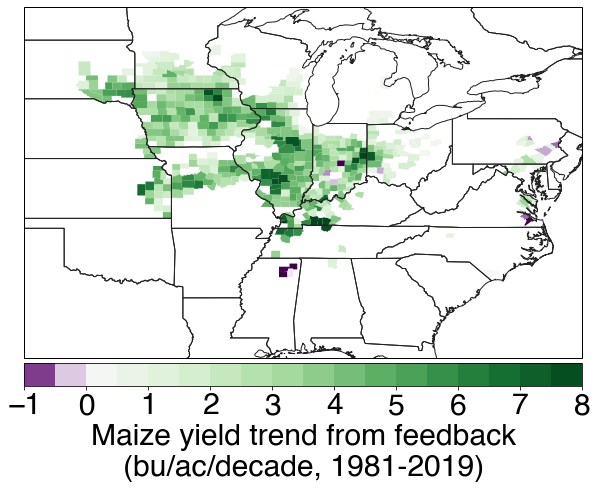

In [52]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 8.1
vcenter = 0
vstep = .5
vlabelstep=1

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = maizeYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Maize yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('maize-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

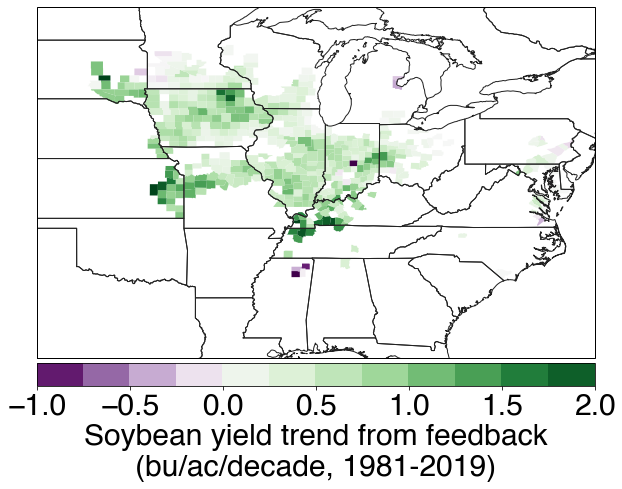

In [51]:
mapFontSize=30

countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([258, 286, 30, 47])
# plt.figure(figsize=(18,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([258, 289, 26, 47])
# ax.set_extent([235, 294, 25, 46])

v1 = -1
v2 = 2.1
vcenter = 0
vstep = .25
vlabelstep=.5

midnorm = MidpointNormalize(vmin=v1, vcenter=vcenter, vmax=v2)

cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(fipsSel == curFips)[0]
    if len(ind) > 0:
        curVal = soybeanYieldFromFeedback[ind[0]]
            
        if not np.isnan(curVal):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='#cccccc', lw=0, facecolor=cmap(midnorm(curVal))))
            continue
    
#     ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
# ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
# cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
#              boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
#              pad=0.01, aspect=20, shrink=0.644)
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Soybean yield trend from feedback\n(bu/ac/decade, 1981-2019)', fontsize=mapFontSize)
# plt.savefig('soybean-yield-chg-from-feedback.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [181]:
curCountyList = countyList.copy()

paMeanAggAll = np.nanmean(np.array([a for a in usCounties['maizePlantedAreaFraction']]), axis=1)*100
irAggAll = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])

irThresh1 = 0
irThresh2 = 100
paThresh1 = 0
paThresh2 = 100
paIrInds = np.where((irAggAll >= irThresh1) & (irAggAll < irThresh2) & (paMeanAggAll >= paThresh1) & (paMeanAggAll < paThresh2))[0]


countyYieldDetrend = np.array(list(curCountyList['maizeYieldDetrendPlusMeanDeepak']))[paIrInds,:] * 1000/10000
countyYieldAnom = np.array(list(curCountyList['maizeYieldDetrendDeepak']))[paIrInds,:] * 1000/10000
countyPa = np.array([a for a in np.array(list(usCounties['maizePlantedAreaFraction']))[paIrInds,:]])*100
countyIr = np.array(list(usCounties['maizeCountyIrrigationFraction']))[paIrInds]
countyState = np.array(list(usCounties['STATE']))[paIrInds]
countyFips = np.array(list(usCounties['FIPS']))[paIrInds]

countyPr = np.array(list(curCountyList['seasonalPrecip']))[paIrInds,:]
countyKdd = np.array(list(curCountyList['kdd']))[paIrInds,:]
countyGdd = np.array(list(curCountyList['gdd']))[paIrInds,:]
countySlhf = -np.array(list(curCountyList['seasonalSlhf']))[paIrInds,:]/2.5e6
countySshf = -np.array(list(curCountyList['seasonalSshf']))[paIrInds,:]/2.5e6
countySsr = np.array(list(curCountyList['seasonalSsr']))[paIrInds,:]/2.5e6
countyStr = np.array(list(curCountyList['seasonalStr']))[paIrInds,:]/2.5e6
countyNetRad = (countySsr+countyStr)

countyU10 = np.array(list(curCountyList['seasonalU10']))[paIrInds,:]
countyV10 = np.array(list(curCountyList['seasonalV10']))[paIrInds,:]

lhTrendFrac = []
shTrendFrac = []
kddTrendFrac = []
gddTrendFrac = []
yieldTrendFrac = []

fipsSel = []
paSel = []
irSel = []
stateSel = []

for i in range(len(paIrInds)):
    
    curYieldAreaAdjDetrend = countyYieldDetrend[i,:] * countyPa[i,:]/100
    curYieldDetrend = countyYieldDetrend[i,:]
    curYieldAreaAdjAnom = countyYieldAnom[i,:] * countyPa[i,:]/100
    curYieldAnom = countyYieldAnom[i,:]
    
    curYieldTestTrend = countyYieldDetrend[i,:].copy()
    curYieldTestTrend += np.array([0.01*k for k in range(len(curYieldTestTrend))])
    
    curKdd = countyKdd[i,:]
    curGdd = countyGdd[i,:]
    curSshf = countySshf[i,:]
    curSlhf = countySlhf[i,:]
    curSsr = countySsr[i,:]
    curStr = countyStr[i,:]
    curU10 = countyU10[i,:]
    curV10 = countyV10[i,:]
    curPr = countyPr[i,:]

    nn = np.where((~np.isnan(curKdd)) & (~np.isnan(curPr)) & \
                  (~np.isnan(curYieldTestTrend)) & (~np.isnan(curYieldAnom)) & (~np.isnan(curSshf)) & (~np.isnan(curSlhf)))[0]

    stateSel.append(countyState[i])
    if len(nn) < 5:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        gddTrendFrac.append(np.nan)
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    curKdd = curKdd[nn]
    curGdd = curGdd[nn]
    curSshf = curSshf[nn]
    curSlhf = curSlhf[nn]
    curSsr = curSsr[nn]
    curStr = curStr[nn]
    curU10 = curU10[nn]
    curV10 = curV10[nn]
    curPr = curPr[nn]
    curYieldAnom = curYieldAnom[nn]
    curYieldAreaAdjDetrend = curYieldAreaAdjDetrend[nn]
    curYieldDetrend = curYieldDetrend[nn]
    curYieldAreaAdjAnom = curYieldAreaAdjAnom[nn]
    curYieldTestTrend = curYieldTestTrend[nn]

    data = {'KDD_Anom':curKdd-np.nanmean(curKdd), \
            'GDD_Anom':curGdd-np.nanmean(curGdd), \
            'SSHF_Anom':curSshf-np.nanmean(curSshf), \
            'SLHF_Anom':curSlhf-np.nanmean(curSlhf), \
            'U10_Anom':curU10-np.nanmean(curU10), \
            'V10_Anom':curV10-np.nanmean(curV10), \
            'Pr_Anom':curPr-np.nanmean(curPr), \
            'NetRad_Anom':(curSsr+curStr)-np.nanmean(curSsr+curStr), \
            'YieldAreaAdj_Detrend':curYieldAreaAdjDetrend, \
            'Yield_Detrend':curYieldDetrend, \
            'YieldAreaAdj_Anom':curYieldAreaAdjAnom, \
            'Yield_Anom':curYieldAnom, \
            'Yield_TestTrend':curYieldTestTrend}

    df = pd.DataFrame(data, \
                      columns=['KDD_Anom', 'GDD_Anom', 'SLHF_Anom', 'SSHF_Anom', 'NetRad_Anom', 'Pr_Anom', 'U10_Anom', 'V10_Anom', \
                               'Yield_TestTrend', 'Yield_Detrend', 'YieldAreaAdj_Anom', 'YieldAreaAdj_Detrend', 'Yield_Anom'])

    mdl_LH_Y = smf.ols(formula='SLHF_Anom ~ Yield_Anom + Pr_Anom + NetRad_Anom + U10_Anom + V10_Anom', data=df).fit()
    
    if mdl_LH_Y.pvalues['Yield_Anom'] > 0.05:
        lhTrendFrac.append(np.nan)
        shTrendFrac.append(np.nan)
        kddTrendFrac.append(np.nan)
        gddTrendFrac.append(np.nan)
        yieldTrendFrac.append(np.nan)
        paSel.append(np.nan)
        irSel.append(np.nan)
        fipsSel.append(np.nan)
        continue
    
    mdl_LH_SH = smf.ols(formula='SSHF_Anom ~ SLHF_Anom', data=df).fit()
    mdl_SH_KDD = smf.ols(formula='KDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_SH_GDD = smf.ols(formula='GDD_Anom ~ SSHF_Anom', data=df).fit()
    mdl_KDD_GDD_PR_Yield = smf.ols(formula='Yield_Anom ~ GDD_Anom + KDD_Anom + Pr_Anom', data=df).fit()

    X = {'Yield_Anom':data['Yield_TestTrend'] - np.nanmean(data['Yield_TestTrend']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Trend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)

    X = {'Yield_Anom':data['Yield_Detrend'] - np.nanmean(data['Yield_TestTrend']), 
         'Pr_Anom':data['Pr_Anom'], 
         'NetRad_Anom':data['NetRad_Anom'],
         'U10_Anom':data['U10_Anom'],
         'V10_Anom':data['V10_Anom']}
    lhMod_Detrend = mdl_LH_Y.predict(X).values + np.nanmean(curSlhf)
    
    
    X = {'SLHF_Anom':lhMod_Trend-np.nanmean(lhMod_Trend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Trend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SLHF_Anom':lhMod_Detrend-np.nanmean(lhMod_Detrend), \
         'NetRad_Anom':data['NetRad_Anom']}
    shMod_Detrend = mdl_LH_SH.predict(X).values + np.nanmean(curSshf)
    
    X = {'SSHF_Anom':shMod_Trend-np.nanmean(shMod_Trend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Trend = mdl_SH_KDD.predict(X).values + np.nanmean(curKdd)
    kddMod_Trend[kddMod_Trend<0] = 0
    gddMod_Trend = mdl_SH_GDD.predict(X).values + np.nanmean(curGdd)
    gddMod_Trend[gddMod_Trend<0] = 0
    
    X = {'SSHF_Anom':shMod_Detrend-np.nanmean(shMod_Detrend), 
         'NetRad_Anom':data['NetRad_Anom']}
    kddMod_Detrend = mdl_SH_KDD.predict(X).values+np.nanmean(curKdd)
    kddMod_Detrend[kddMod_Detrend<0] = 0
    gddMod_Detrend = mdl_SH_GDD.predict(X).values+np.nanmean(curGdd)
    gddMod_Detrend[gddMod_Detrend<0] = 0
    
    
    X = {'GDD_Anom':gddMod_Trend-np.nanmean(gddMod_Trend), 
         'KDD_Anom':kddMod_Trend-np.nanmean(kddMod_Trend), 
         'Pr_Anom':data['Pr_Anom']}
    yieldMod_Trend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    X = {'GDD_Anom':gddMod_Detrend-np.nanmean(gddMod_Detrend), 
         'KDD_Anom':kddMod_Detrend-np.nanmean(kddMod_Detrend), 
         'Pr_Anom':data['Pr_Anom']}
    yieldMod_Detrend = mdl_KDD_GDD_PR_Yield.predict(X).values+np.nanmean(curYield)
    
    
    N = 10
    shTrendFrac.append(((np.nanmean(shMod_Trend[-N:])-np.nanmean(shMod_Trend[0:N])) - \
                     (np.nanmean(shMod_Detrend[-N:])-np.nanmean(shMod_Detrend[0:N])))/ \
                     (np.nanmean(curSshf[-N:])-np.nanmean(curSshf[0:N]))*100)
    
    lhTrendFrac.append(((np.nanmean(lhMod_Trend[-N:])-np.nanmean(lhMod_Trend[0:N])) - \
                     (np.nanmean(lhMod_Detrend[-N:])-np.nanmean(lhMod_Detrend[0:N])))/ \
                     (np.nanmean(curSlhf[-N:])-np.nanmean(curSlhf[0:N]))*100)
    
    kddTrendFrac.append(((np.nanmean(kddMod_Trend[-N:])-np.nanmean(kddMod_Trend[0:N])) - \
                     (np.nanmean(kddMod_Detrend[-N:])-np.nanmean(kddMod_Detrend[0:N])))/ \
                     (np.nanmean(curKdd[-N:])-np.nanmean(curKdd[0:N]))*100)
    
    gddTrendFrac.append(((np.nanmean(gddMod_Trend[-N:])-np.nanmean(gddMod_Trend[0:N])) - \
                     (np.nanmean(gddMod_Detrend[-N:])-np.nanmean(gddMod_Detrend[0:N])))/ \
                     (np.nanmean(curGdd[-N:])-np.nanmean(curGdd[0:N]))*100)
    
    yieldTrendFrac.append(((np.nanmean(yieldMod_Trend[-N:])-np.nanmean(yieldMod_Trend[0:N])) - \
                     (np.nanmean(yieldMod_Detrend[-N:])-np.nanmean(yieldMod_Detrend[0:N])))/ \
                     (np.nanmean(curYield[-N:])-np.nanmean(curYield[0:N]))*100)
    
    paSel.append(np.nanmean(countyPa[i,:]))
    irSel.append(countyIr[i])
    fipsSel.append(countyFips[i])
    
fipsSel = np.array(fipsSel)
paSel = np.array(paSel)
irSel = np.array(irSel)
lhTrendFrac = np.array(lhTrendFrac)
shTrendFrac = np.array(shTrendFrac)
kddTrendFrac = np.array(kddTrendFrac)
gddTrendFrac = np.array(gddTrendFrac)
yieldTrendFrac = np.array(yieldTrendFrac)

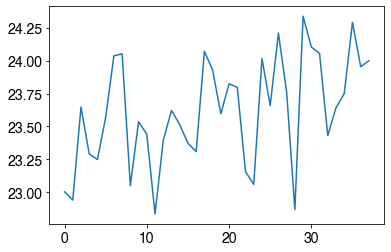

In [182]:
plt.plot(np.nanmean(countyNetRad,axis=0))

In [183]:
np.nanmean(yieldTrendFrac)

13.391634681983858

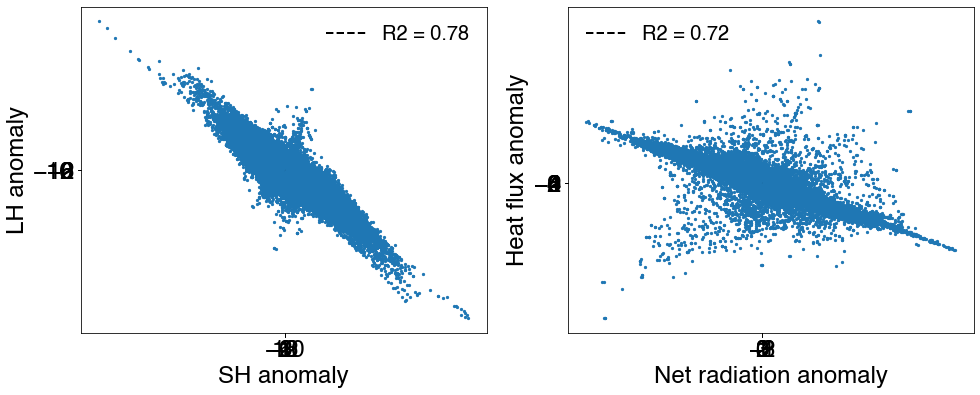

In [184]:
X = sm.add_constant(sshfAnomAgg)
mdl = sm.OLS(slhfAnomAgg, X).fit()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.scatter(-sshfAnomAgg, -slhfAnomAgg, s=5)
ax1.plot([-10,10], [10, -10], '--k', lw=2, label='R2 = %.2f'%(mdl.rsquared))
ax1.set_xlabel('SH anomaly', fontsize=24)
ax1.set_ylabel('LH anomaly', fontsize=24)
ax1.set_xticks(np.arange(-10, 11, 4))
ax1.set_yticks(np.arange(-10, 11, 4))
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)
leg = ax1.legend(prop = {'size':20, 'family':'Helvetica'})
leg.get_frame().set_linewidth(0)

X = sm.add_constant(-(ssrAnomAgg+strAnomAgg))
mdl = sm.OLS(-(sshfAnomAgg+slhfAnomAgg), X).fit()

ax2.scatter(-(ssrAnomAgg+strAnomAgg), -(sshfAnomAgg+slhfAnomAgg), s=5)
ax2.plot([-2.5,2.5], [2.5, -2.5], '--k', lw=2, label='R2 = %.2f'%(mdl.rsquared))
ax2.set_xlabel('Net radiation anomaly', fontsize=24)
ax2.set_ylabel('Heat flux anomaly', fontsize=24)
ax2.set_xticks(np.arange(-3, 4, 1))
ax2.set_yticks(np.arange(-6, 7, 2))
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)
leg = ax2.legend(prop = {'size':20, 'family':'Helvetica'})
leg.get_frame().set_linewidth(0)

plt.savefig('sh-vs-lh-us-counties.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = .1)

In [185]:
curCountyList = countyList.copy()

pa = np.array([a for a in usCounties['maizePlantedAreaFraction']])
ir = np.array([a for a in usCounties['maizeCountyIrrigationFraction']])
pa = np.nanmean(pa,axis=1)*100
yieldVar = np.array([np.nanstd(x) for x in np.array(list(curCountyList['maizeYieldDetrendNorm']))])

irThresh = 0
paThresh = 0

paIrInds = np.where((ir>irThresh) & (pa>paThresh))[0]

kddTrendAgg = np.array([x for x in np.array(list(curCountyList['kddTrend']))[paIrInds]])
gddTrendAgg = np.array([x for x in np.array(list(curCountyList['gddTrend']))[paIrInds]])
prTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalPrecipTrend']))[paIrInds]])
sshfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSshfTrend']))[paIrInds]])
slhfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSlhfTrend']))[paIrInds]])
yieldTrendAgg = np.array([x for x in np.array(list(curCountyList['maizeYieldTrendDeepak']))[paIrInds]])
countyFE = np.array([c for c in paIrInds])


yieldTrendAgg *= 1000 / 10000
for i,p in enumerate(paIrInds):
    yieldTrendAgg[i] *= pa[p]/100
    
# convert from J/m2/growing season to mm/m2/growing season
sshfTrendAgg /= (2.5e6)
slhfTrendAgg /= (2.5e6)

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(gddTrendAgg)) & (~np.isnan(prTrendAgg)) & \
              (~np.isnan(sshfTrendAgg)) & (~np.isnan(slhfTrendAgg)) & (~np.isnan(yieldTrendAgg)))[0]

kddTrendAgg = kddTrendAgg[nn]
gddTrendAgg = gddTrendAgg[nn]
sshfTrendAgg = sshfTrendAgg[nn]
slhfTrendAgg = slhfTrendAgg[nn]
prTrendAgg = prTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]
countyFE = countyFE[nn]

data = {'KDD':kddTrendAgg, \
        'GDD':gddTrendAgg, \
        'SSHF':-sshfTrendAgg, \
        'SLHF':-slhfTrendAgg, \
        'HF_TOT':-(sshfTrendAgg+slhfTrendAgg), \
        'Pr':prTrendAgg, \
        'Yield':yieldTrendAgg, \
        'CountyFE':countyFE}

df = pd.DataFrame(data, \
                  columns=['KDD', 'GDD', 'SLHF', 'SSHF', 'HF_TOT', 'Pr', \
                           'Yield', 'CountyFE'])
mdl1 = smf.ols(formula='SLHF ~ Yield+Pr', data=df).fit()
mdl1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   SLHF   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     864.5
Date:                Wed, 10 Jun 2020   Prob (F-statistic):          6.51e-279
Time:                        12:20:36   Log-Likelihood:                 4669.7
No. Observations:                2241   AIC:                            -9333.
Df Residuals:                    2238   BIC:                            -9316.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0005      0.001     -0.573      0.566      -0.002       0.001
Yield          4.8579      0.392     12.402      0.000       4.090       5.626
Pr             0.4233      0.011     39.624      0.000       0.402       0.444
==============================================================================
Omnibus:                      267.282   Durbin-Watson:                   0.839
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              379.672
Skew:                          -0.902   Prob(JB):                     3.59e-83
Kurtosis:                       3.901   Cond. No.                         615.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

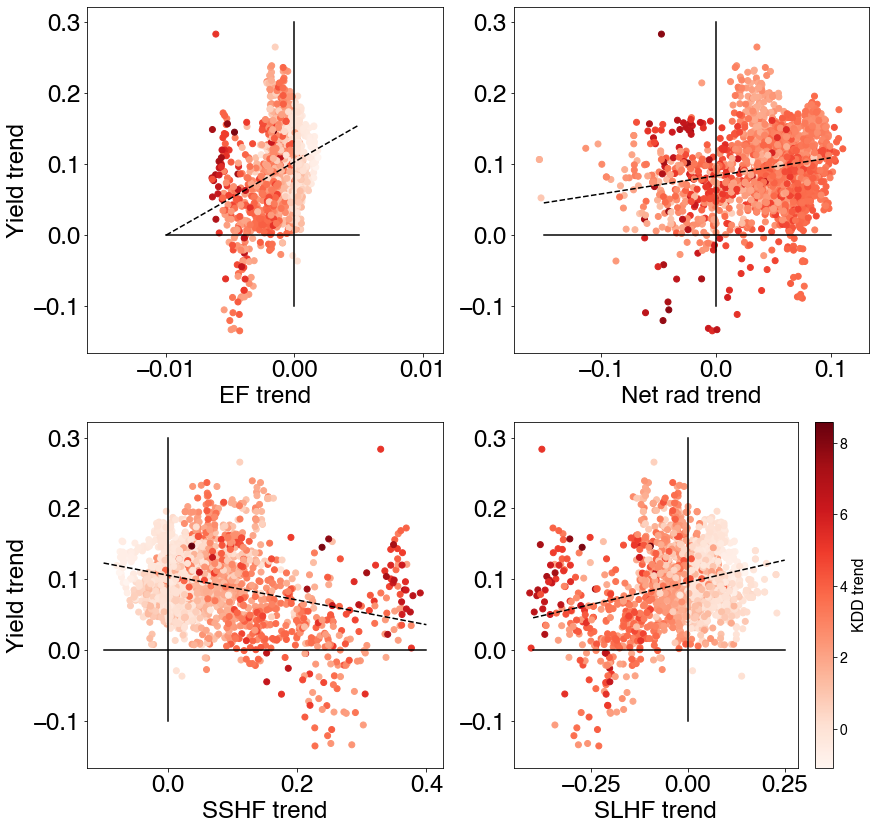

In [186]:
curCountyList = countyList.copy()
# curCountyList = curCountyList[curCountyList['STATE']=='MN']

kddTrendAgg = np.array([x for x in np.array(list(curCountyList['kddTrend']))])
gddTrendAgg = np.array([x for x in np.array(list(curCountyList['gddTrend']))])
prTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalPrecipTrend']))])
sshfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSshfTrend']))])
slhfTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSlhfTrend']))])
efTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalEfTrend']))])
ssrTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalSsrTrend']))])
strTrendAgg = np.array([x for x in np.array(list(curCountyList['seasonalStrTrend']))])
yieldTrendAgg = np.array([x for x in np.array(list(curCountyList['maizeYieldTrendDeepak']))])


# yieldTrendAgg *= 1000 / 10000
# for i,p in enumerate(paIrInds):
#     yieldTrendAgg[i] *= pa[p]/100
    
# convert from J/m2/growing season to mm/m2/growing season
sshfTrendAgg /= -1e6
slhfTrendAgg /= -1e6
ssrTrendAgg /= 1e6
strTrendAgg /= 1e6

nn = np.where((~np.isnan(kddTrendAgg)) & (~np.isnan(gddTrendAgg)) & (~np.isnan(prTrendAgg)) & \
              (~np.isnan(sshfTrendAgg)) & (~np.isnan(slhfTrendAgg)) & (~np.isnan(efTrendAgg)) & (~np.isnan(yieldTrendAgg)))[0]

kddTrendAgg = kddTrendAgg[nn]
gddTrendAgg = gddTrendAgg[nn]
sshfTrendAgg = sshfTrendAgg[nn]
slhfTrendAgg = slhfTrendAgg[nn]
efTrendAgg = efTrendAgg[nn]
ssrTrendAgg = ssrTrendAgg[nn]
strTrendAgg = strTrendAgg[nn]
netRadTrendAgg = ssrTrendAgg+strTrendAgg
prTrendAgg = prTrendAgg[nn]
yieldTrendAgg = yieldTrendAgg[nn]


# plt.figure()
# plt.scatter(netRadTrendAgg, slhfTrendAgg+sshfTrendAgg, s=30, c=kddTrendAgg, cmap='Reds')
# plt.plot([-.15, .15], [-.15, .15], '--k')
# plt.xlim([-.15, .15])
# plt.ylim([-.15, .2])
# plt.xlabel('Net radiation trend')
# plt.ylabel('Net heat flux trend')
# cbar = plt.colorbar()
# cbar.set_label('KDD trend')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(14,14))


X = sm.add_constant(efTrendAgg)
mdlEf = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.01
x2 = .005
ax1.scatter(efTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax1.plot([0,0], [-.1, .3], 'k')
ax1.plot([x1, x2], [0, 0], 'k')
ax1.plot([x1, x2], [mdlEf.params[0]+x1*mdlEf.params[1], mdlEf.params[0]+x2*mdlEf.params[1]], '--k')
ax1.set_xlabel('EF trend', fontsize=24)
ax1.set_ylabel('Yield trend', fontsize=24)
ax1.tick_params(axis='x', labelsize=24)
ax1.tick_params(axis='y', labelsize=24)


X = sm.add_constant(netRadTrendAgg)
mdlRad = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.15
x2 = .1
ax2.scatter(netRadTrendAgg, yieldTrendAgg, c=gddTrendAgg, cmap='Reds')
ax2.plot([0,0], [-.1, .3], '-k')
ax2.plot([x1, x2], [0, 0], '-k')
ax2.plot([x1, x2], [mdlRad.params[0]+x1*mdlRad.params[1], mdlRad.params[0]+x2*mdlRad.params[1]], '--k')
ax2.set_xlabel('Net rad trend', fontsize=24)
# ax2.set_ylabel('Yield trend', fontsize=24)
ax2.tick_params(axis='x', labelsize=24)
ax2.tick_params(axis='y', labelsize=24)


X = sm.add_constant(sshfTrendAgg)
mdlSH = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.1
x2 = .4
ax3.scatter(sshfTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax3.plot([0,0], [-.1, .3], '-k')
ax3.plot([-.1, .4], [0, 0], '-k')
ax3.plot([x1, x2], [mdlSH.params[0]+x1*mdlSH.params[1], mdlSH.params[0]+x2*mdlSH.params[1]], '--k')
ax3.set_xlabel('SSHF trend', fontsize=24)
ax3.set_ylabel('Yield trend', fontsize=24)
ax3.tick_params(axis='x', labelsize=24)
ax3.tick_params(axis='y', labelsize=24)


X = sm.add_constant(slhfTrendAgg)
mdlLH = sm.OLS(yieldTrendAgg, X).fit()
x1 = -.4
x2 = .25
a=ax4.scatter(slhfTrendAgg, yieldTrendAgg, c=kddTrendAgg, cmap='Reds')
ax4.plot([0,0], [-.1, .3], '-k')
ax4.plot([-.4, .25], [0, 0], '-k')
ax4.plot([x1, x2], [mdlLH.params[0]+x1*mdlLH.params[1], mdlLH.params[0]+x2*mdlLH.params[1]], '--k')
ax4.set_xlabel('SLHF trend', fontsize=24)
# ax4.set_ylabel('Yield trend', fontsize=24)
ax4.tick_params(axis='x', labelsize=24)
ax4.tick_params(axis='y', labelsize=24)
cbar = fig.colorbar(a,ax=ax4)
cbar.set_label('KDD trend')

# plt.savefig('yield-rad-ef-trends.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = .1)

# mdlLH.summary()


In [187]:
gddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
evapAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalEvapDetrend']))])))
yieldAnomAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrend']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))
    

data = {'GDD':gddAnomAgg, \
        'KDD':kddAnomAgg, \
        'Pr':prAnomAgg, 'Pr2':prAnomAgg**2, \
        'County':countyFE, \
        'Yield':yieldAnomAgg}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
yieldMdlNass = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
yieldMdlNass.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     6462.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:20:37   Log-Likelihood:            -2.7705e+05
No. Observations:               64484   AIC:                         5.541e+05
Df Residuals:                   64480   BIC:                         5.542e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0854      0.070     -1.219      0.223      -0.223       0.052
GDD            0.0235      0.001     28.178      0.000       0.022       0.025
KDD           -0.1670      0.002   -109.473      0.000      -0.170      -0.164
Pr            -0.2803      0.023    -12.343      0.000      -0.325      -0.236
==============================================================================
Omnibus:                     5333.863   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11436.034
Skew:                          -0.540   Prob(JB):                         0.00
Kurtosis:                       4.758   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [188]:
gddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['gddDetrend']))])))
kddAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['kddDetrend']))])))
prAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['seasonalPrecipDetrend']))])))
yieldAnomAggDeepak = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(countyList['maizeYieldDetrendDeepak']))])))
countyFE = np.array(list(itertools.chain.from_iterable([[c]*(yearRange[1]-yearRange[0]+1) for c in range(len(list(countyList['maizeYieldDetrend'])))])))

nn = np.where((~np.isnan(gddAnomAggDeepak)) & (~np.isnan(kddAnomAggDeepak)) & (~np.isnan(prAnomAggDeepak)) & (~np.isnan(yieldAnomAggDeepak)))[0]

data = {'GDD':gddAnomAggDeepak[nn], \
        'KDD':kddAnomAggDeepak[nn], \
        'Pr':prAnomAggDeepak[nn], 'Pr2':prAnomAggDeepak[nn]**2, \
        'County':countyFE[nn], \
        'Yield':yieldAnomAggDeepak[nn]}
                        
df = pd.DataFrame(data, \
                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                           'County', \
                           'Yield'])
yieldMdlDeepak = smf.ols(formula='Yield ~ KDD + Pr', data=df).fit()
yieldMdlDeepak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Yield   R-squared:                       0.265
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                 1.327e+04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        12:20:37   Log-Likelihood:            -1.0231e+05
No. Observations:               73765   AIC:                         2.046e+05
Df Residuals:                   73762   BIC:                         2.047e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0199      0.004      5.558      0.000       0.013       0.027
KDD           -0.0079   5.65e-05   -140.101      0.000      -0.008      -0.008
Pr            -0.0197      0.001    -17.075      0.000      -0.022      -0.017
==============================================================================
Omnibus:                     5110.355   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9175.835
Skew:                          -0.516   Prob(JB):                         0.00
Kurtosis:                       4.386   Cond. No.                         78.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [189]:
stateMdls = {}

# build state models
for state in usStateAbbrev.values():
    
    gddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['gddDetrend']))])))
    kddAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['kddDetrend']))])))
    prAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['seasonalPrecipDetrend']))])))
    yieldAgg = np.array(list(itertools.chain.from_iterable([x for x in np.array(list(usCounties[usCounties['STATE']==state]['maizeYieldDetrendDeepak']))])))
    
    nn = np.where((~np.isnan(gddAgg)) & (~np.isnan(kddAgg)) & (~np.isnan(prAgg)) & (~np.isnan(yieldAgg)))[0]
    
    if len(nn) > 100:
#         print('building model for %s, n = %d'%(state, len(nn)))
    
        data = {'GDD':gddAgg[nn], \
            'KDD':kddAgg[nn], \
            'Pr':prAgg[nn], 'Pr2':prAgg[nn]**2, \
            'Yield':yieldAgg[nn]}

        df = pd.DataFrame(data, \
                          columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                   'Yield'])
        stateMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
        stateMdls[state] = stateMdl

In [190]:
countyFips = np.array(list(countyList['FIPS']))
states = np.array(list(countyList['STATE']))
startingYields = np.array(list(countyList['maizeYield']))
startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

In [191]:
if not useTrendMethod:

    if os.path.isfile('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)):
        with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']

            print('loaded %s'%('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        periodLen = range(5, 15)

        countyFips = np.array(list(countyList['FIPS']))
        states = np.array(list(countyList['STATE']))
        startingYields = np.array(list(countyList['maizeYield']))
        startingYieldsDeepak = np.array(list(countyList['maizeYieldDeepak']))

        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                countyMdl = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            for p in periodLen:

                curCountyGddStart = curCountyGdd[0:p]
                curCountyKddStart = curCountyKdd[0:p]
                curCountyPrStart = curCountyPr[0:p]

                curCountyGddEnd = curCountyGdd[len(curCountyGdd)-p:]
                curCountyKddEnd = curCountyKdd[len(curCountyKdd)-p:]
                curCountyPrEnd = curCountyPr[len(curCountyPr)-p:]

                XStart = {'GDD':curCountyGddStart, 'KDD':curCountyKddStart, 'Pr':curCountyPrStart, 'Pr2':curCountyPrStart**2, 'County':[c]*len(curCountyGddStart)}
                XEnd = {'GDD':curCountyGddEnd, 'KDD':curCountyKddEnd, 'Pr':curCountyPrEnd, 'Pr2':curCountyPrEnd**2, 'County':[c]*len(curCountyGddEnd)}

                predDeepak1 = mdlDeepak.predict(XStart).mean()
                predDeepak2 = mdlDeepak.predict(XEnd).mean()

                if predDeepak1 != 0:
                    predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                else:
                    predChgDeepak = np.nan

                pred1 = mdl.predict(XStart).mean()
                pred2 = mdl.predict(XEnd).mean()

                if pred1 != 0:
                    predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                else:
                    predChg = np.nan

                if countyModelExists:
                    predCounty1 = countyMdl.predict(XStart).mean()
                    predCounty2 = countyMdl.predict(XEnd).mean()

                    if predCounty1 != 0:
                        predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                    else:
                        predChgCounty = np.nan
                else:
                    predChgCounty = np.nan

                if states[c] in stateMdls.keys():
                    predState1 = stateMdls[states[c]].predict(XStart).mean()
                    predState2 = stateMdls[states[c]].predict(XEnd).mean()

                    if predState1 != 0:
                        predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                    else:
                        predChgState = np.nan
                else:
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(curCountyGddEnd) - np.nanmean(curCountyGddStart))
                curCountyKddChg.append(np.nanmean(curCountyKddEnd) - np.nanmean(curCountyKddStart))
                curCountyPrChg.append(np.nanmean(curCountyPrEnd) - np.nanmean(curCountyPrStart))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = np.nanmean(curCountyOutcomes)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = np.nanmean(curCountyOutcomesCounty)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = np.nanmean(curCountyOutcomesState)

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = np.nanmean(curCountyOutcomesDeepak)

            countyGddChg[c] = np.nanmean(curCountyGddChg)
            countyKddChg[c] = np.nanmean(curCountyKddChg)
            countyPrChg[c] = np.nanmean(curCountyPrChg)

            countyModelData = {'countyOutcomes':countyOutcomes, \
                               'countyOutcomesCounty':countyOutcomesCounty, \
                               'countyOutcomesState':countyOutcomesState, \
                               'countyOutcomesDeepak':countyOutcomesDeepak, \
                               'countyGddChg':countyGddChg, \
                               'countyKddChg':countyKddChg, \
                               'countyPrChg':countyPrChg}
            with open('%s/county-model-data-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
                pickle.dump(countyModelData, f)

In [200]:
if useTrendMethod:
    
    rebuild = True
    
    if os.path.isfile('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)) and not rebuild:
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'rb') as f:
            countyModelData = pickle.load(f)

            countyOutcomes = countyModelData['countyOutcomes']
            countyOutcomesCounty = countyModelData['countyOutcomesCounty']
            countyOutcomesState = countyModelData['countyOutcomesState']
            countyOutcomesDeepak = countyModelData['countyOutcomesDeepak']
#             countyClimYieldEffect = countyModelData['countyClimYieldEffect']
            countyGddChg = countyModelData['countyGddChg']
            countyKddChg = countyModelData['countyKddChg']
            countyPrChg = countyModelData['countyPrChg']
#             countyEvapChg = countyModelData['countyEvapChg']

            print('loaded %s'%('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData)))

    else:
        
        # how many kdd/gdd/pr slopes to generate by leaving out years
        leaveOutN = 100
        
        countyOutcomes = {}
        countyOutcomesDeepak = {}
        countyOutcomesCounty = {}
        countyOutcomesState = {}
        
#         countyClimYieldEffect = {}
        
        countyGddChg = {}
        countyKddChg = {}
        countyPrChg = {}
        countyEvapChg = {}

        for c, fips in enumerate(countyFips):
            if c % 50 == 0:
                print('%.0f %%'%(c/len(countyFips)*100))

            curCountyOutcomes = []
            curCountyOutcomesDeepak = []
            curCountyOutcomesCounty = []
            curCountyOutcomesState = []
            
#             curCountyClimYieldEffect = []
            
            curCountyGddChg = []
            curCountyKddChg = []
            curCountyPrChg = []
            curCountyEvapChg = []

            countyGdd = np.array(list(usCounties['gddDetrend']))[c, :]
            countyKdd = np.array(list(usCounties['kddDetrend']))[c, :]
            countyPr = np.array(list(usCounties['seasonalPrecipDetrend']))[c, :]
            countyYield = np.array(list(usCounties['maizeYieldDetrend']))[c, :]

            nn = np.where((~np.isnan(countyGdd)) & (~np.isnan(countyKdd)) & (~np.isnan(countyPr)) & (~np.isnan(countyYield)))[0]

            countyModelExists = False

            if len(nn) > 10:
                # build county-specific model
                data = {'GDD':countyGdd[nn], \
                        'KDD':countyKdd[nn], \
                        'Pr':countyPr[nn], 'Pr2':countyPr[nn]**2, \
                        'Yield':countyYield[nn]}

                df = pd.DataFrame(data, \
                                  columns=['GDD', 'KDD', 'Pr', 'Pr2', \
                                           'Yield'])
                yieldMdlCounty = smf.ols(formula='Yield ~ GDD + KDD + Pr', data=df).fit()
                countyModelExists = True

            curCountyGdd = np.array(list(usCounties['gdd']))[c, :]
            curCountyKdd = np.array(list(usCounties['kdd']))[c, :]
            curCountyPr = np.array(list(usCounties['seasonalPrecip']))[c, :]
            curCountyEvap = np.array(list(usCounties['seasonalEvap']))[c, :]

            curCountyYield = np.array(list(usCounties['maizeYield']))[c, :]
            curCountyYieldDeepak = np.array(list(usCounties['maizeYieldDeepak']))[c, :]

            # calc climate-induced yield anomalies for every year
#             XBase = {'GDD':[np.nanmean(curCountyGdd)], \
#                      'KDD':[np.nanmean(curCountyKdd)], \
#                      'Pr':[np.nanmean(curCountyPr)]}
#             if not np.isnan(XBase['GDD']) and not np.isnan(XBase['KDD']) and not np.isnan(XBase['Pr']):
#                 yieldBase = yieldMdlNass.predict(XBase).values[0]
#                 XYears = {'GDD':curCountyGdd, \
#                           'KDD':curCountyKdd, \
#                           'Pr':curCountyPr}
#                 curCountyClimYieldEffect = mdl.predict(XYears).values - yieldBase
#             countyClimYieldEffect[c] = curCountyClimYieldEffect   
            
            for n in range(leaveOutN):
            
                inds = np.arange(0, len(curCountyKdd))
                inds = random.sample(set(inds), len(inds)-2)
                inds.sort()
                         
                X = sm.add_constant(range(len(curCountyKdd[inds])))
                curCountyKddMdl = sm.OLS(curCountyKdd[inds], X).fit()
                curCountyKddInt = curCountyKddMdl.params[0]
                curCountyKddTrend = curCountyKddMdl.params[1]

                X = sm.add_constant(range(len(curCountyGdd[inds])))
                curCountyGDDMdl = sm.OLS(curCountyGdd[inds], X).fit()
                curCountyGddInt = curCountyGDDMdl.params[0]
                curCountyGddTrend = curCountyGDDMdl.params[1]

                X = sm.add_constant(range(len(curCountyPr[inds])))
                curCountyPrMdl = sm.OLS(curCountyPr[inds], X).fit()
                curCountyPrInt = curCountyPrMdl.params[0]
                curCountyPrTrend = curCountyPrMdl.params[1]
                
                X = sm.add_constant(range(len(curCountyEvap[inds])))
                curCountyEvapMdl = sm.OLS(curCountyEvap[inds], X).fit()
                curCountyEvapInt = curCountyEvapMdl.params[0]
                curCountyEvapTrend = curCountyEvapMdl.params[1]
                                 
                XStart = {'GDD':[curCountyGddInt], \
                        'KDD':[curCountyKddInt], \
                        'Pr':[curCountyPrInt], \
                         'Evap':[curCountyEvapInt]}
                XEnd = {'GDD':[(curCountyGddInt+curCountyGddTrend*(2020-1979))], \
                        'KDD':[(curCountyKddInt+curCountyKddTrend*(2020-1979))], \
                        'Pr':[(curCountyPrInt+curCountyPrTrend*(2020-1979))], \
                        'Evap':[(curCountyEvapInt+curCountyEvapTrend*(2020-1979))]}

                if not np.isnan(XStart['GDD']) and not np.isnan(XStart['KDD']) and not np.isnan(XStart['Pr']) and \
                   not np.isnan(XEnd['GDD']) and not np.isnan(XEnd['KDD']) and not np.isnan(XEnd['Pr']):
                    predDeepak1 = yieldMdlDeepak.predict(XStart).values[0]
                    predDeepak2 = yieldMdlDeepak.predict(XEnd).values[0]

                    if predDeepak1 != 0:
                        predChgDeepak = (predDeepak2-predDeepak1)/np.nanmean(curCountyYieldDeepak)*100
                    else:
                        predChgDeepak = np.nan

                    pred1 = yieldMdlNass.predict(XStart).values[0]
                    pred2 = yieldMdlNass.predict(XEnd).values[0]

                    if pred1 != 0:
                        predChg = (pred2-pred1)/np.nanmean(curCountyYield)*100
                    else:
                        predChg = np.nan

                    if countyModelExists:
                        predCounty1 = yieldMdlCounty.predict(XStart).values[0]
                        predCounty2 = yieldMdlCounty.predict(XEnd).values[0]

                        if predCounty1 != 0:
                            predChgCounty = (predCounty2-predCounty1)/np.nanmean(curCountyYield)*100
                        else:
                            predChgCounty = np.nan
                    else:
                        predChgCounty = np.nan

                    if states[c] in stateMdls.keys():
                        predState1 = stateMdls[states[c]].predict(XStart).values[0]
                        predState2 = stateMdls[states[c]].predict(XEnd).values[0]

                        if predState1 != 0:
                            predChgState = (predState2-predState1)/np.nanmean(startingYieldsDeepak)*100
                        else:
                            predChgState = np.nan
                    else:
                        predChgState = np.nan
                else:
                    predChgDeepak = np.nan
                    predChg = np.nan
                    predChgCounty = np.nan
                    predChgState = np.nan

                if predChg < -100 or predChg > 100: predChg = np.nan
                if predChgCounty < -100 or predChgCounty > 100: predChgCounty = np.nan
                if predChgState < -100 or predChgState > 100: predChgState = np.nan
                if predChgDeepak < -100 or predChgDeepak > 100: predChgDeepak = np.nan

                curCountyOutcomes.append(predChg)
                curCountyOutcomesDeepak.append(predChgDeepak)
                curCountyOutcomesCounty.append(predChgCounty)
                curCountyOutcomesState.append(predChgState)

                curCountyGddChg.append(np.nanmean(XEnd['GDD']) - np.nanmean(XStart['GDD']))
                curCountyKddChg.append(np.nanmean(XEnd['KDD']) - np.nanmean(XStart['KDD']))
                curCountyPrChg.append(np.nanmean(XEnd['Pr']) - np.nanmean(XStart['Pr']))
                curCountyEvapChg.append(np.nanmean(XEnd['Evap']) - np.nanmean(XStart['Evap']))

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomes, 0)
            if pval <= 0.05:
                countyOutcomes[c] = curCountyOutcomes

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesCounty, 0)
            if pval <= 0.05:
                countyOutcomesCounty[c] = curCountyOutcomesCounty

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesState, 0)
            if pval <= 0.05:
                countyOutcomesState[c] = curCountyOutcomesState

            tval, pval = scipy.stats.ttest_1samp(curCountyOutcomesDeepak, 0)
            if pval <= 0.05:
                countyOutcomesDeepak[c] = curCountyOutcomesDeepak
            
            countyGddChg[c] = curCountyGddChg
            countyKddChg[c] = curCountyKddChg
            countyPrChg[c] = curCountyPrChg
            countyEvapChg[c] = curCountyEvapChg

        countyModelData = {'countyOutcomes':countyOutcomes, \
                           'countyOutcomesCounty':countyOutcomesCounty, \
                           'countyOutcomesState':countyOutcomesState, \
                           'countyOutcomesDeepak':countyOutcomesDeepak, \
#                            'countyClimYieldEffect':countyClimYieldEffect, \
                           'countyGddChg':countyGddChg, \
                           'countyKddChg':countyKddChg, \
                           'countyPrChg':countyPrChg, \
                           'countyEvapChg':countyEvapChg}
        with open('%s/county-model-data-trendMethod-%s-%s'%(dataDirDiscovery, crop, wxData), 'wb') as f:
            pickle.dump(countyModelData, f)

0 %
2 %
4 %
7 %
9 %
11 %
13 %
16 %
18 %
20 %
22 %
24 %
27 %
29 %
31 %
33 %
36 %
38 %
40 %
42 %
44 %
47 %
49 %
51 %
53 %
56 %
58 %
60 %
62 %
65 %
67 %
69 %
71 %
73 %
76 %
78 %
80 %
82 %
85 %
87 %
89 %
91 %
93 %
96 %
98 %


In [201]:
mapFontSize=30

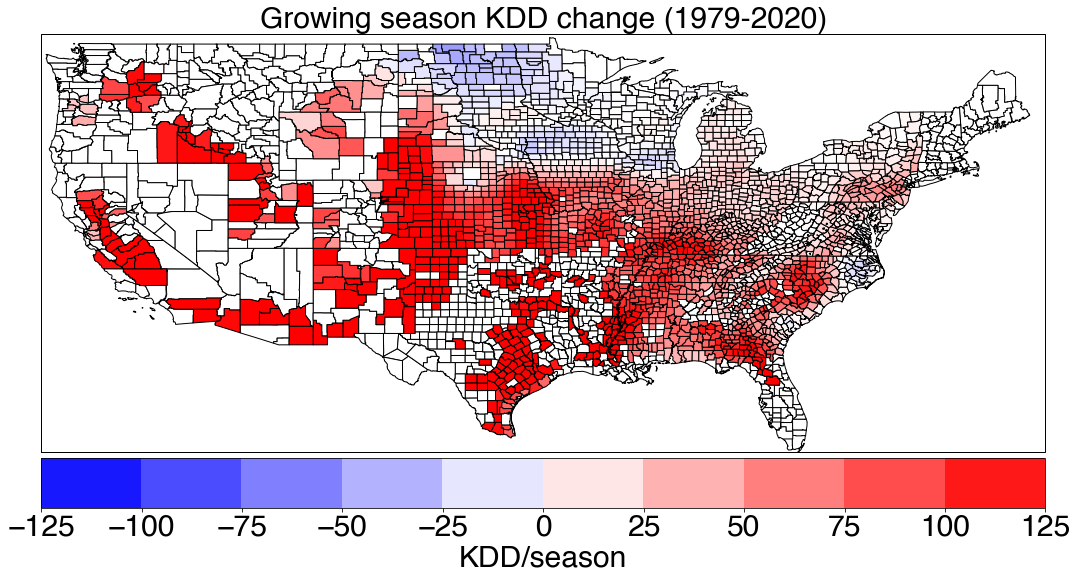

In [202]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

fig = plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-125, vmax=125)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyKddChg.keys():
        curKddChg = np.nanmean(countyKddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curKddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Growing season KDD change (1979-2020)', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-125,126,25), 
             boundaries=np.arange(-125,126,25), orientation='horizontal',
             pad=0.01)
cb.set_label('KDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-kdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

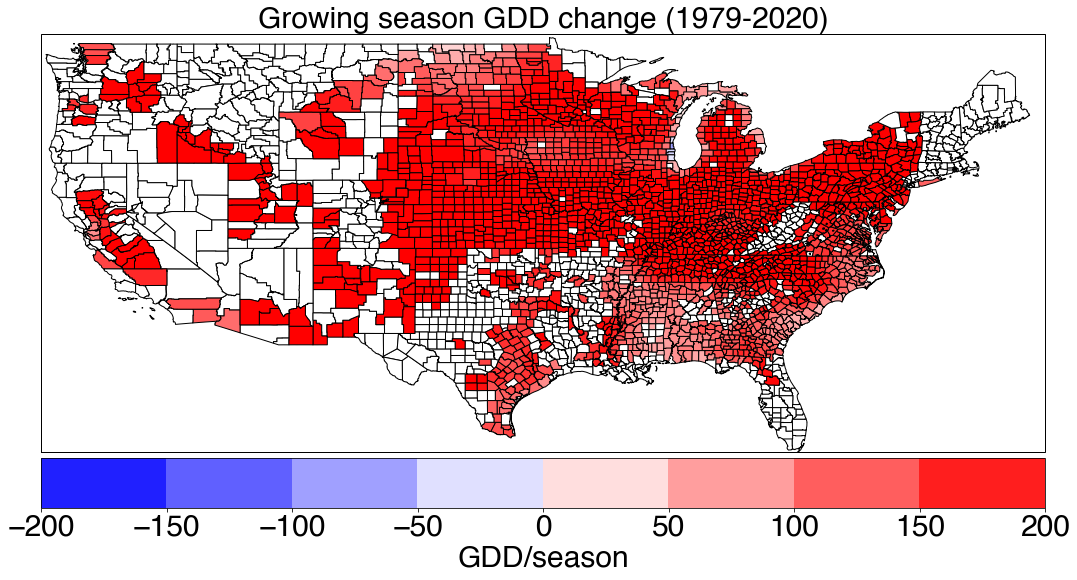

In [203]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-200, vmax=200)
cmap = plt.cm.get_cmap('bwr')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyGddChg.keys():
        curGddChg = np.nanmean(countyGddChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curGddChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season GDD change (1979-2020)', fontsize=mapFontSize)        
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-200,201,50), 
             boundaries=np.arange(-200,201,50), orientation='horizontal',
             pad=0.01)
cb.set_label('GDD/season', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-gdd-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

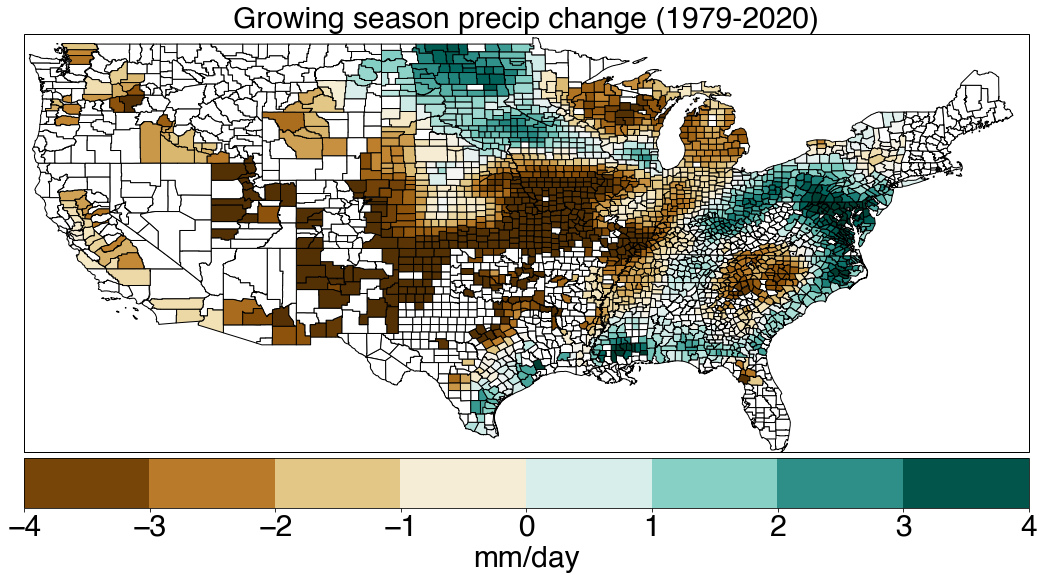

In [204]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-4, vmax=4)
cmap = plt.cm.get_cmap('BrBG')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyPrChg.keys():
        curPrChg = np.nanmean(countyPrChg[ind[0]])
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curPrChg))))
    else:
        ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))

ax.set_title('Growing season precip change (1979-2020)', fontsize=mapFontSize)    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-4,4.1,1), 
             boundaries=np.arange(-4,4.1,1), orientation='horizontal',
             pad=0.01)
cb.set_label('mm/day', fontsize=mapFontSize)
cb.ax.tick_params(labelsize=mapFontSize)
# plt.savefig('us-pr-chg.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

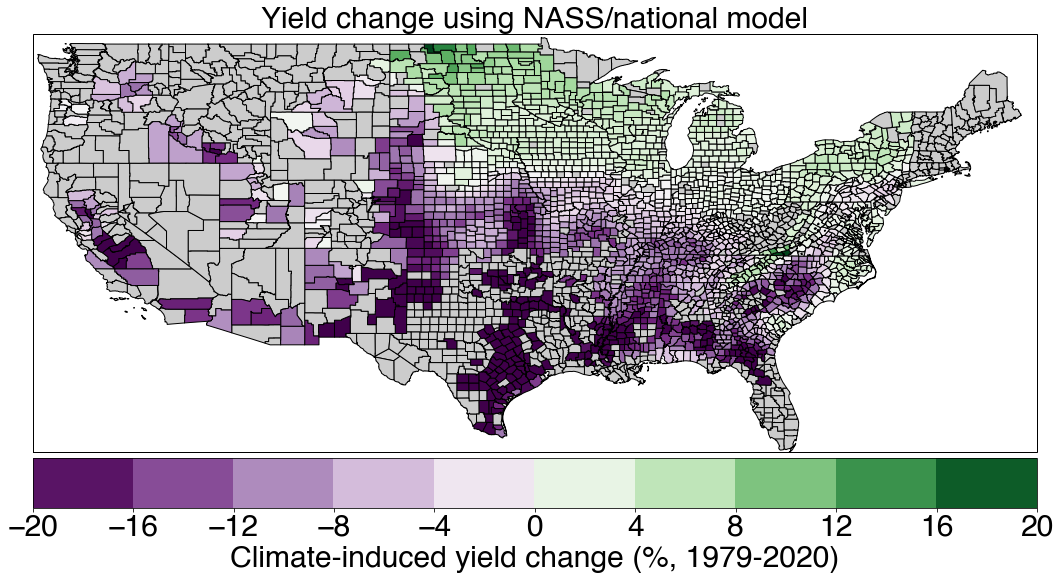

In [205]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomes.keys():
        curYieldChg = np.nanmean(countyOutcomes[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='#cccccc'))
ax.set_title('Yield change using NASS/national model', fontsize=mapFontSize)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.ax.tick_params(labelsize=mapFontSize)
cb.set_label('Climate-induced yield change (%, 1979-2020)', fontsize=mapFontSize)
# plt.savefig('us-yield-chg-nass-national.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0)

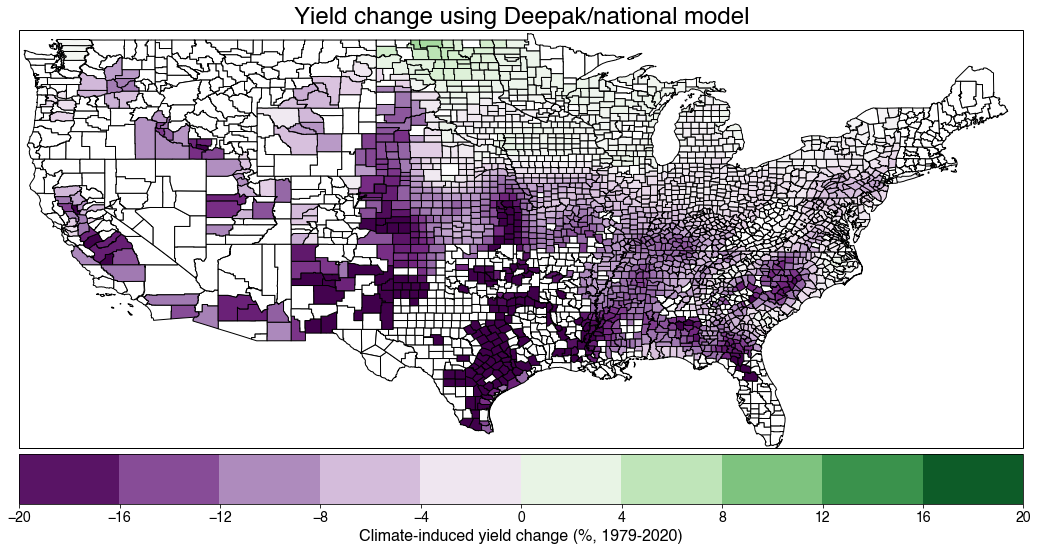

In [206]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesDeepak.keys():
        curYieldChg = np.nanmean(countyOutcomesDeepak[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/national model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
# plt.savefig('us-yield-chg-deepak-national.eps', format='eps', dpi=500, bbox_inches = 'tight', pad_inches = 0)

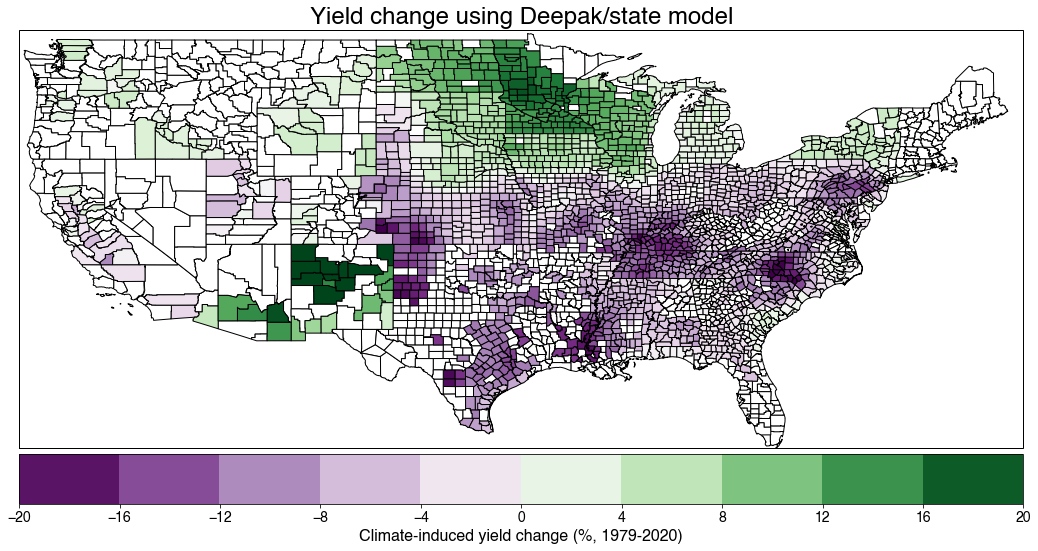

In [207]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesState.keys():
        curYieldChg = np.nanmean(countyOutcomesState[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using Deepak/state model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

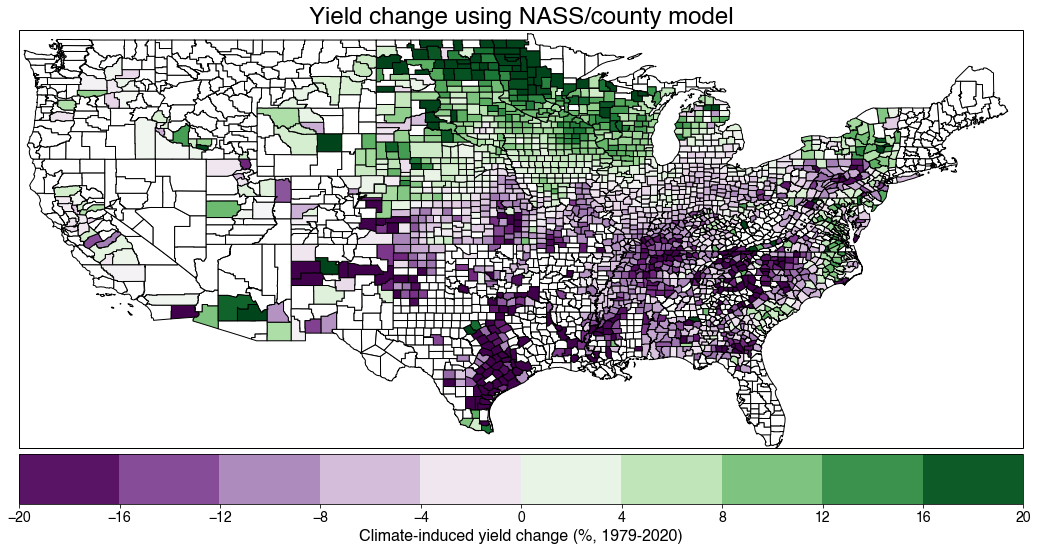

In [208]:
countyShapefileName = '%s/us-county-lat-long/cb_2018_us_county_5m.shp'%(dataDirDiscovery)
countyShp = Reader(countyShapefileName)

plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([235, 294, 25, 46])

norm = Normalize(vmin=-20, vmax=20)
cmap = plt.cm.get_cmap('PRGn')

for c, county in enumerate(countyShp.records()):
    curFips = county.attributes['GEOID']
    
    ind = np.where(countyFips == curFips)[0]
    if len(ind) > 0 and ind[0] in countyOutcomesCounty.keys():
        curYieldChg = np.nanmean(countyOutcomesCounty[ind[0]])
        if not np.isnan(curYieldChg):
            ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor=cmap(norm(curYieldChg))))
            continue
    ax.add_feature(ShapelyFeature([county.geometry], ccrs.PlateCarree(), edgecolor='black', facecolor='white'))
ax.set_title('Yield change using NASS/county model', fontsize=24)
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(-20,21,4), 
             boundaries=np.arange(-20,21,4), orientation='horizontal',
             pad=0.01)
cb.set_label('Climate-induced yield change (%, 1979-2020)')
plt.show()

In [ ]:
startPeriod = range(2, 25)
startPeriod = [5]

lowYieldThresh = 25
highYieldThresh = 75

useDeepak = True

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

lowYieldChg = []
allYieldChg = []
allMeanYield = []
allStartingYield = []
highYieldChg = []

lowProd = []
lowProdChg = []
allProdChg = []
allProd = []
highProd = []
highProdChg = []

for spInd, sp in enumerate(startPeriod):        
    startingYields = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh)))[0]
    indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh)))[0]

    if useDeepak:
        projYieldChg = countyOutcomesDeepak
    else:
        projYieldChg = countyOutcomes

    for i in indLow:
        if i in projYieldChg.keys():
            lowYieldChg.append(projYieldChg[i])
            lowProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            lowProd.append(np.nanmean(allCountyProd[i]))
    for i in indHigh:
        if i in projYieldChg.keys():
            highYieldChg.append(projYieldChg[i])
            highProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
            highProd.append(np.nanmean(allCountyProd[i]))
    for i in projYieldChg.keys():
        allYieldChg.append(projYieldChg[i])
        allMeanYield.append(np.nanmean(allCountyYields[i,:]))
        allStartingYield.append(startingYields[i])
        allProdChg.append(np.nanmean(projYieldChg[i])/100*np.nanmean(allCountyProd[i, :]))
        allProd.append(np.nanmean(allCountyProd[i]))
        
lowYieldChg = np.nanmean(np.array(lowYieldChg), axis=1)
highYieldChg = np.nanmean(np.array(highYieldChg), axis=1)
allYieldChg = np.nanmean(np.array(allYieldChg), axis=1)
allMeanYield = np.array(allMeanYield)
allStartingYield = np.array(allStartingYield)

lowProdChg = np.array(lowProdChg)
lowProd = np.array(lowProd)

allProdChg = np.array(allProdChg)
allProd = np.array(allProd)

highProdChg = np.array(highProdChg)
highProd = np.array(highProd)


In [ ]:
X = sm.add_constant(allMeanYield)
mdl = sm.OLS(allYieldChg, X).fit()

x1 = 3.5
x2 = 11.5

plt.figure(figsize=(6,6))
plt.xlim([2.5, 12.5])
plt.scatter(allMeanYield, allYieldChg, c='#5bc718')
plt.plot([x1, x2], [mdl.params[0]+x1*mdl.params[1], mdl.params[0]+x2*mdl.params[1]], '--k', lw=2, label='p < 0.01')
plt.plot([2.5, 12.5], [0, 0], '-k', lw=1)
plt.xlabel('Mean yield (t/ha)', fontsize=20)
plt.ylabel('Climate-induced yield change (%)', fontsize=20)
plt.yticks(np.arange(-50, 21, 10))
plt.tick_params(axis='x', labelsize=20)
plt.tick_params(axis='y', labelsize=20)

l1 = plt.legend(prop = {'size':20, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)
plt.savefig('climate-yield-trends-vs-mean-yield.png', format='png', dpi=100, bbox_inches = 'tight', pad_inches = 0.1)


In [ ]:
print(np.nanmedian(lowProdChg)/np.nanmean(lowProd)*100)
print(np.nanmedian(highProdChg)/np.nanmean(highProd)*100)
print(np.nanmedian(allProdChg)/np.nanmean(allProd)*100)

In [ ]:
print(np.nanmedian(lowYieldChg))
print(np.nanmedian(highYieldChg))
print(np.nanmedian(allYieldChg))

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(7, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(lowYieldChg, density=True, color='#5bc718')
ax1.set_xlim([-50, 30])
ax1.set_ylim([0, .07])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(lowYieldChg), np.nanmedian(lowYieldChg)], [0, 0.07], '--k', lw=2, label='Low productivity\n(< %dth percentile)\nyield change'%lowYieldThresh)
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l1.get_frame().set_linewidth(0)

ax2.hist(highYieldChg, density=True, color='#5bc718')
ax2.set_xlim([-50, 30])
ax2.set_ylim([0, .07])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(highYieldChg), np.nanmedian(highYieldChg)], [0, 0.07], '--k', lw=2, label='High productivity\n(> %dth percentile)\nyield change'%highYieldThresh)
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l2.get_frame().set_linewidth(0)

ax3.hist(allYieldChg, density=True, color='#5bc718')
ax3.set_xlim([-50, 30])
ax3.set_ylim([0, .07])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(allYieldChg), np.nanmedian(allYieldChg)], [0, 0.07], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'}, loc='upper left')
l3.get_frame().set_linewidth(0)

plt.savefig('us-yield-chg-by-mean-yield.png', format='png', dpi=200, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
ks_pl_pa = scipy.stats.ks_2samp(lowYieldChg, allYieldChg)
ks_pl_ph = scipy.stats.ks_2samp(lowYieldChg, highYieldChg)
ks_ph_pa = scipy.stats.ks_2samp(highYieldChg, allYieldChg)

print('KS-test: low productivity vs all counties: %.10f'%ks_pl_pa.pvalue)
print('KS-test: low productivity vs high productivity counties: %.10f'%ks_pl_ph.pvalue)
print('KS-test: high productivity vs all counties: %.10f'%ks_ph_pa.pvalue)

In [ ]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

In [ ]:
startPeriod = range(7, 14)
endPeriod = range(7, 14)

yieldRangeThreshLen = 10
lowYieldThresh = range(20,20+yieldRangeThreshLen)
highYieldThresh = range(70,70+yieldRangeThreshLen)

pl = []
ph = []
pa = []
weightedProdChg = []

N = yieldRangeThreshLen*len(startPeriod)*len(endPeriod)
n = 0

useDeepak = True

if useDeepak:
    yieldVar = 'maizeYieldDeepak'
else:
    yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

for r in range(yieldRangeThreshLen):

    for sp in startPeriod:
        
        startingYields = []
        countyInds = []
        for startingYield in np.array(list(countyList[yieldVar])):
            indStart = np.where(~np.isnan(startingYield))[0][0]
            indEnd = np.where(~np.isnan(startingYield))[0][-1]

            countyInds.append((indStart, indEnd))

            ind2 = indStart+sp
            if ind2 > len(startingYield): 
                ind2 = len(startingYield)
            startingYields.append(np.nanmean(startingYield[indStart:ind2]))

        indLow = np.where((startingYields < np.nanpercentile(startingYields, lowYieldThresh[r])))[0]
        indHigh = np.where((startingYields >= np.nanpercentile(startingYields, highYieldThresh[r])))[0]

        for ep in endPeriod:
            
            if n % 100 == 0:
                print('%.0f %%'%(n/N*100))
            
            n += 1
            
            gddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indLow])))
            
            gddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indLow])])))
            kddAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indLow])])))
            prAggLowEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indLow])])))
            countyFELowEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indLow])))

            gddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])))
            kddAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])))
            prAggAllEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])))
            countyFEAllEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in range(np.array(list(usCounties['gdd'])).shape[0])])))

            gddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighStart = np.array(list(itertools.chain.from_iterable([x[0:sp] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighStart = np.array(list(itertools.chain.from_iterable([[c]*(sp) for c in indHigh])))

            gddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['gdd']))[indHigh])])))
            kddAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['kdd']))[indHigh])])))
            prAggHighEnd = np.array(list(itertools.chain.from_iterable([x[-ep:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip']))[indHigh])])))
            countyFEHighEnd = np.array(list(itertools.chain.from_iterable([[c]*(ep) for c in indHigh])))
            
            countyYieldsLow = np.array([np.nanmean(allCountyYields[c,:]) for c in indLow])
            countyYieldsHigh = np.array([np.nanmean(allCountyYields[c,:]) for c in indHigh])
            countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])

            XLowStart = {'GDD':gddAggLowStart, 'KDD':kddAggLowStart, 'Pr':prAggLowStart, 'Pr2':prAggLowStart**2, 'County':countyFELowStart}
            XLowEnd = {'GDD':gddAggLowEnd, 'KDD':kddAggLowEnd, 'Pr':prAggLowEnd, 'Pr2':prAggLowEnd**2, 'County':countyFELowEnd}
            XHighStart = {'GDD':gddAggHighStart, 'KDD':kddAggHighStart, 'Pr':prAggHighStart, 'Pr2':prAggHighStart**2, 'County':countyFEHighStart}
            XHighEnd = {'GDD':gddAggHighEnd, 'KDD':kddAggHighEnd, 'Pr':prAggHighEnd, 'Pr2':prAggHighEnd**2, 'County':countyFEHighEnd}
            XAllStart = {'GDD':gddAggAllStart, 'KDD':kddAggAllStart, 'Pr':prAggAllStart, 'Pr2':prAggAllStart**2, 'County':countyFEAllStart}
            XAllEnd = {'GDD':gddAggAllEnd, 'KDD':kddAggAllEnd, 'Pr':prAggAllEnd, 'Pr2':prAggAllEnd**2, 'County':countyFEAllEnd}

            if useDeepak:
                predLow1 = mdlDeepak.predict(XLowStart).mean()
                predLow2 = mdlDeepak.predict(XLowEnd).mean()
            else:
                predLow1 = mdl.predict(XLowStart).mean()
                predLow2 = mdl.predict(XLowEnd).mean()
            if predLow1 > 0 and predLow2 > 0:
                predLow = (predLow2-predLow1)/np.nanmean(countyYieldsLow)*100
                if predLow < -100 or predLow > 500:
                    predLow = np.nan
            else:
                predLow = np.nan

            if useDeepak:
                predHigh1 = mdlDeepak.predict(XHighStart).mean()
                predHigh2 = mdlDeepak.predict(XHighEnd).mean()
            else:
                predHigh1 = mdl.predict(XHighStart).mean()
                predHigh2 = mdl.predict(XHighEnd).mean()
            if predHigh1 > 0 and predHigh2 > 0:
                predHigh = (predHigh2-predHigh1)/np.nanmean(countyYieldsHigh)*100
                if predHigh < -100 or predHigh > 500:
                    predHigh = np.nan
            else:
                predHigh = np.nan

            if useDeepak:
                predAll1 = mdlDeepak.predict(XAllStart).mean()
                predAll2 = mdlDeepak.predict(XAllEnd).mean()
            else:
                predAll1 = mdl.predict(XAllStart).mean()
                predAll2 = mdl.predict(XAllEnd).mean()
            if predAll1 > 0 and predAll2 > 0:
                predAll = (predAll2-predAll1)/np.nanmean(countyYieldsAll)*100
                if predAll < -100 or predAll > 500:
                    predAll = np.nan
            else:
                predAll = np.nan

            pl.append(predLow)
            ph.append(predHigh)
            pa.append(predAll)

pl = np.array(pl)
ph = np.array(ph)
pa = np.array(pa)

In [ ]:
len(ph)

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(figsize=(5, 15), nrows=3, ncols=1, squeeze=True)
ax1.hist(pl, density=True)
ax1.set_xlim([-10, 5])
ax1.set_ylim([0, .3])
ax1.set_ylabel('Fraction of outcomes')
ax1.plot([np.nanmedian(pl), np.nanmedian(pl)], [0, 0.3], '--k', lw=2, label='Low productivity\nyield change')
l1 = ax1.legend(prop = {'size':14, 'family':'Helvetica'})
l1.get_frame().set_linewidth(0)

ax2.hist(ph, density=True)
ax2.set_xlim([-10, 5])
ax2.set_ylim([0, .3])
ax2.set_ylabel('Fraction of outcomes')
ax2.set_xlabel('Yield change (%)')
ax2.plot([np.nanmedian(ph), np.nanmedian(ph)], [0, 0.3], '--k', lw=2, label='High productivity\nyield change')
l2 = ax2.legend(prop = {'size':14, 'family':'Helvetica'})
l2.get_frame().set_linewidth(0)

ax3.hist(pa, density=True)
ax3.set_xlim([-10, 5])
ax3.set_ylim([0, .3])
ax3.set_ylabel('Fraction of outcomes')
ax3.set_xlabel('Yield change (%)')
ax3.plot([np.nanmedian(pa), np.nanmedian(pa)], [0, 0.3], '--k', lw=2, label='All county\nyield change')
l3 = ax3.legend(prop = {'size':14, 'family':'Helvetica'})
l3.get_frame().set_linewidth(0)

In [ ]:
periodLen = range(5, 15)

yieldVar = 'maizeYield'

allCountyYields = np.array(list(countyList[yieldVar]))
allCountyProd = np.array(list(countyList['maizeProd']))

allCountyProdChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)
allCountyYieldChg = np.full([allCountyProd.shape[0], len(periodLen)], np.nan)

N = allCountyProd.shape[0]*len(periodLen)
n = 0

for pInd, p in enumerate(periodLen):

    startingYields = []
    countyInds = []
    for startingYield in np.array(list(countyList[yieldVar])):
        indStart = np.where(~np.isnan(startingYield))[0][0]
        indEnd = np.where(~np.isnan(startingYield))[0][-1]

        countyInds.append((indStart, indEnd))

        ind2 = indStart+sp
        if ind2 > len(startingYield): 
            ind2 = len(startingYield)
        startingYields.append(np.nanmean(startingYield[indStart:ind2]))

    gddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllStart = np.array([x[0:p] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    gddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['gdd'])))])
    kddAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['kdd'])))])
    prAggAllEnd = np.array([x[-p:] for i, x in enumerate(np.array(list(usCounties['seasonalPrecip'])))])

    countyYieldsAll = np.array([np.nanmean(allCountyYields[c,:]) for c in range(allCountyYields.shape[0])])
    countyProdsAll = np.array([[np.nansum(allCountyProd[c,:])] for c in range(allCountyProd.shape[0])])

    for c in range(gddAggAllStart.shape[0]):
        XAllStart = {'GDD':gddAggAllStart[c,:], 'KDD':kddAggAllStart[c,:], 'Pr':prAggAllStart[c,:], 'Pr2':prAggAllStart**2}
        XAllEnd = {'GDD':gddAggAllEnd[c,:], 'KDD':kddAggAllEnd[c,:], 'Pr':prAggAllEnd[c,:], 'Pr2':prAggAllEnd[c,:]**2}

        predAll1 = mdl.predict(XAllStart)
        predAll2 = mdl.predict(XAllEnd)

        chg = (predAll2-predAll1)/countyYieldsAll[c]
        allCountyYieldChg[c, pInd] = np.nanmean(chg)
        allCountyProdChg[c, pInd] = np.nanmean(chg*countyProdsAll[c])
        
        if n % 500 == 0:
            print('%.0f %%'%(n/N*100))
        
        n += 1

In [ ]:
print('%.2f'%(np.nansum(np.nanmean(allCountyProdChg, axis=1))/np.nansum(allCountyProd)*100))
print('%.2f'%(np.nanmean(np.nanmean(allCountyYieldChg, axis=1)/np.nanmean(allCountyYields, axis=1))*100))